# Flood Model Training Notebook

Train a Flood ConvLSTM Model using `usl_models` lib.

In [13]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from usl_models.flood_ml import constants
from usl_models.flood_ml.model import FloodModel, FloodModelParams
from usl_models.flood_ml.dataset import load_dataset_windowed, load_dataset

sim_names = ["Phoenix_PV-PHX_PV/Rainfall_Data_1.txt"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
dataset = load_dataset_windowed(sim_names=sim_names, batch_size=6, dataset_split='train')

In [32]:
num_samples = 0
for batch in dataset:
    num_samples += batch[0]['spatiotemporal'].shape[0]
print("Number of samples:", num_samples)

Number of samples: 325


Visualizing Batch 1/10


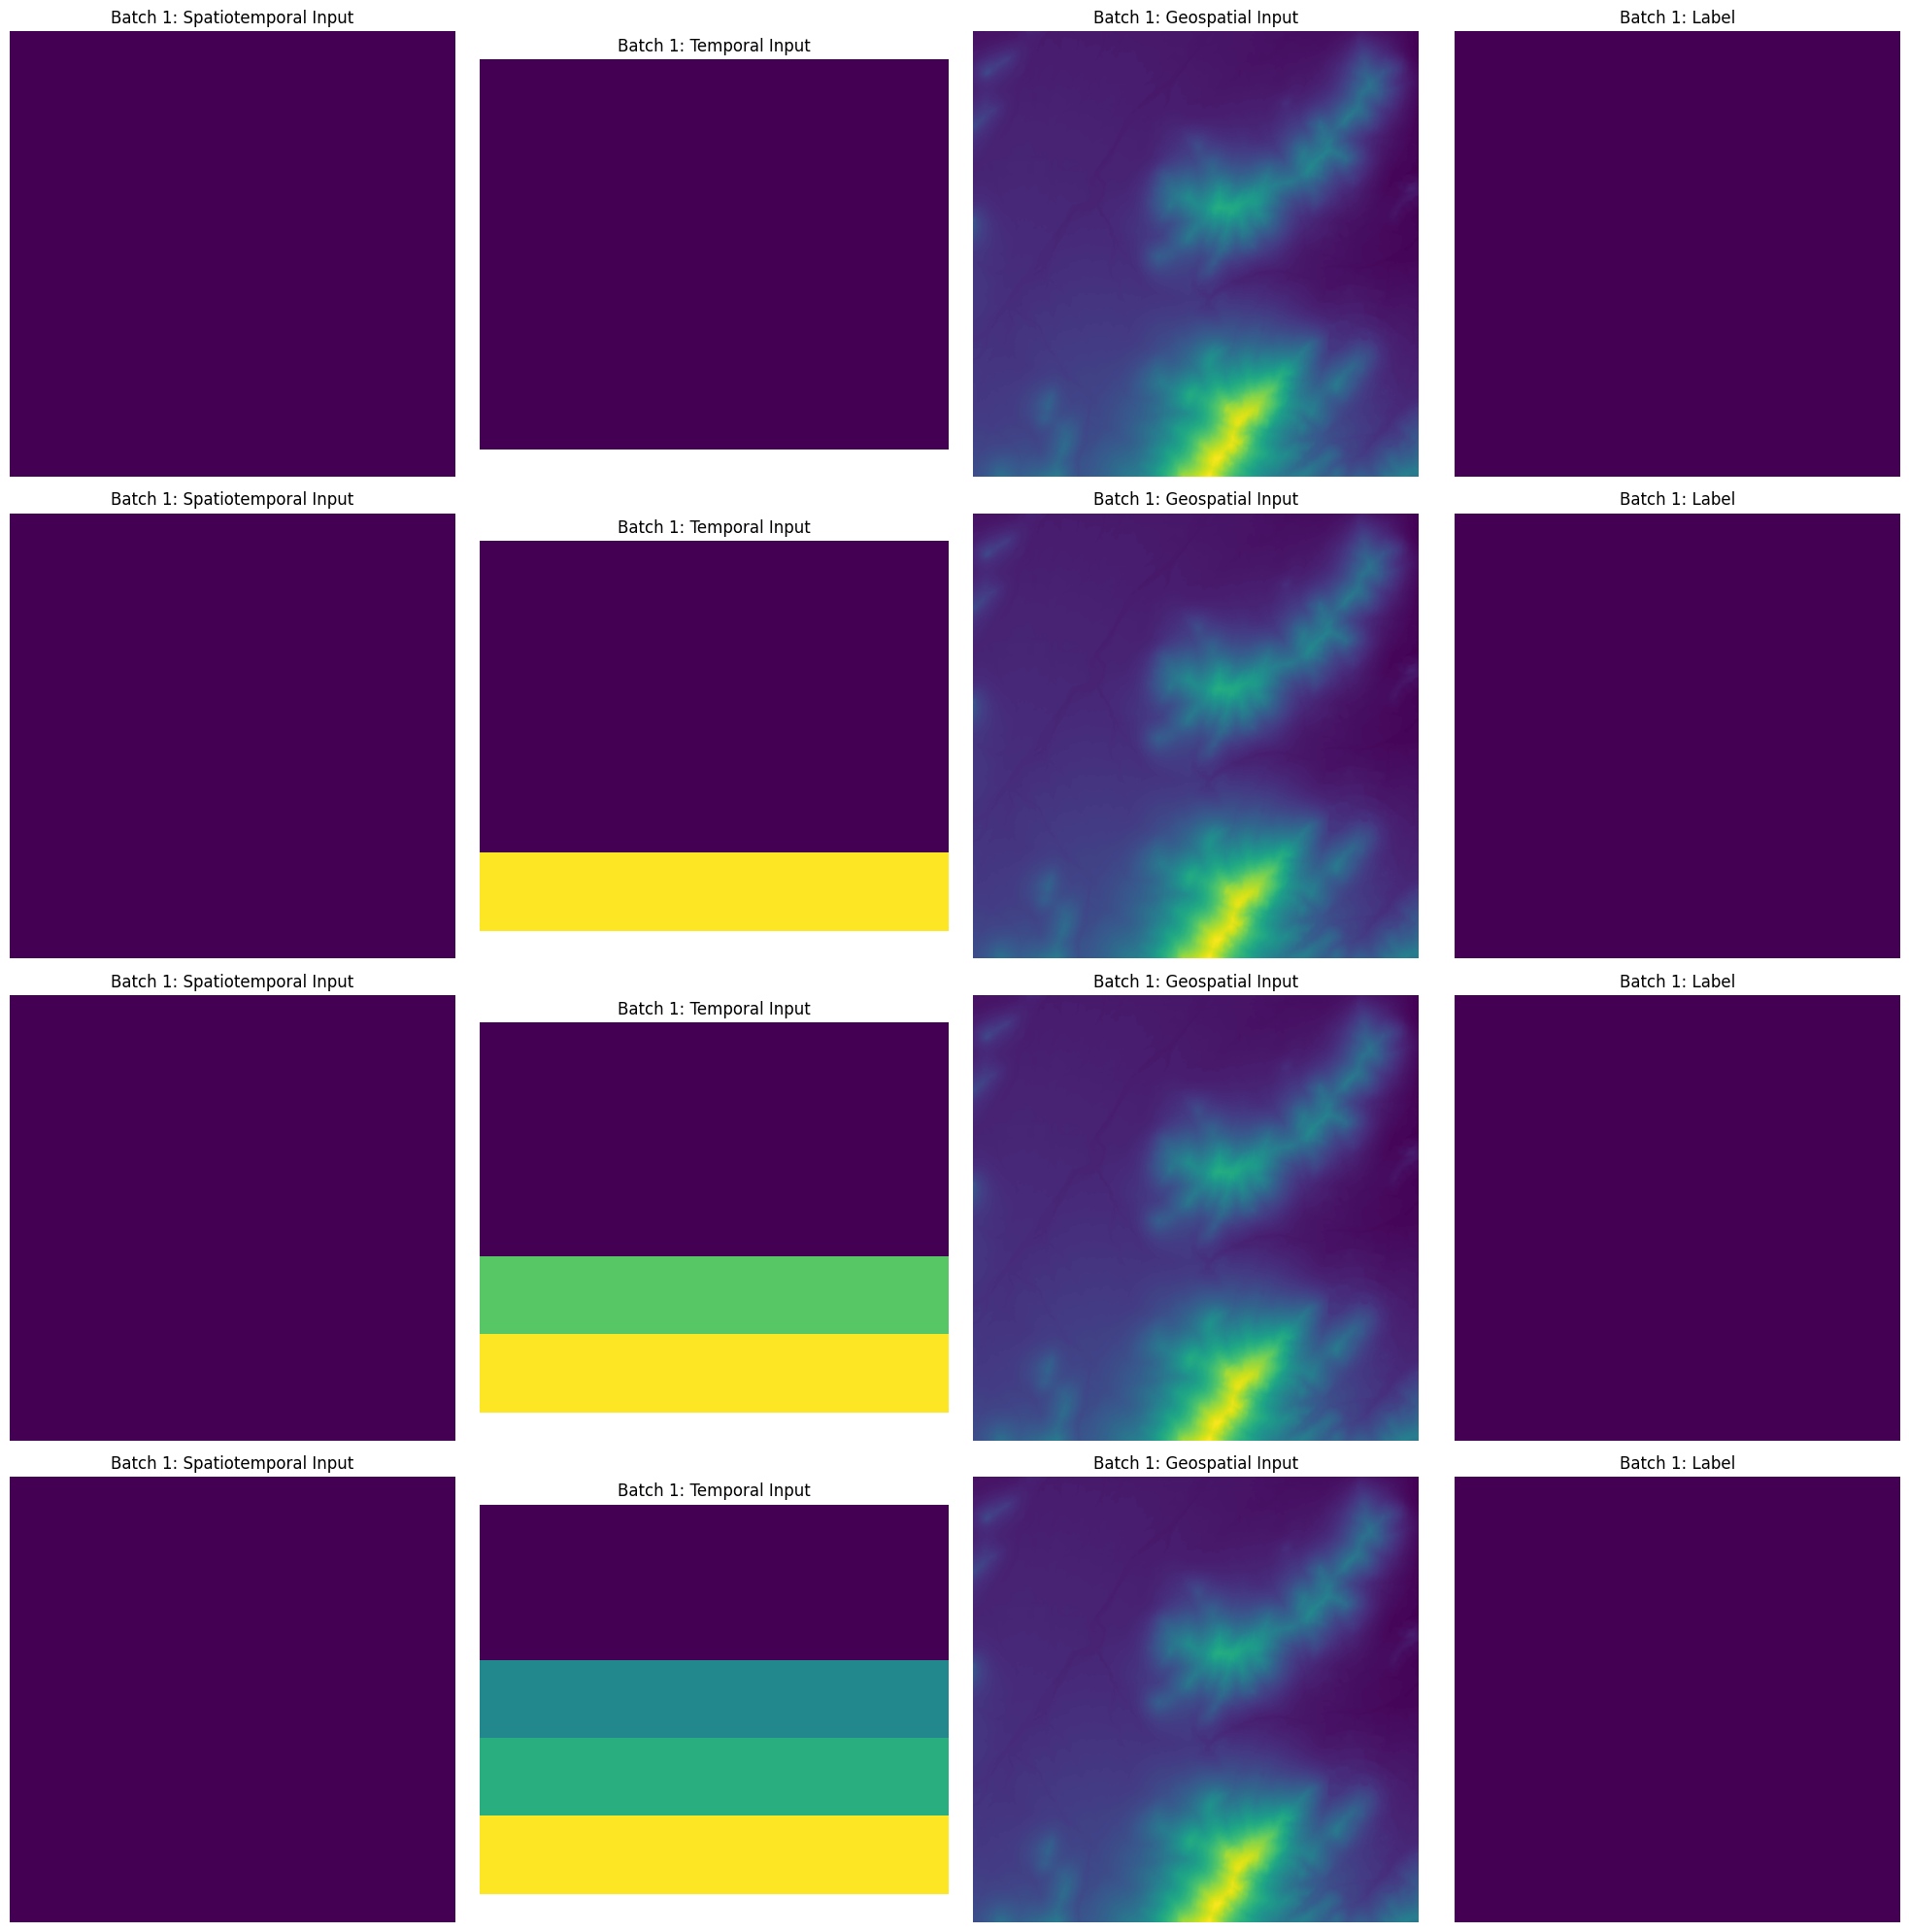

Visualizing Batch 2/10


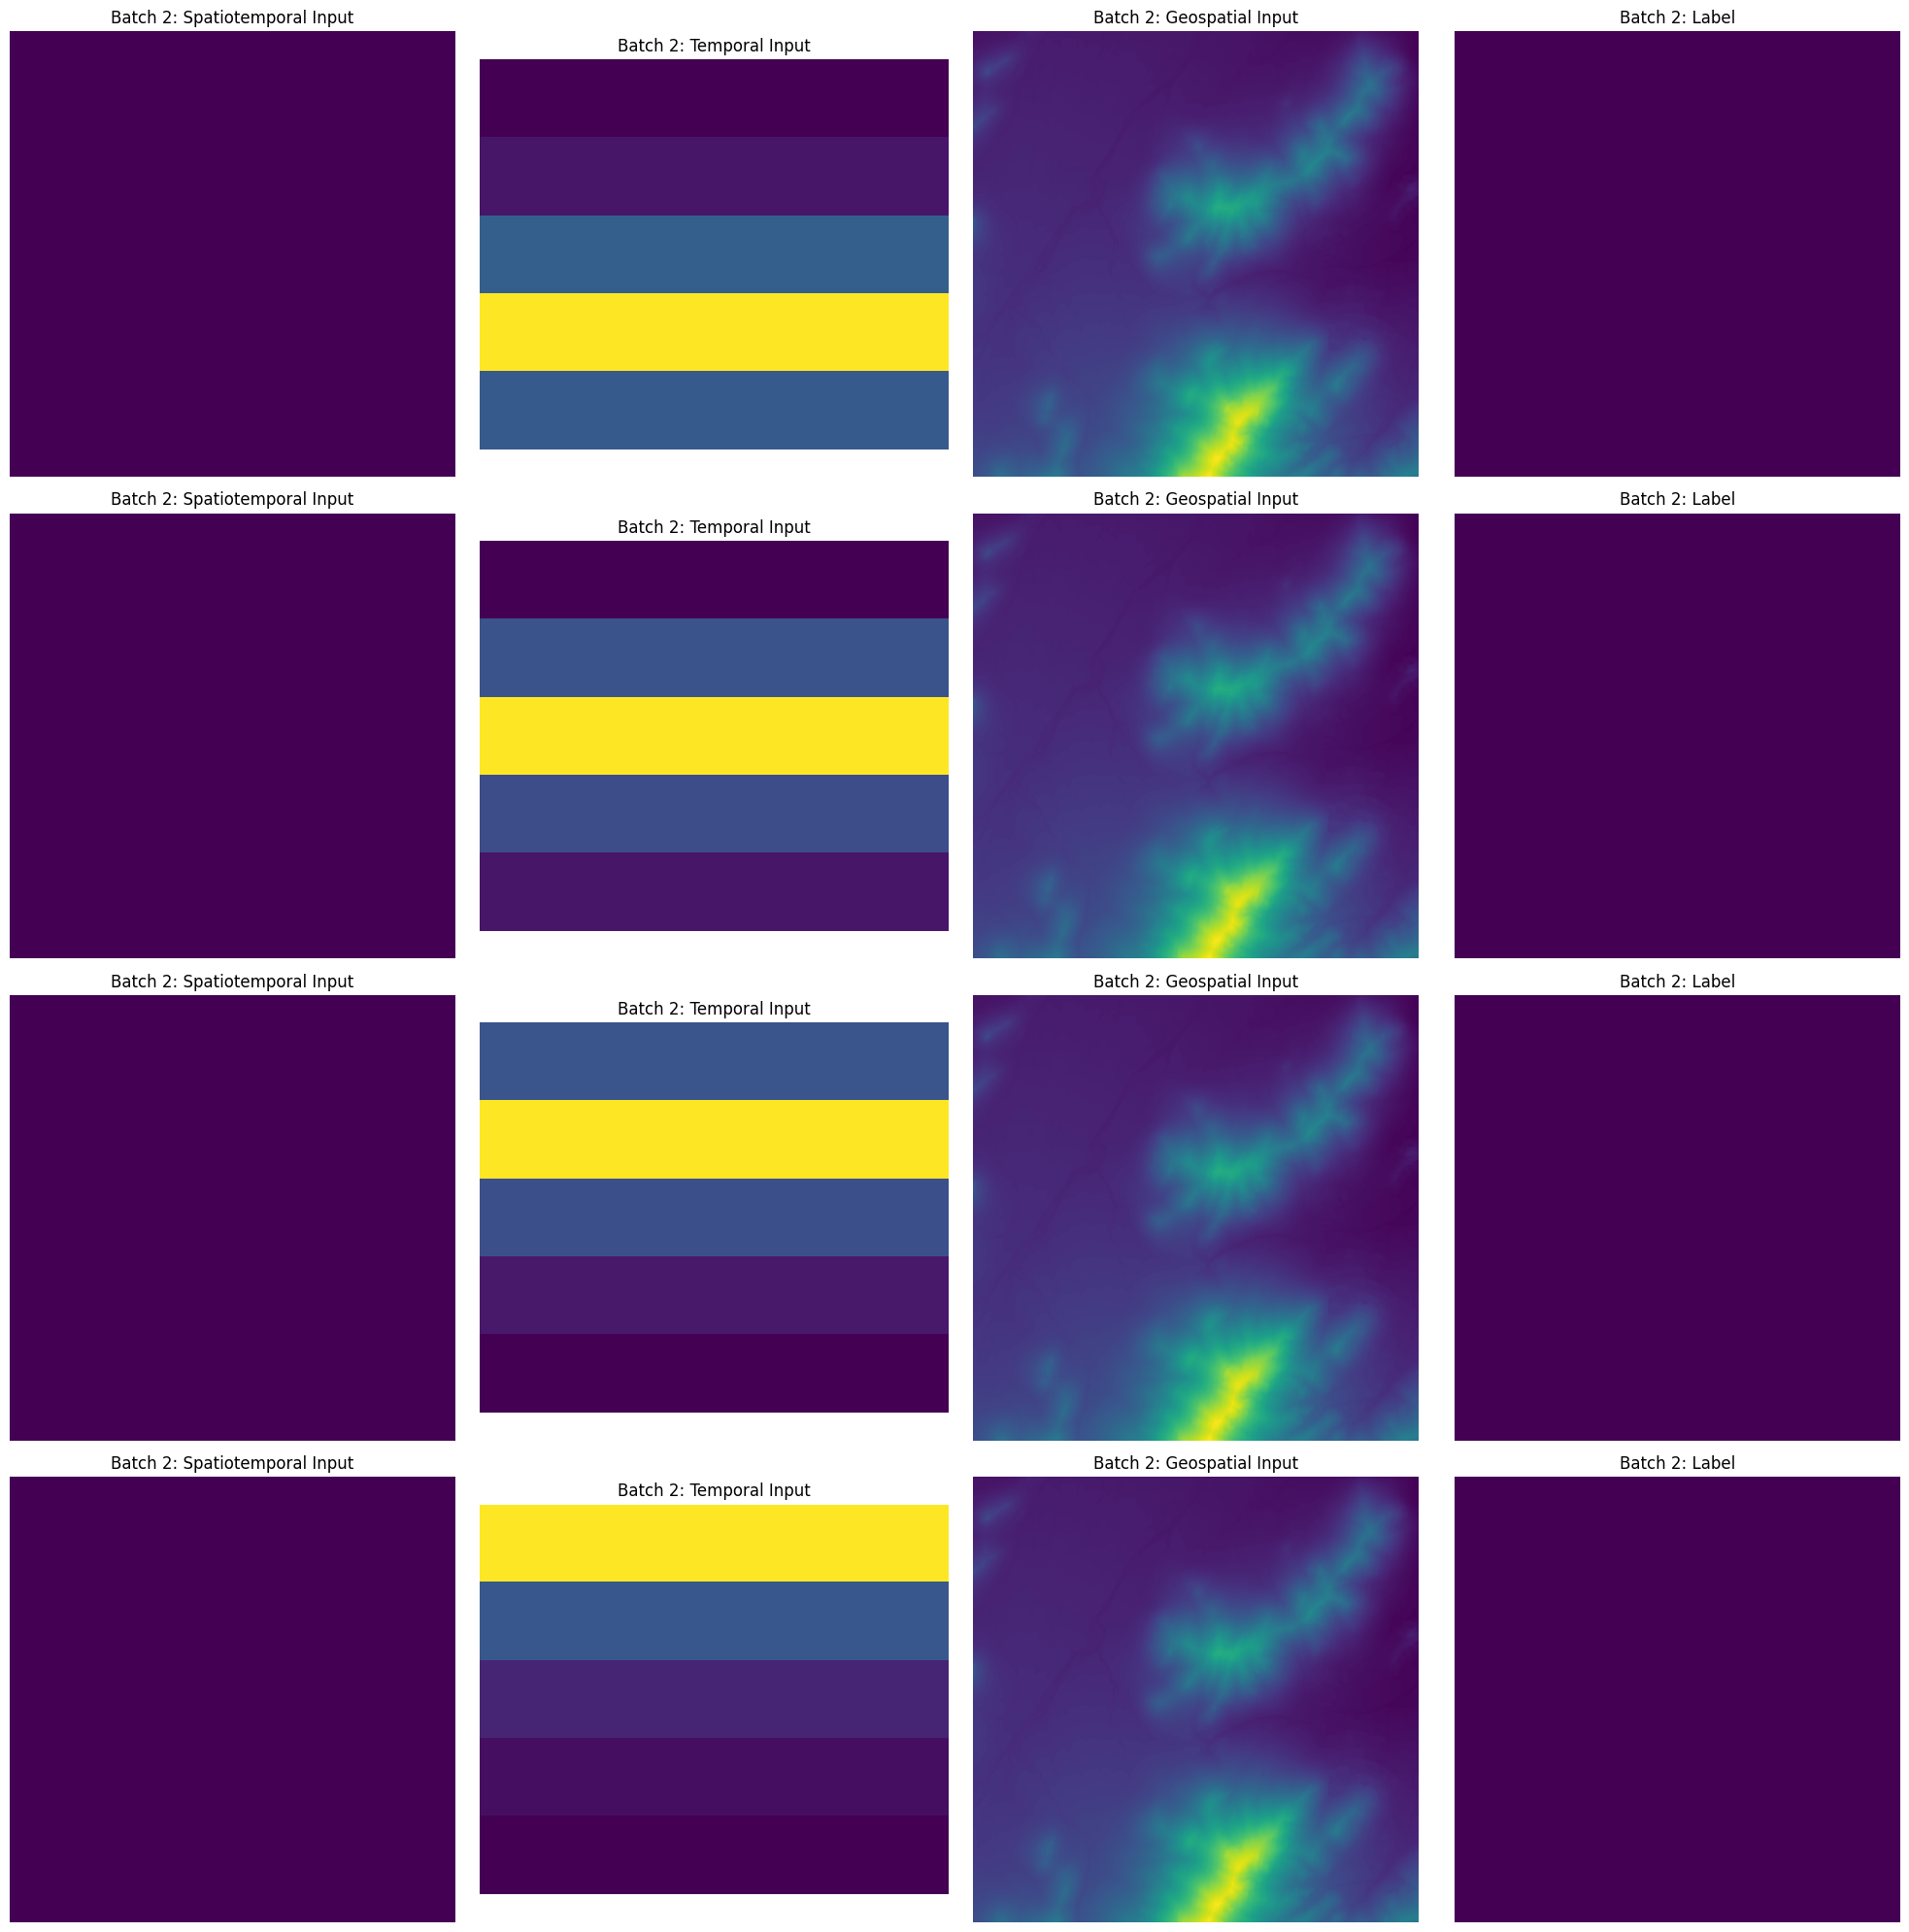

Visualizing Batch 3/10


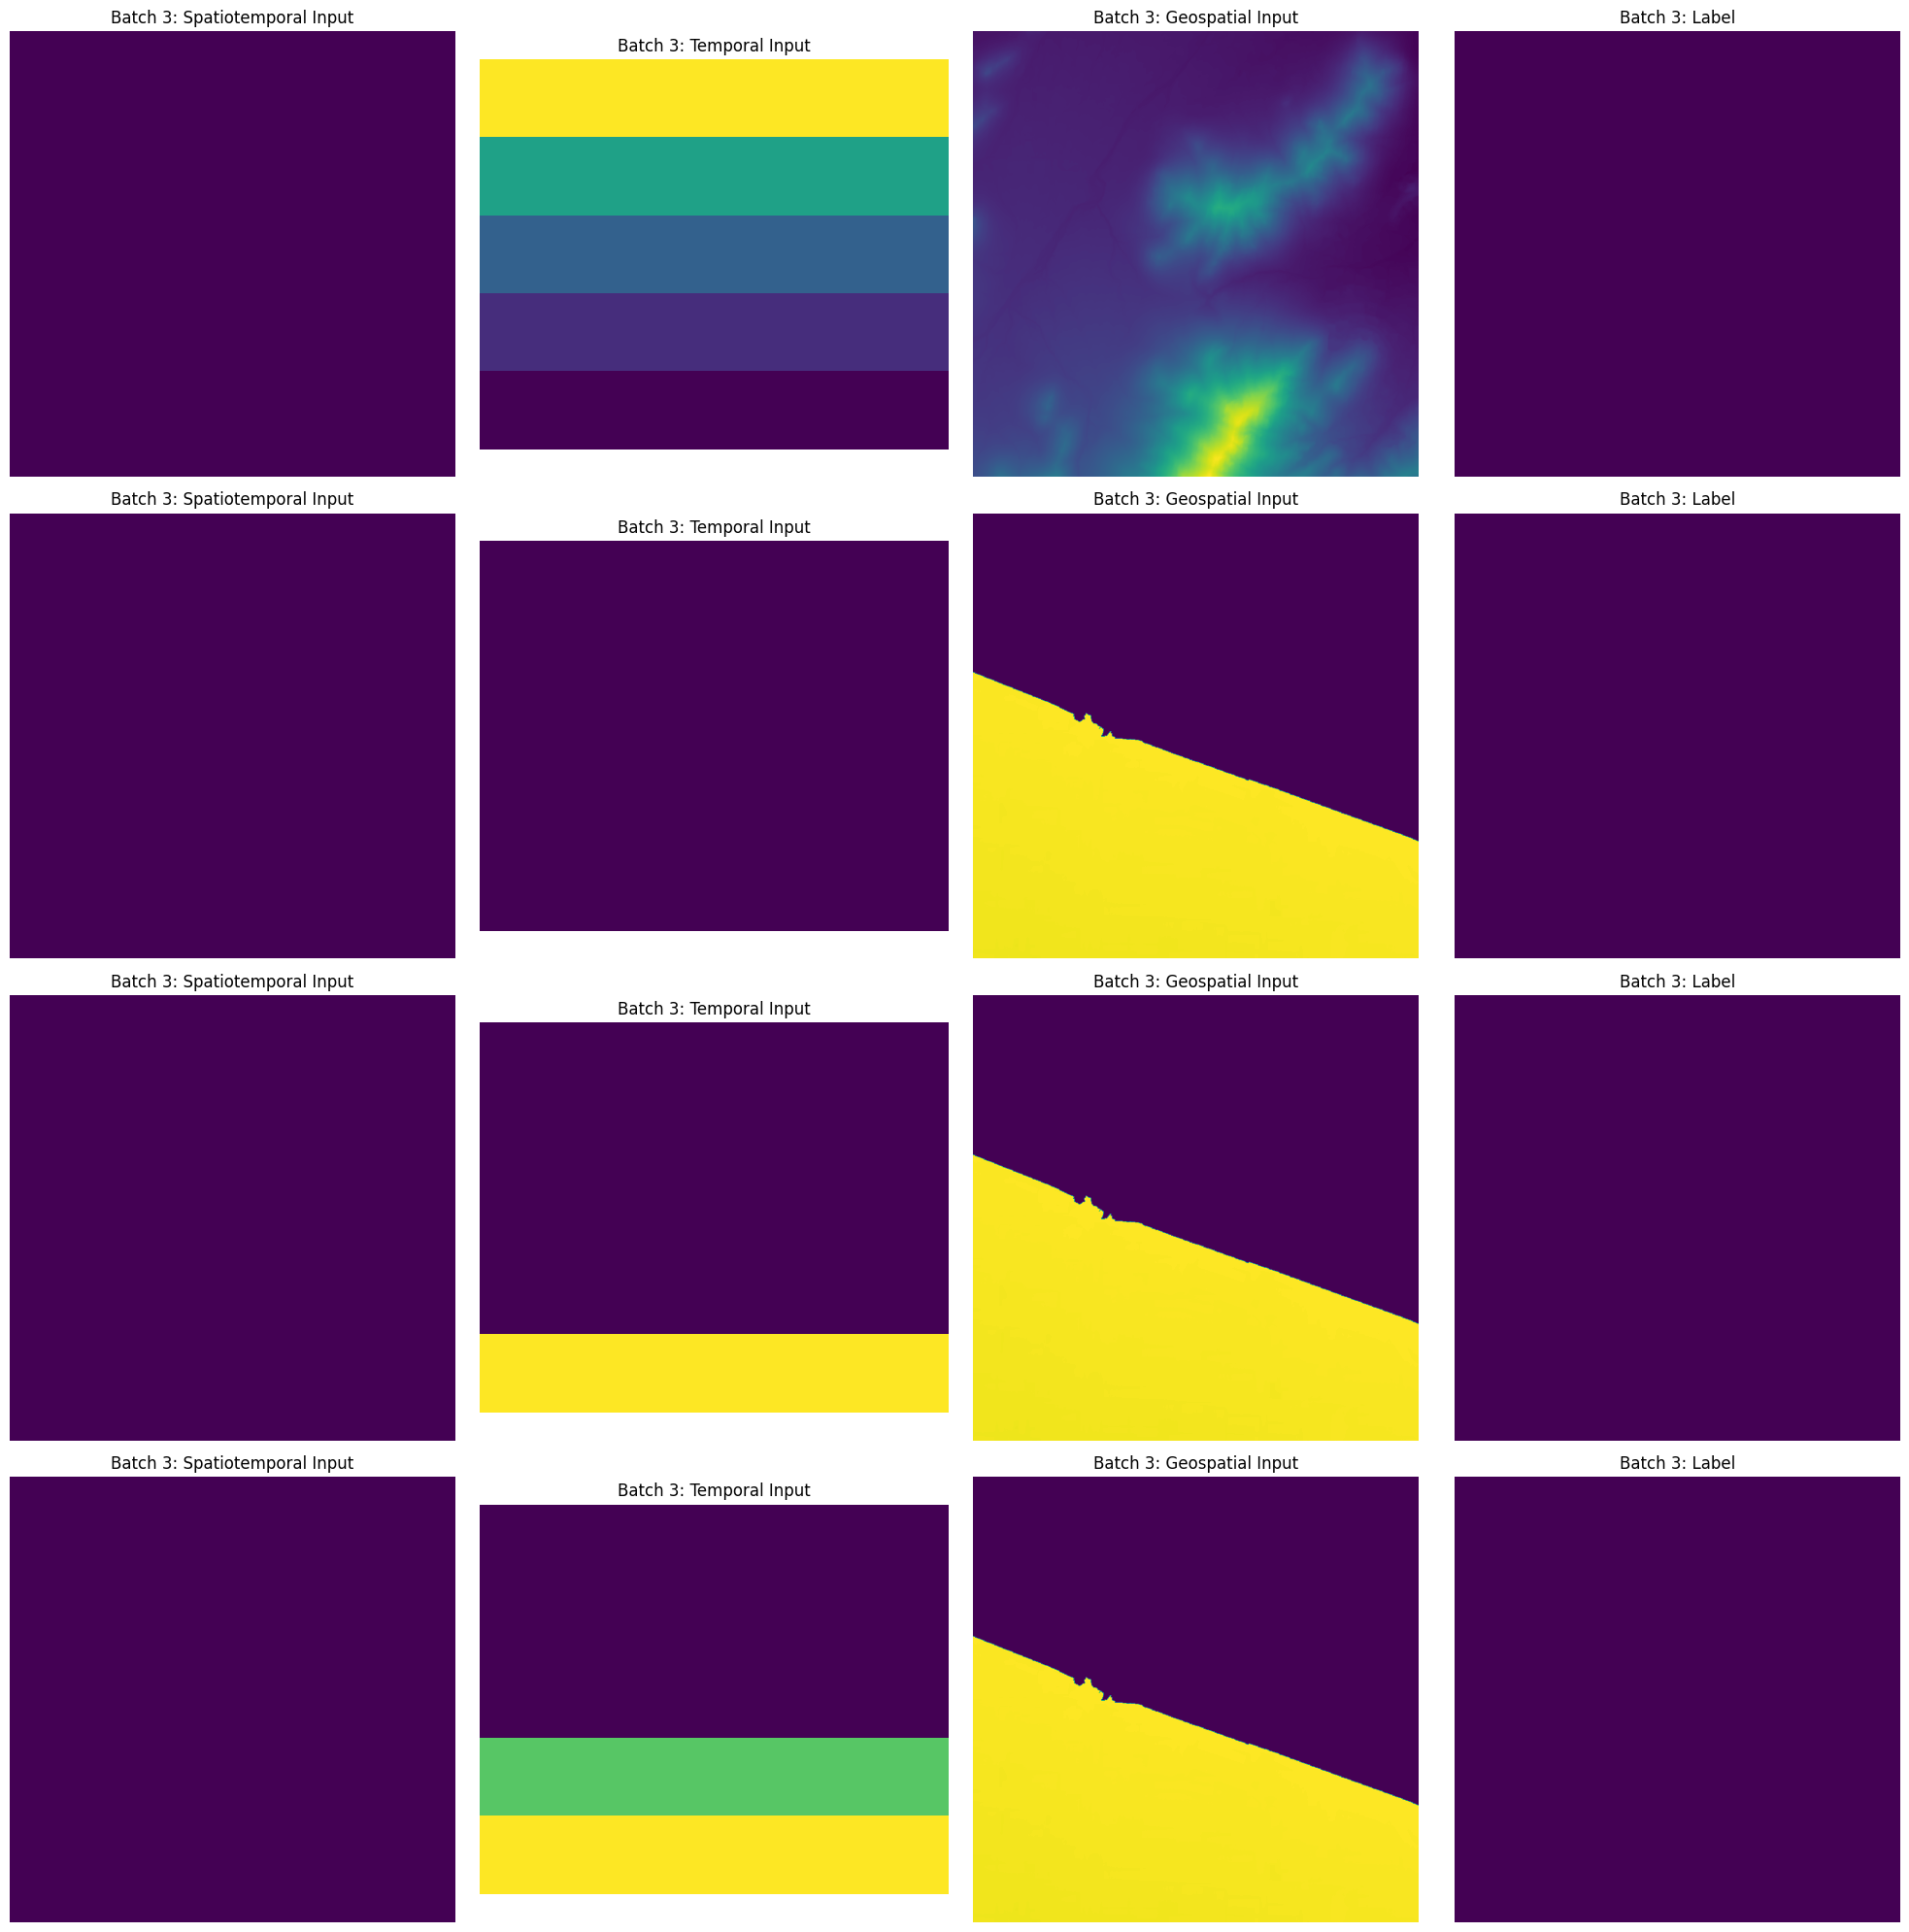

Visualizing Batch 4/10


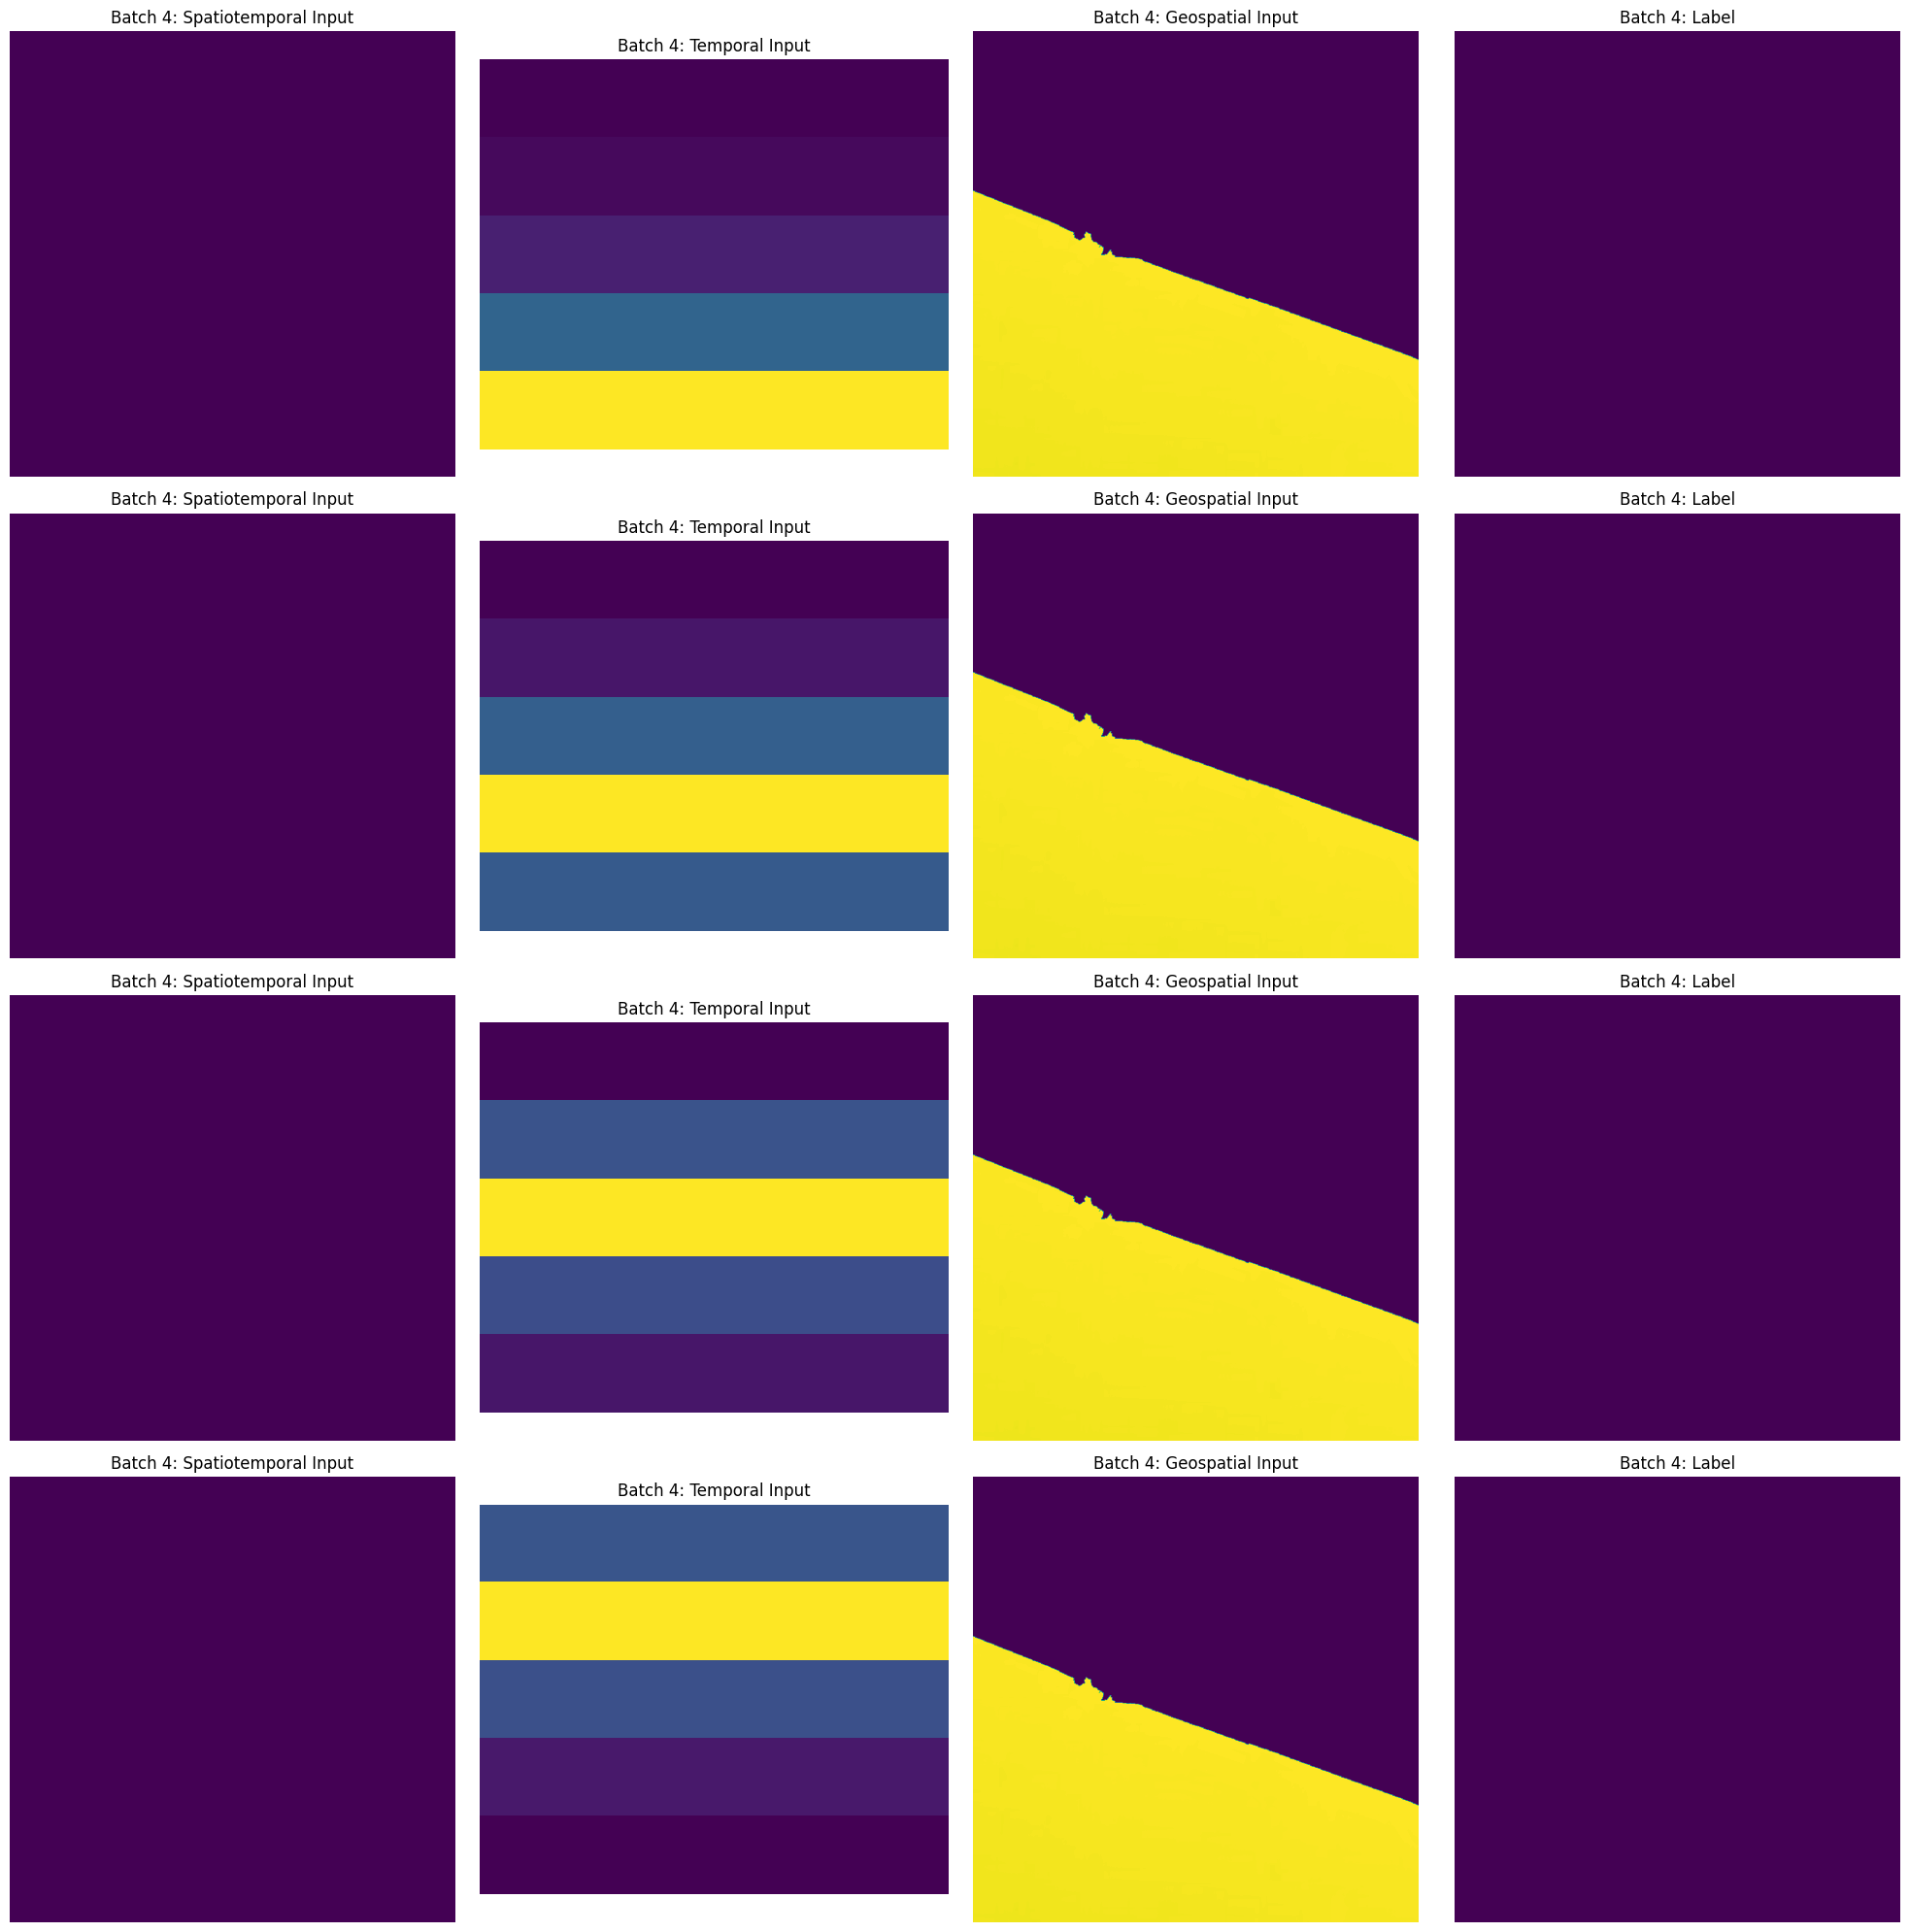

Visualizing Batch 5/10


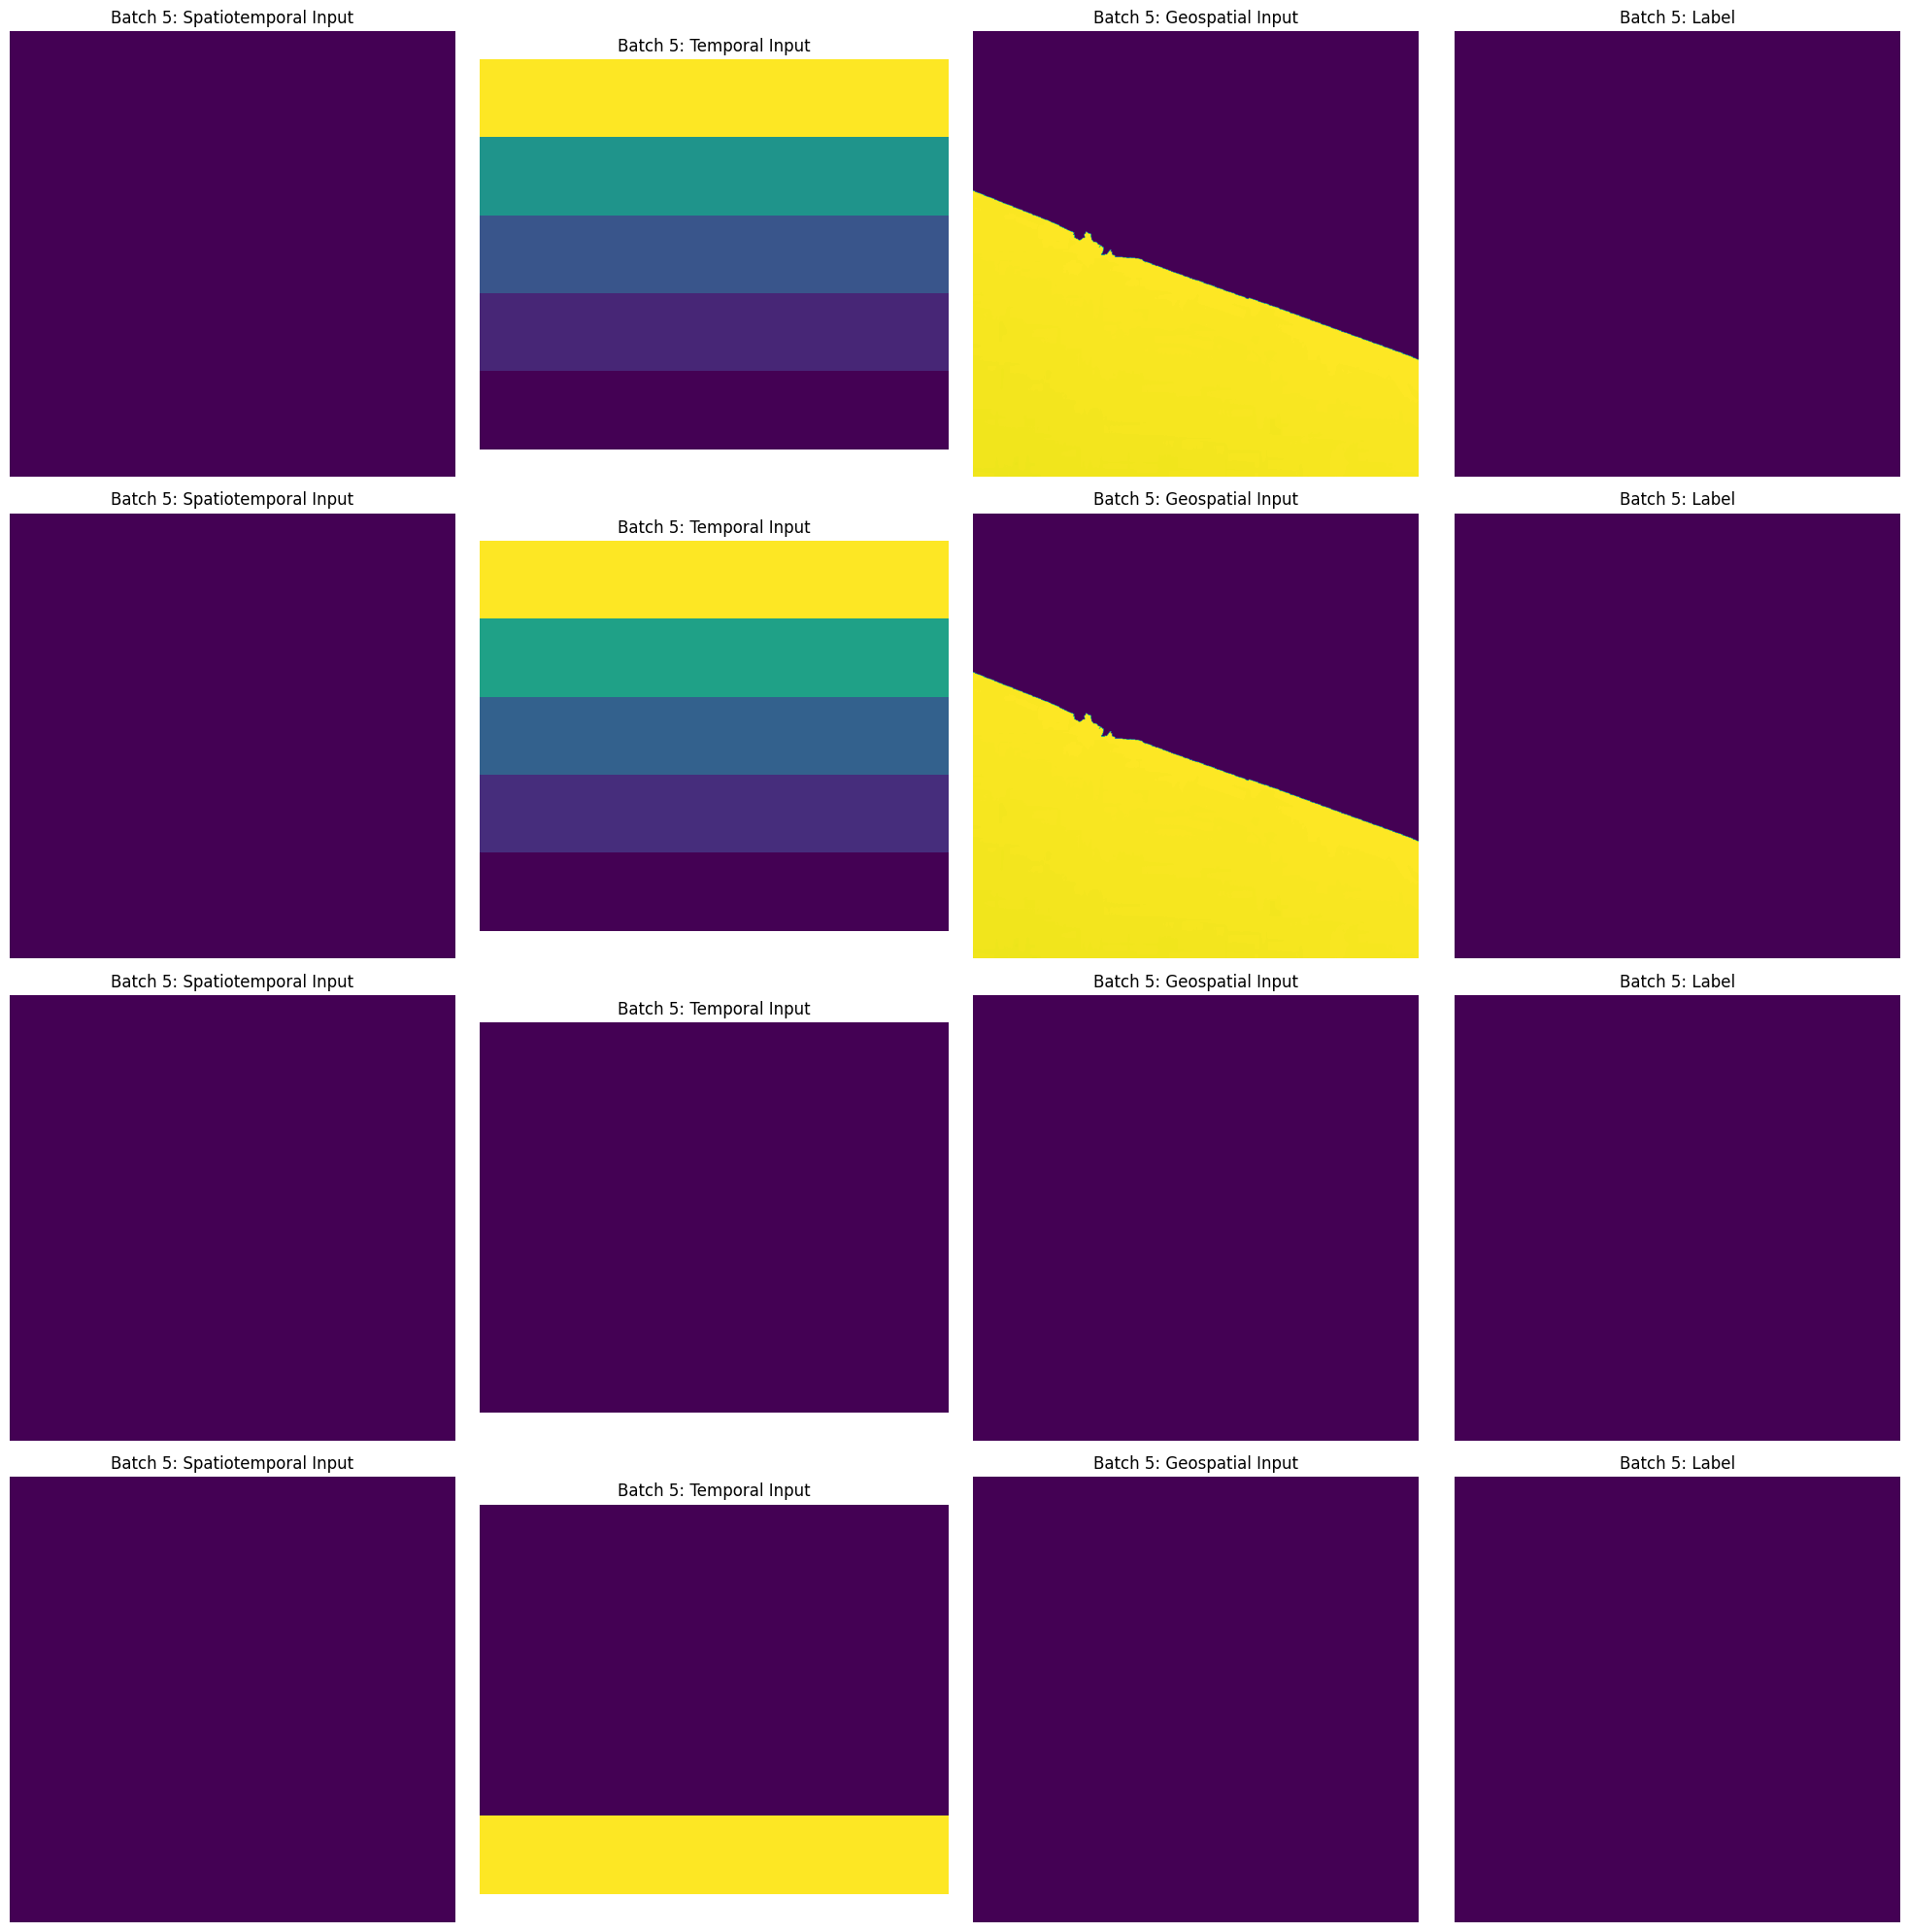

Visualizing Batch 6/10


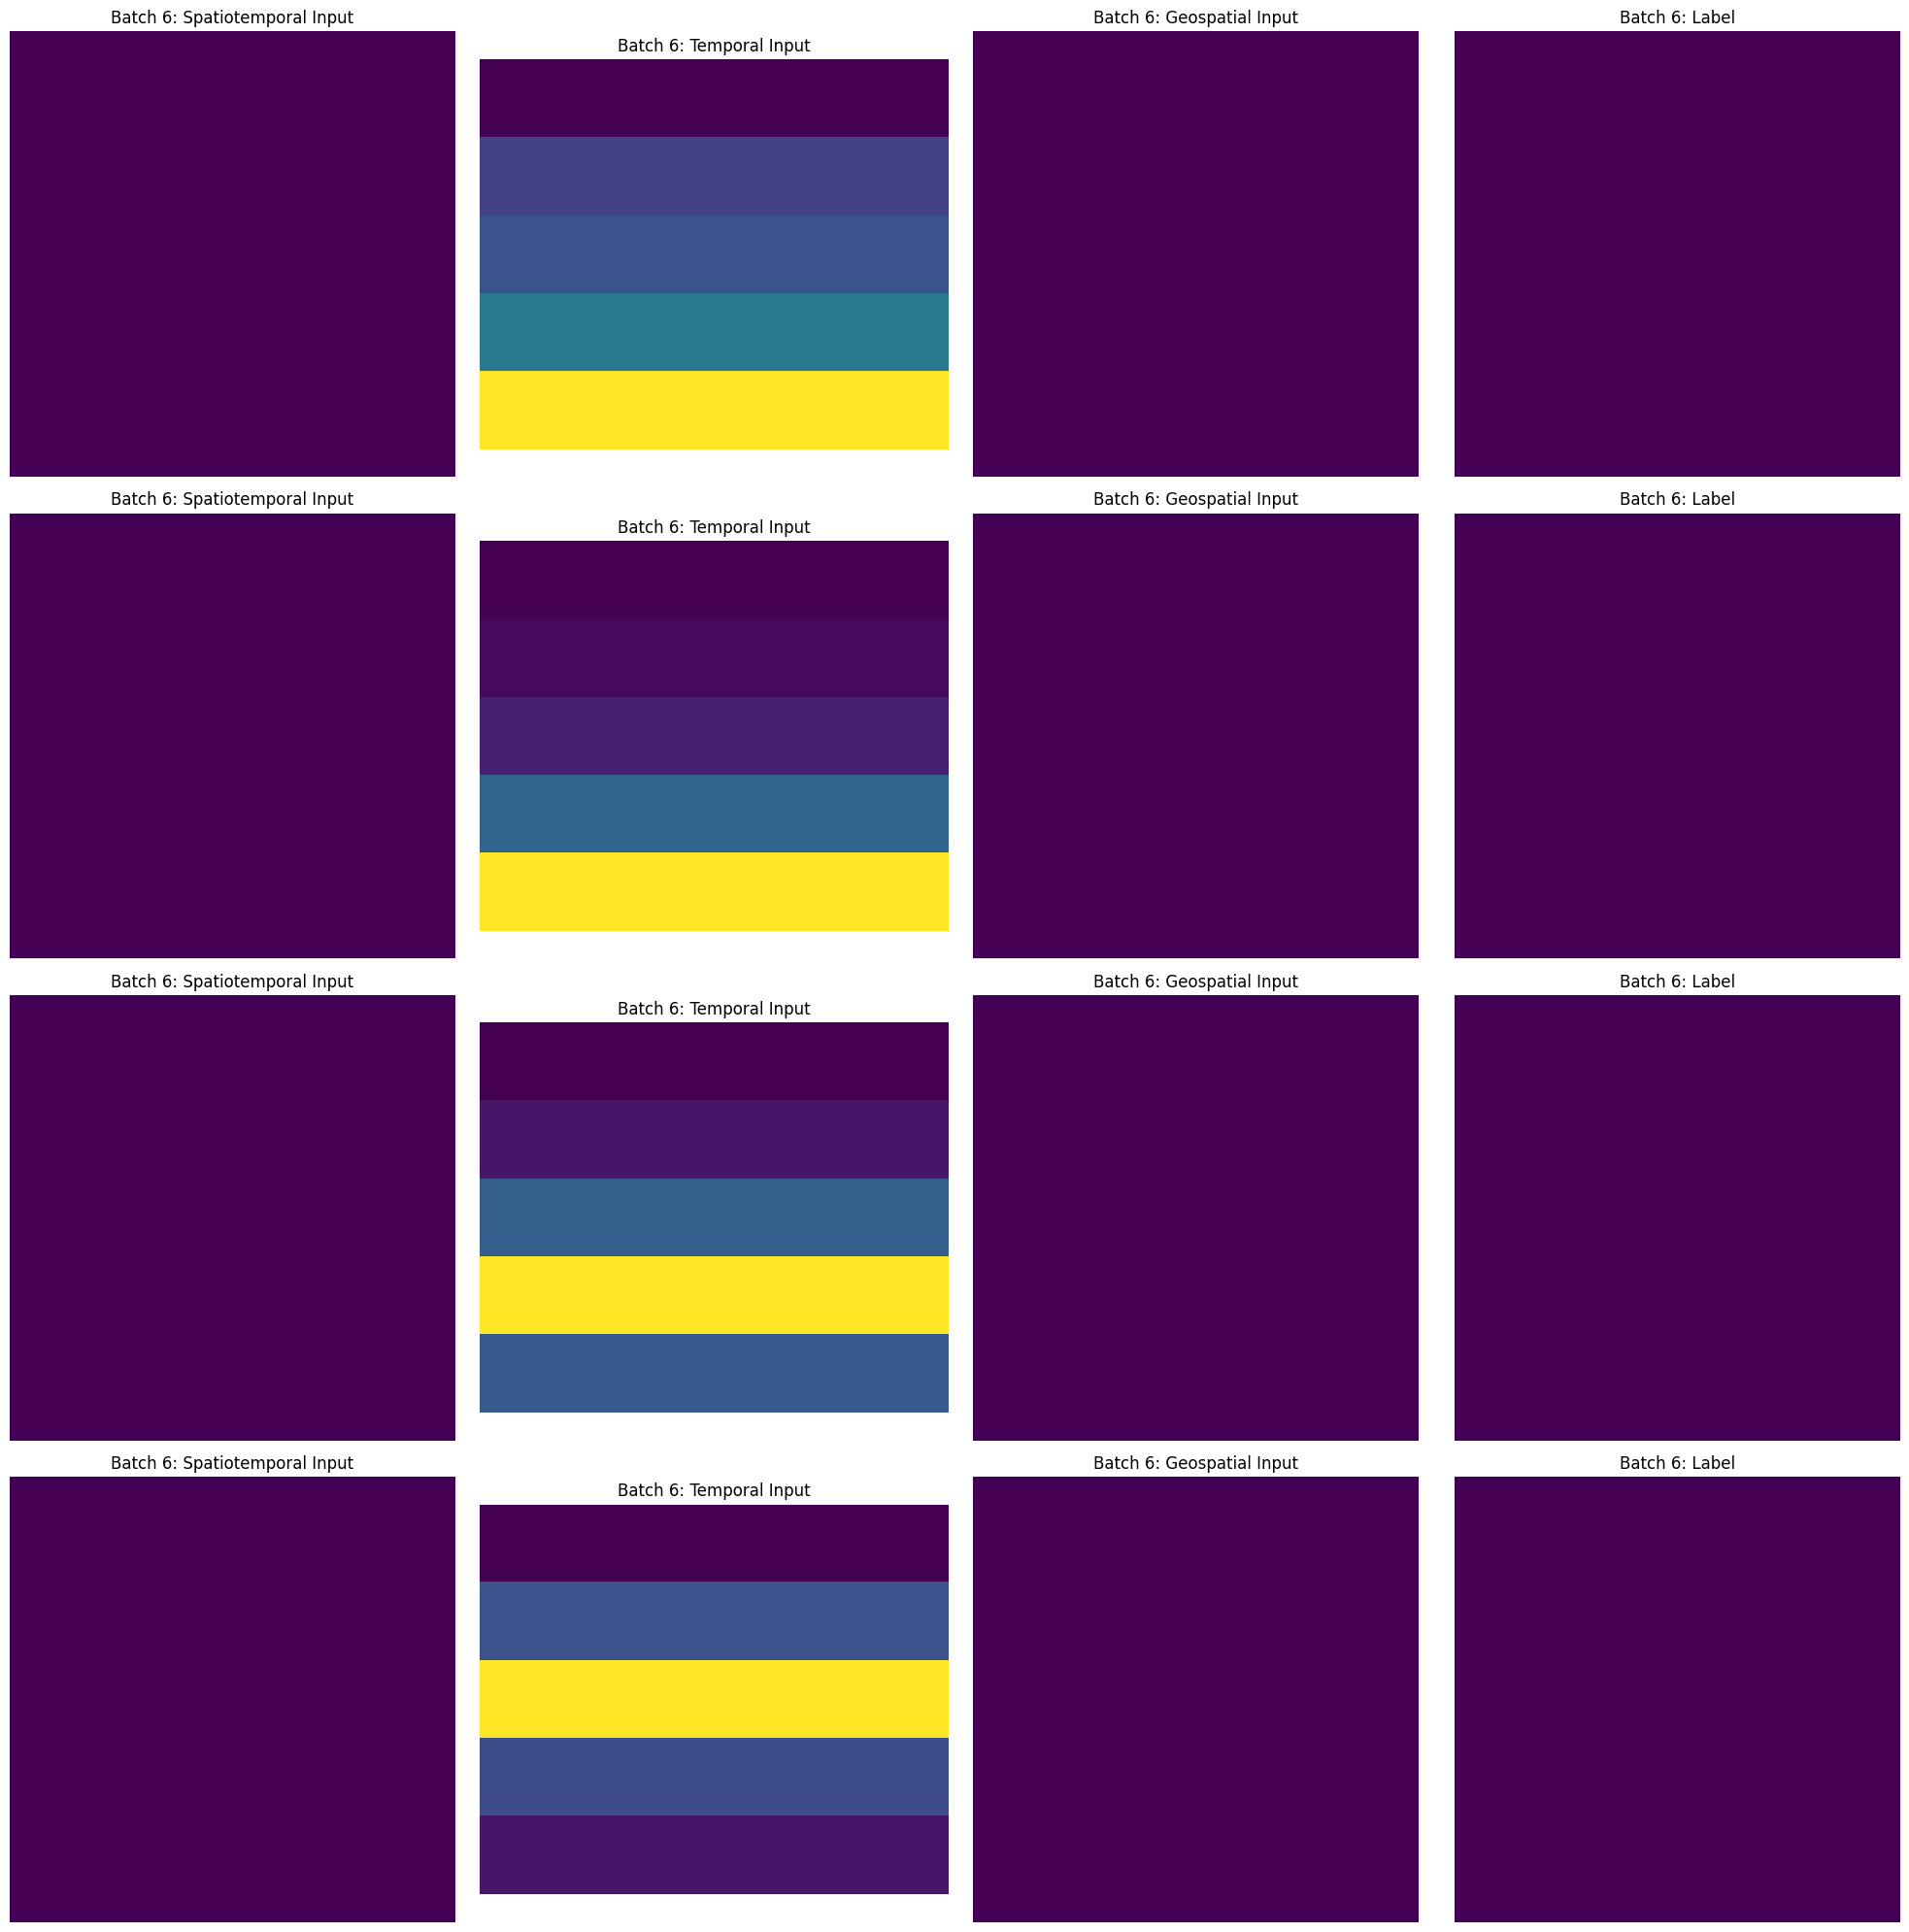

Visualizing Batch 7/10


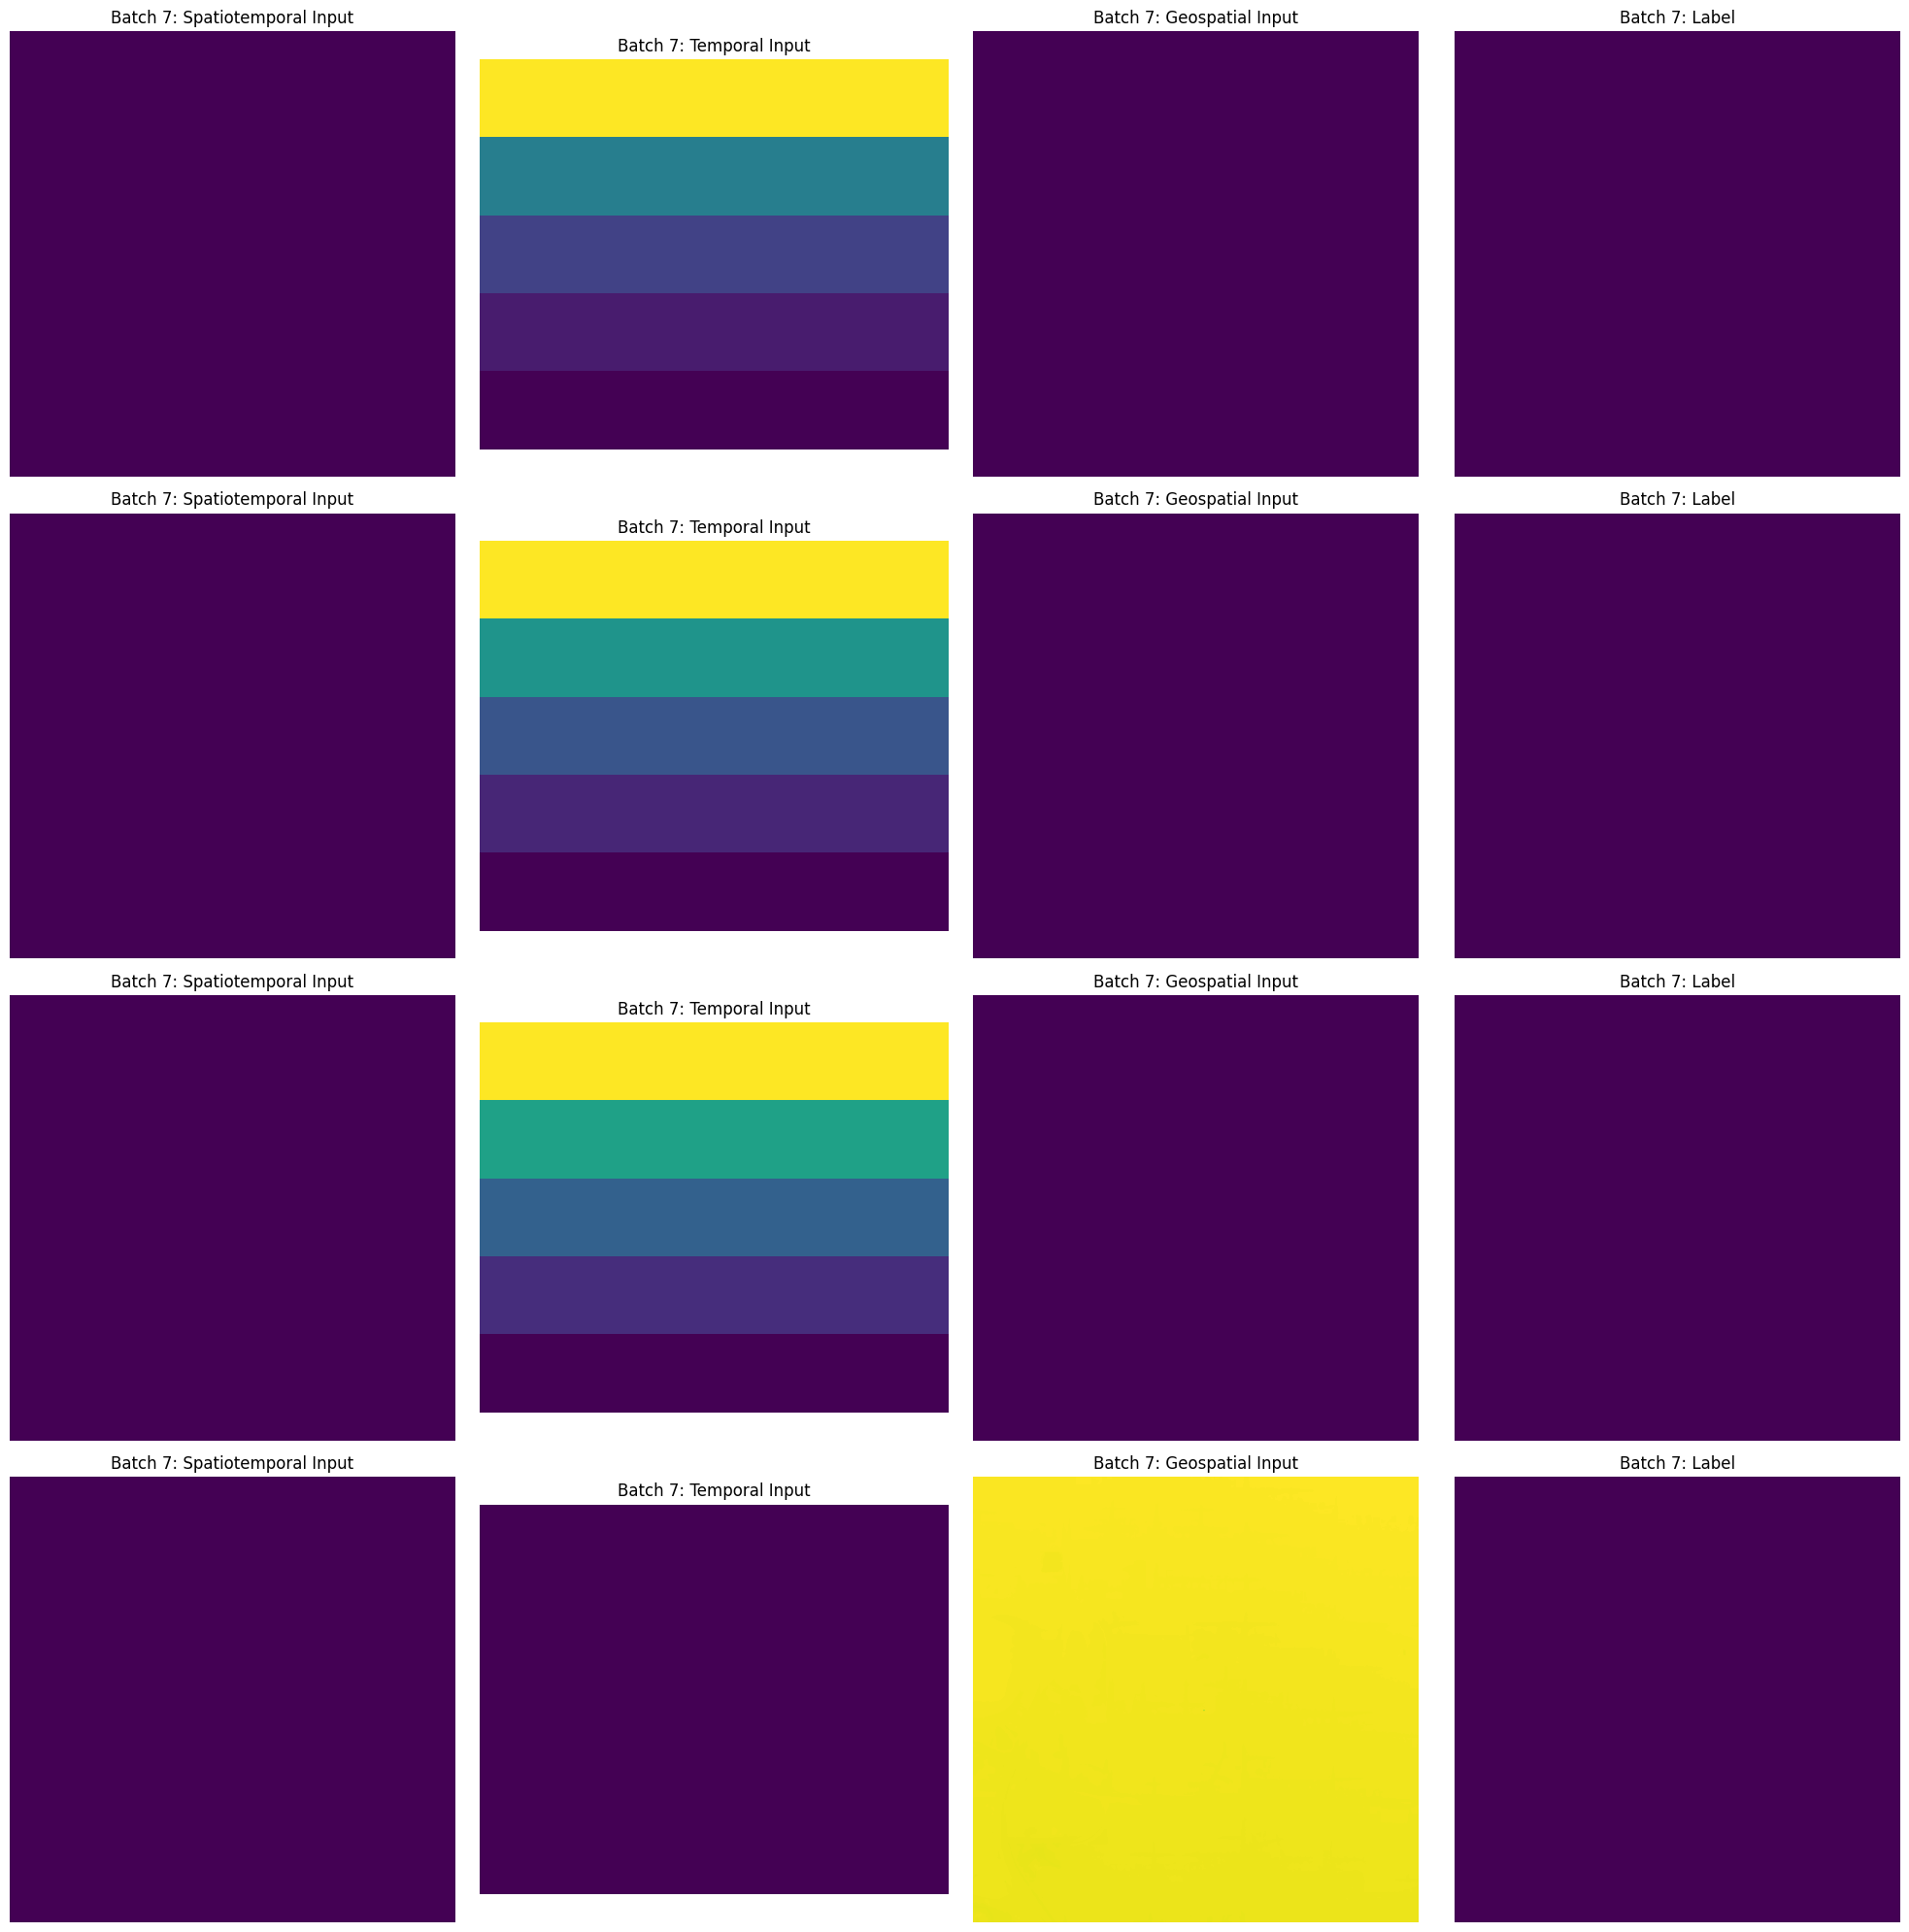

Visualizing Batch 8/10


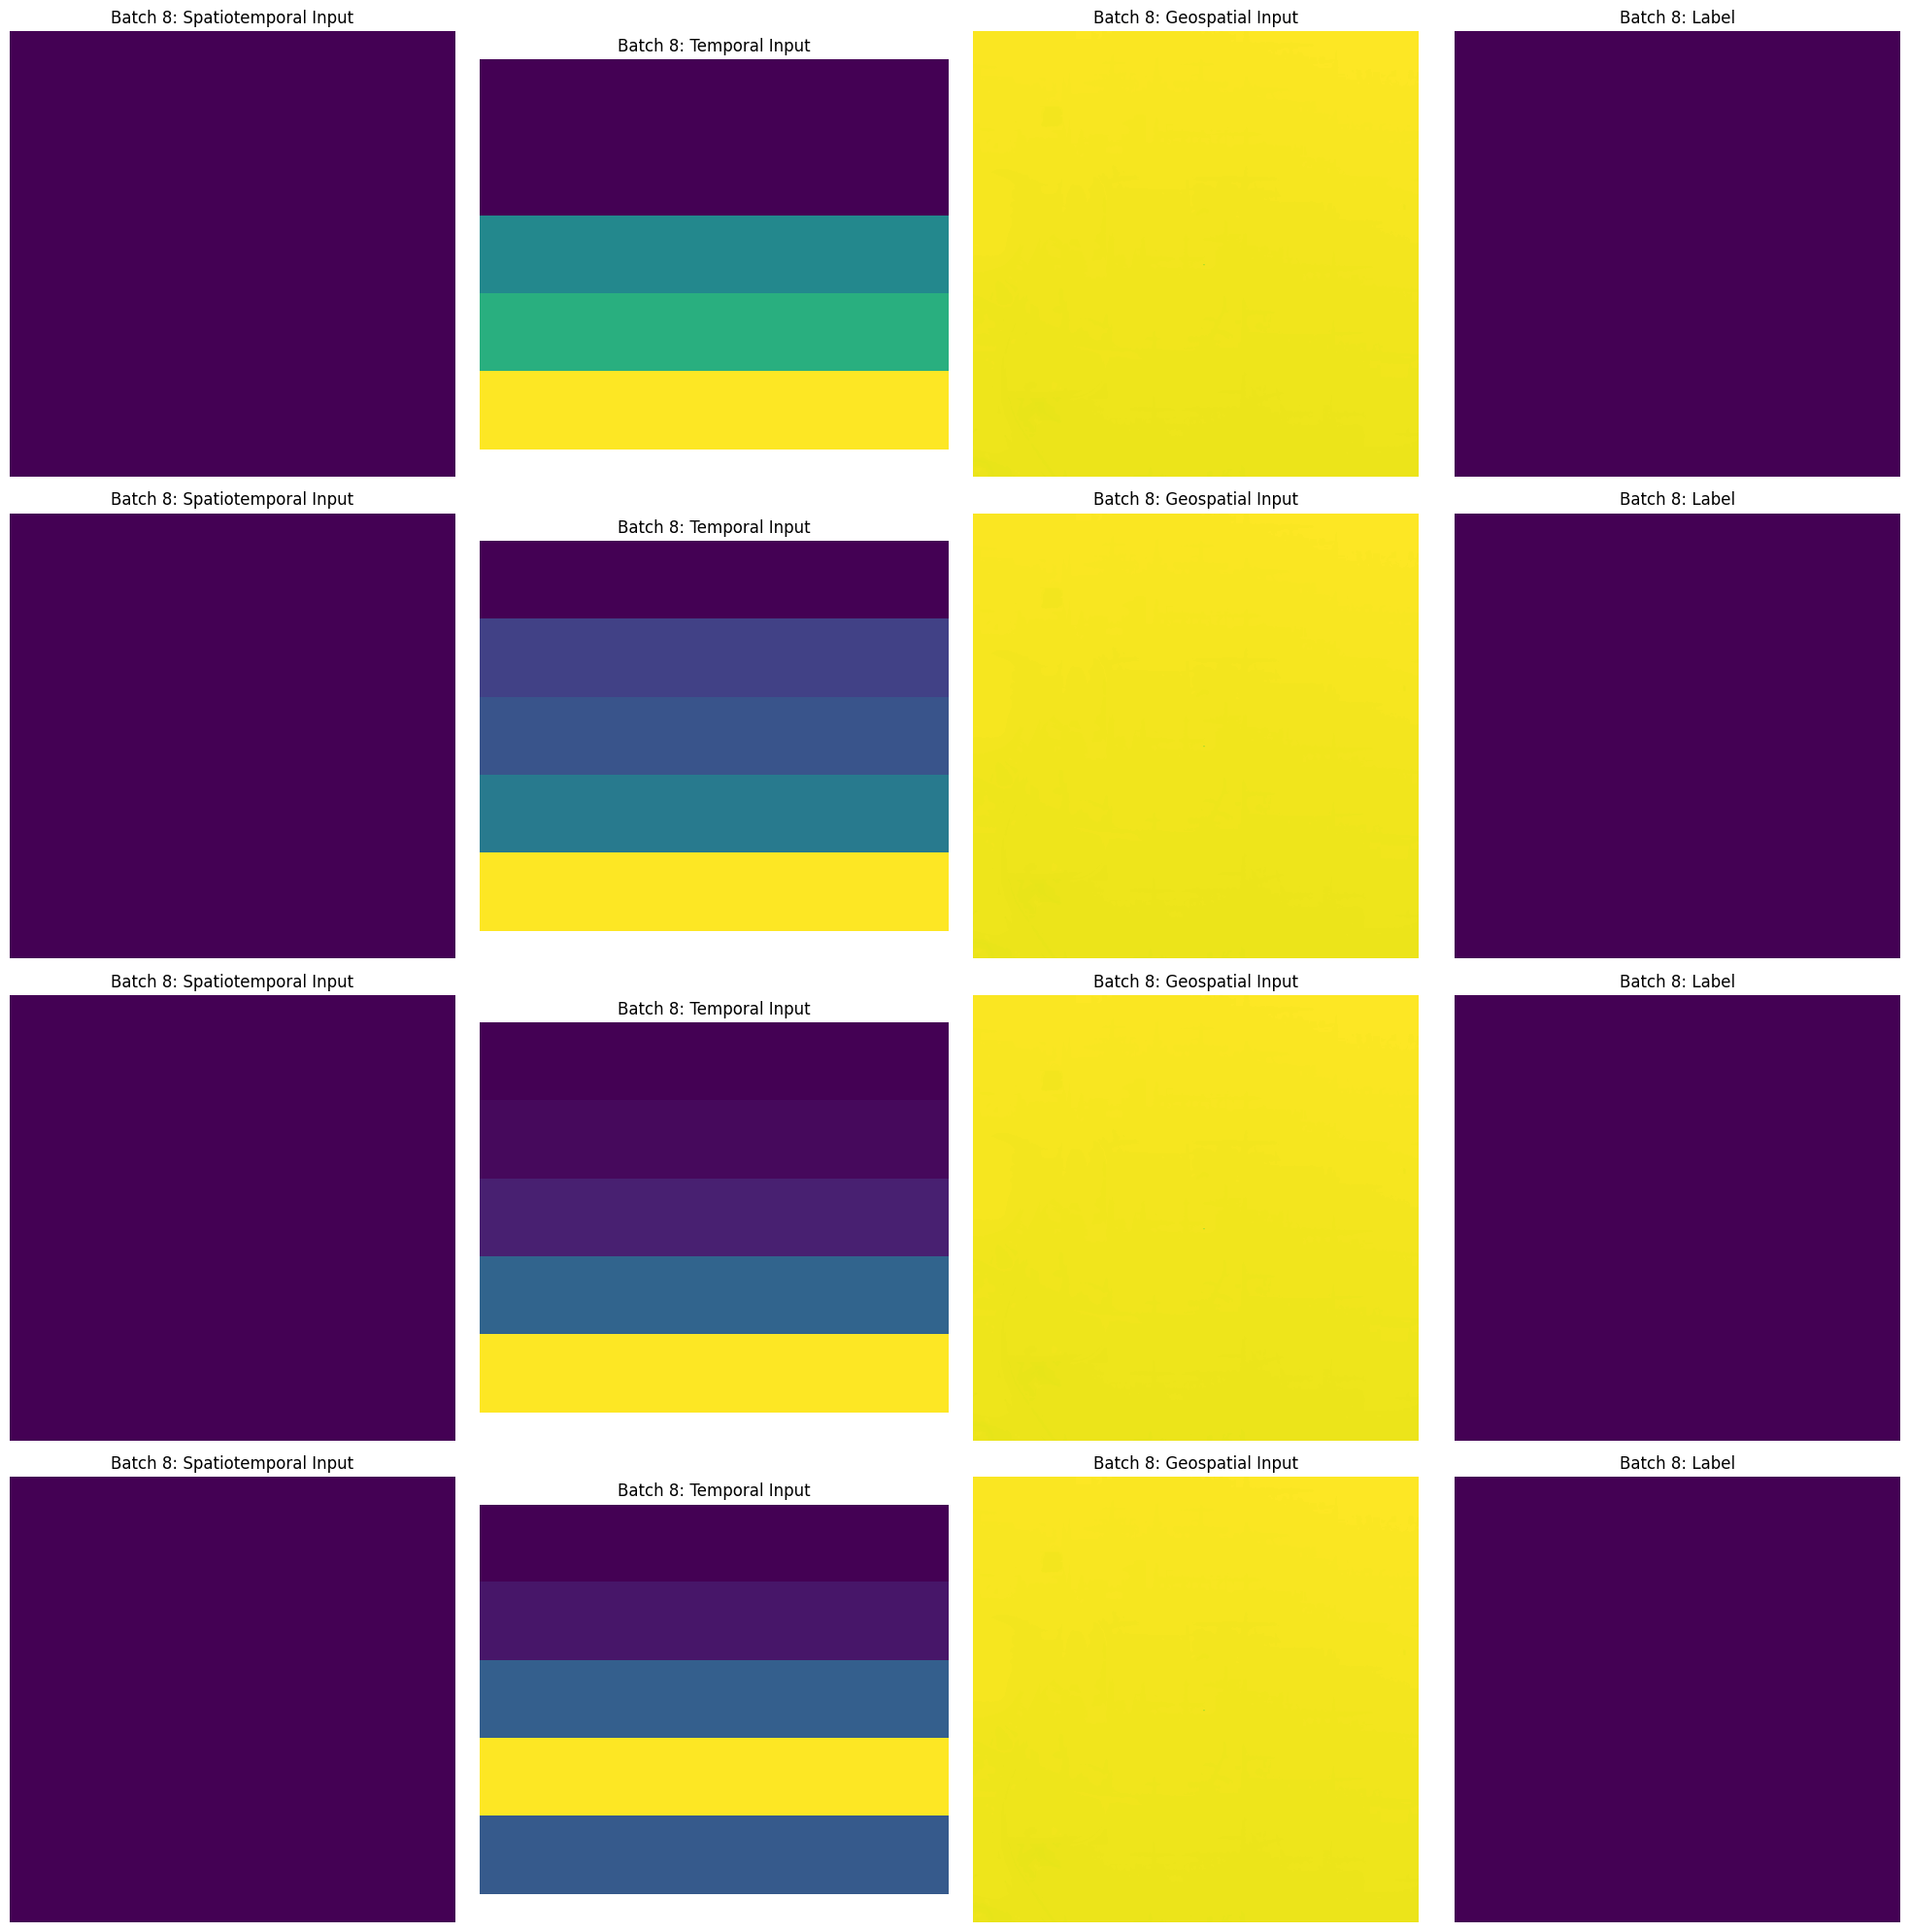

Visualizing Batch 9/10


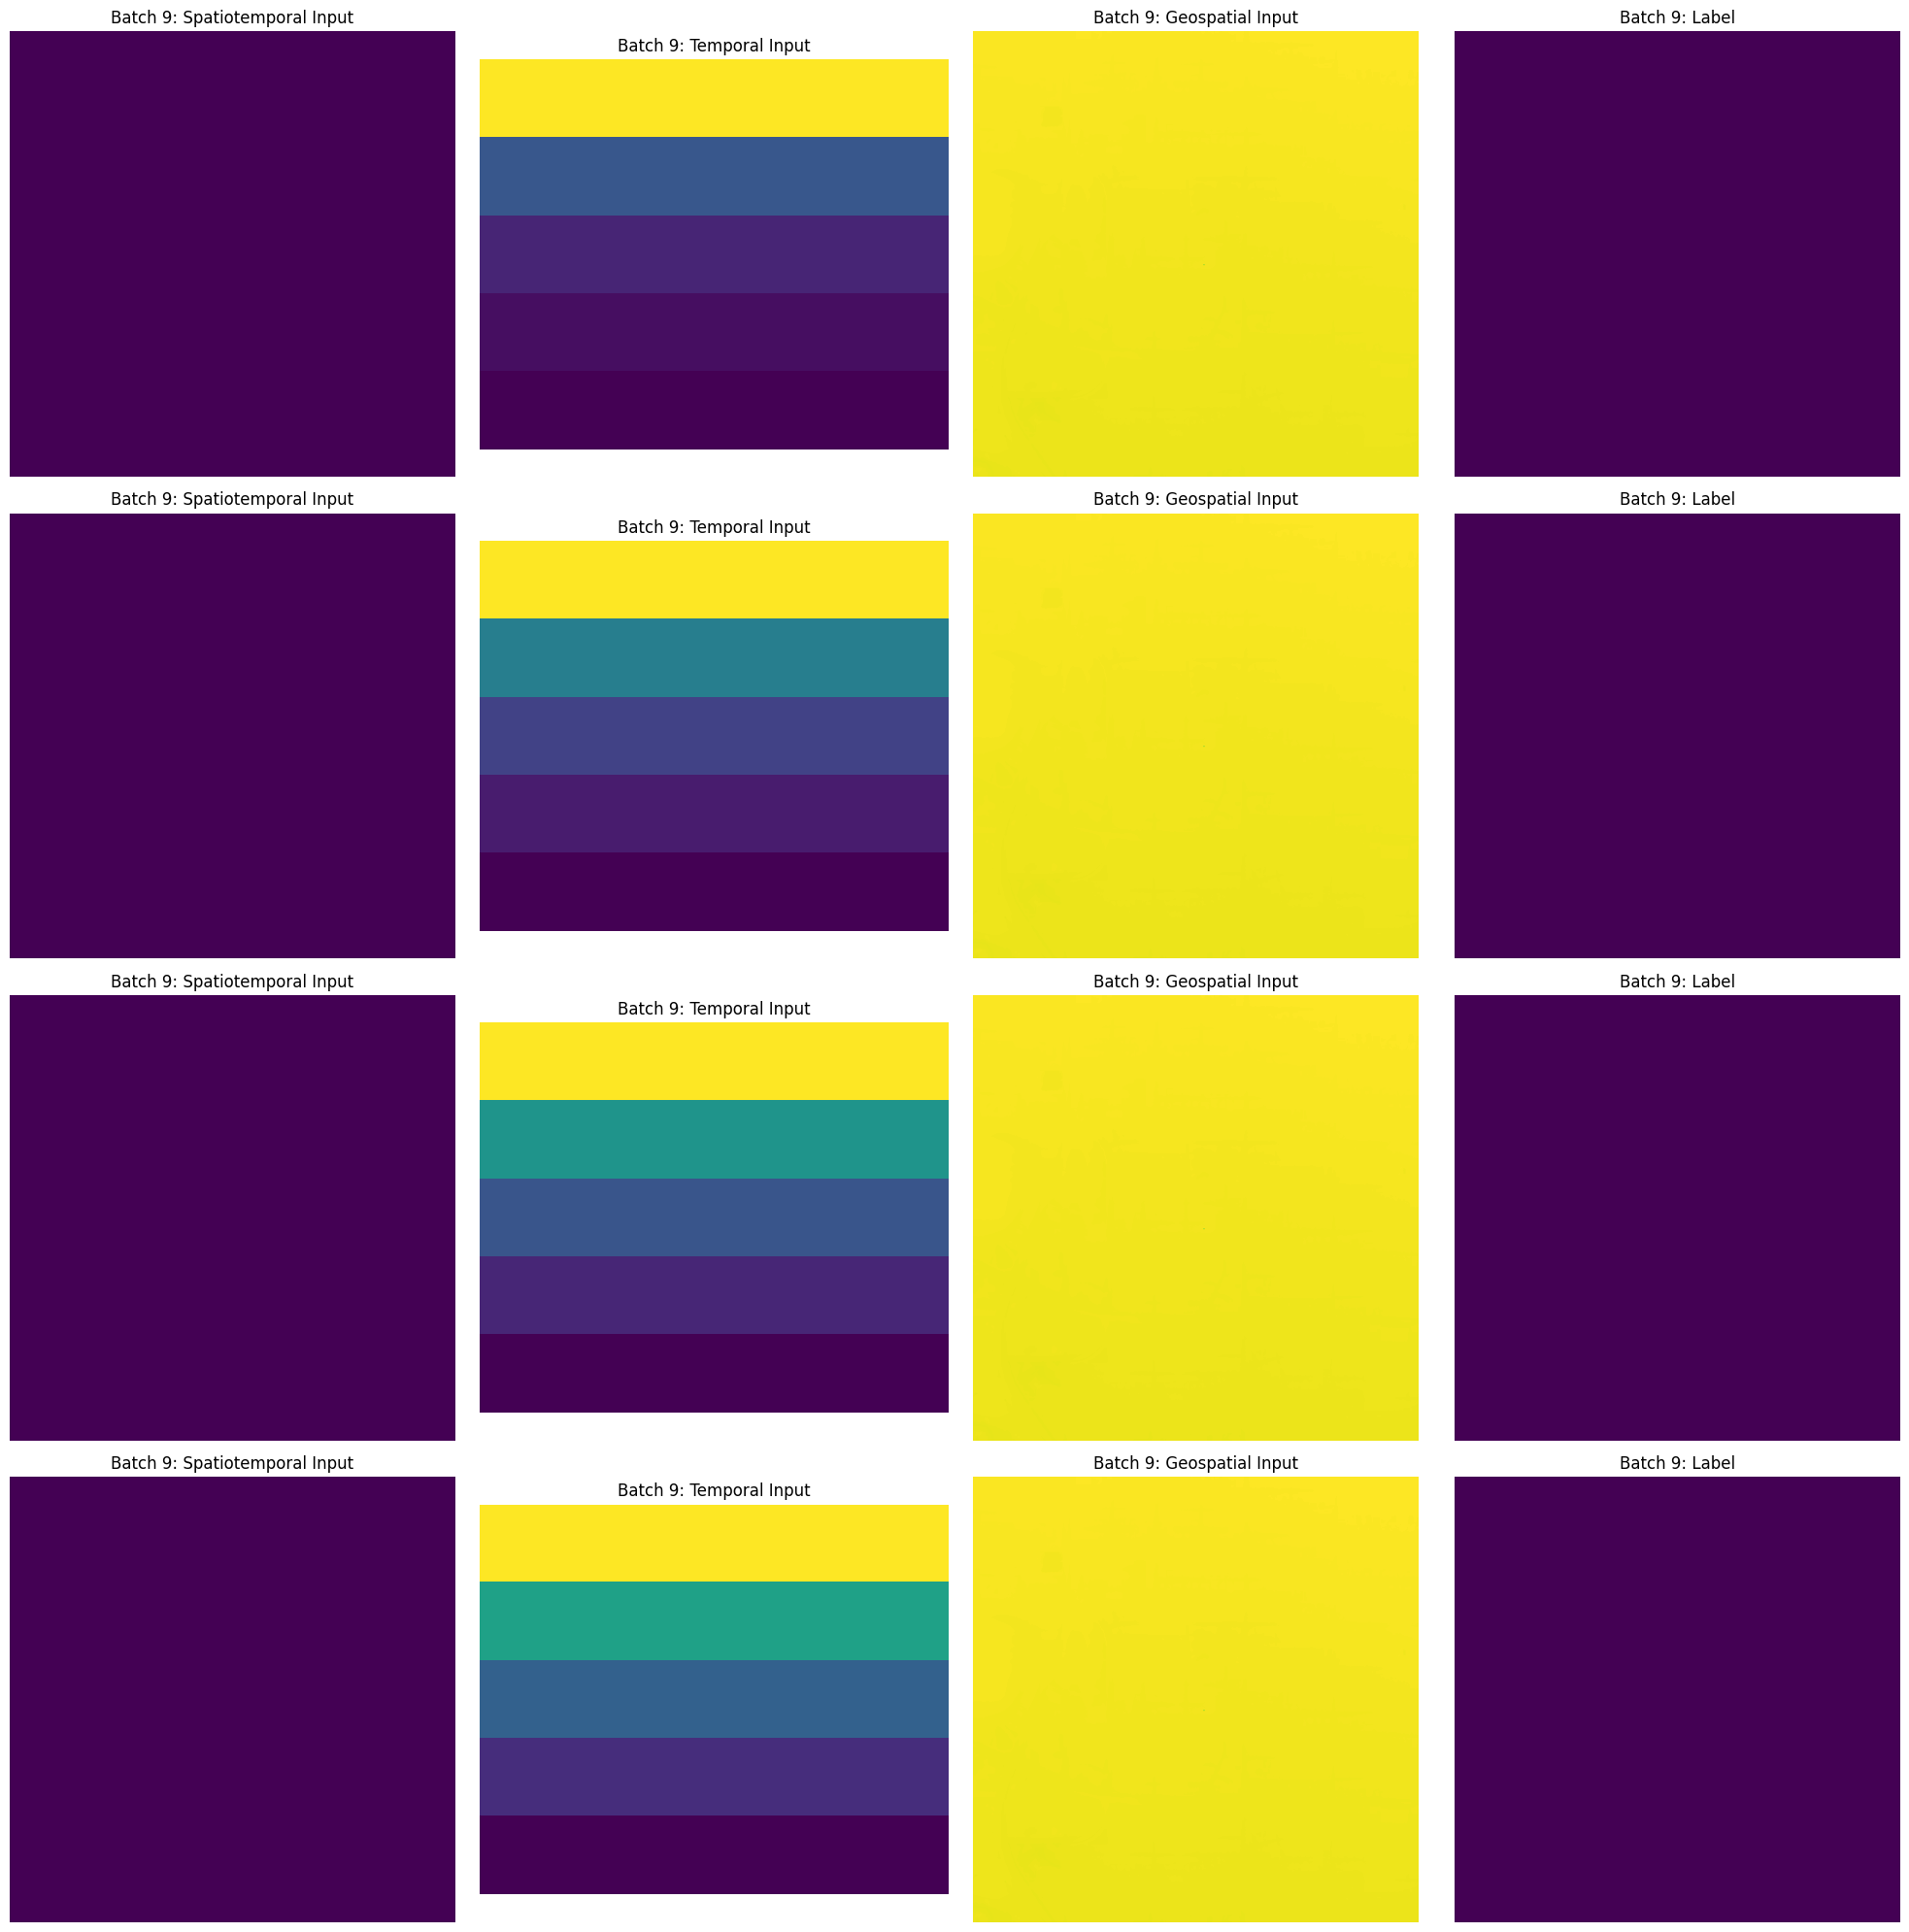

Visualizing Batch 10/10


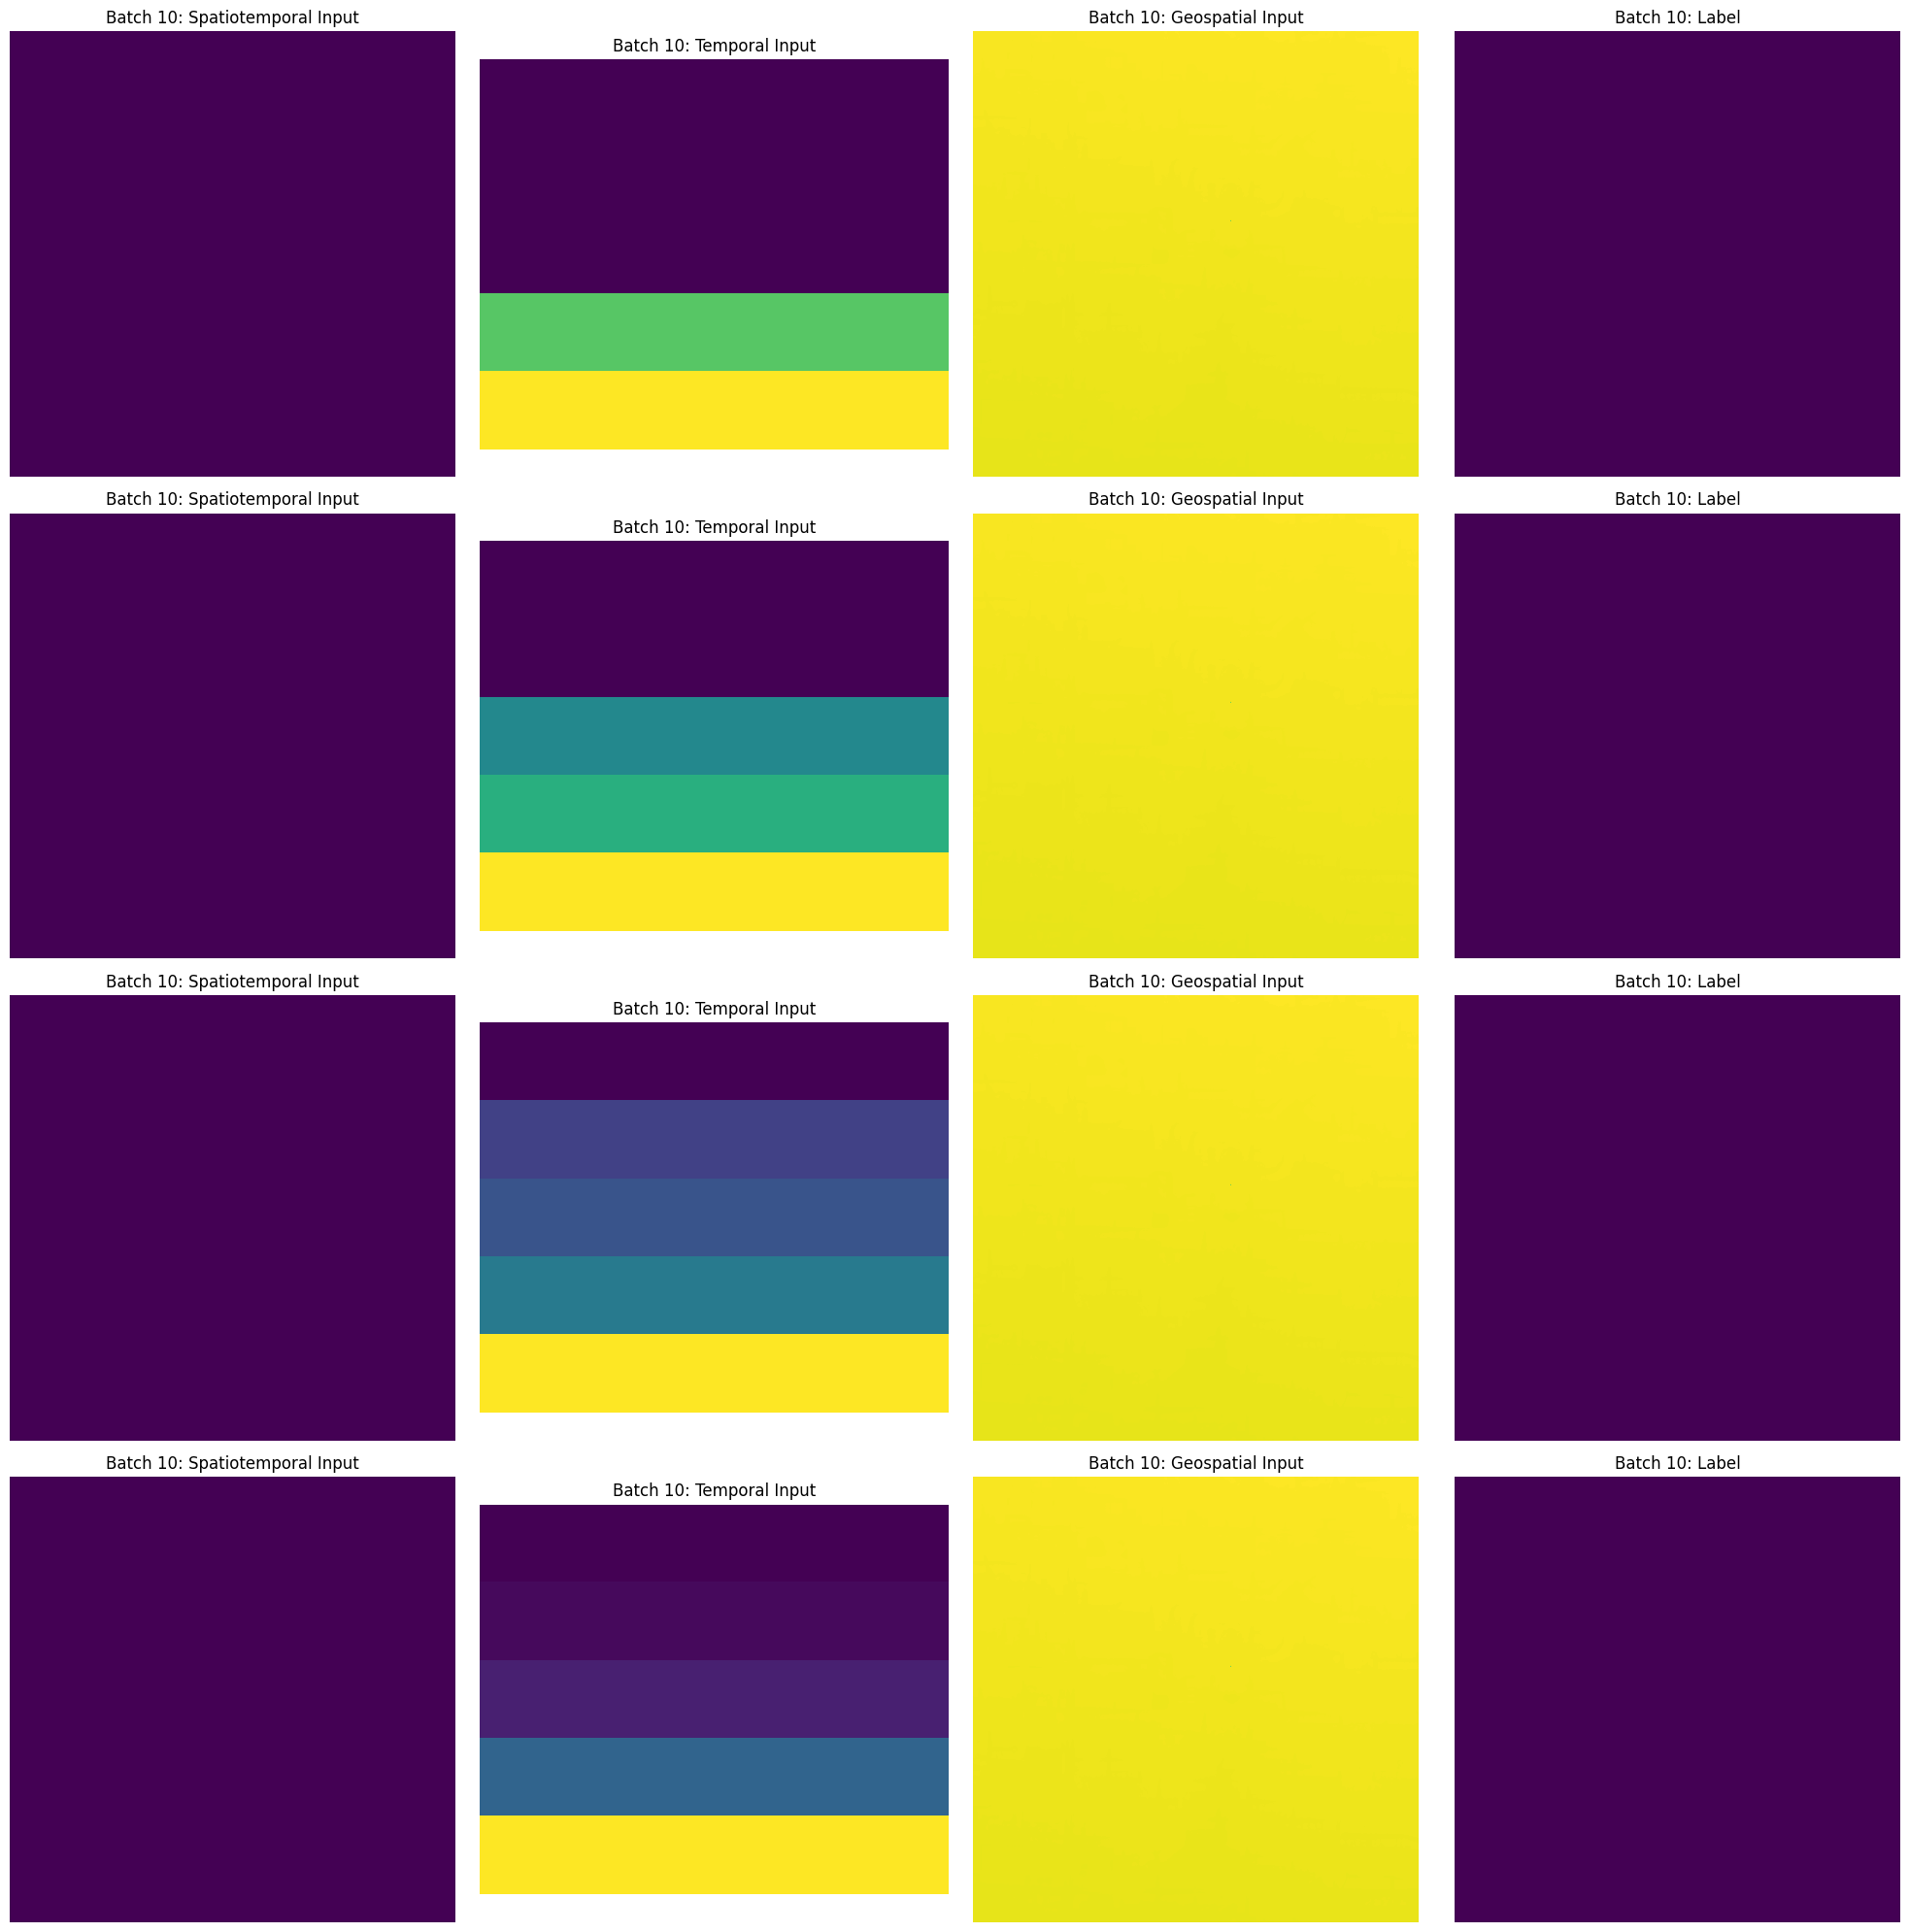

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Number of batches and samples to visualize per batch
num_batches = 10  # Adjust as needed
num_samples_per_batch = 4  # Adjust as needed

# Iterate through the dataset
for batch_idx, (inputs, labels) in enumerate(dataset.take(num_batches)):
    batch_size = labels.shape[0]
    num_to_show = min(num_samples_per_batch, batch_size)  # Limit samples to batch size

    print(f"Visualizing Batch {batch_idx + 1}/{num_batches}")

    # Create a figure for this batch
    fig, axes = plt.subplots(num_to_show, 4, figsize=(20, 5 * num_to_show))
    axes = np.atleast_2d(axes)  # Ensure consistent indexing for single-row cases

    for i in range(num_to_show):
        # Spatiotemporal input
        axes[i, 0].imshow(inputs['spatiotemporal'][i, 0, :, :, 0], cmap="viridis")
        axes[i, 0].set_title(f"Batch {batch_idx + 1}: Spatiotemporal Input")
        axes[i, 0].axis('off')

        # Temporal input
        axes[i, 1].imshow(inputs['temporal'][i, :, :], cmap="viridis")
        axes[i, 1].set_title(f"Batch {batch_idx + 1}: Temporal Input")
        axes[i, 1].axis('off')

        # Geospatial input
        axes[i, 2].imshow(inputs['geospatial'][i, :, :, 0], cmap="viridis")
        axes[i, 2].set_title(f"Batch {batch_idx + 1}: Geospatial Input")
        axes[i, 2].axis('off')

        # Label
        axes[i, 3].imshow(labels[i, :, :], cmap="viridis")
        axes[i, 3].set_title(f"Batch {batch_idx + 1}: Label")
        axes[i, 3].axis('off')

    # Adjust layout for this batch
    plt.tight_layout()
    plt.show()


In [17]:
import os, time, keras
# Create a unique log directory by appending the current timestamp
log_dir = os.path.join("./logs", "run_" + time.strftime("%Y%m%d-%H%M%S"))

# Set up TensorBoard callback
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
print(log_dir)

./logs/run_20250113-205059


In [18]:
model = FloodModel(FloodModelParams())
model.fit(dataset, epochs=50,  callbacks=[tb_callback])

Epoch 1/50


2025-01-13 20:51:04.960463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inflood_conv_lstm/conv_lstm/conv_lstm2d/while/body/_1/flood_conv_lstm/conv_lstm/conv_lstm2d/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-13 20:51:07.410931: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900


     55/Unknown - 76s 970ms/step - loss: 7.4226e-07 - mean_absolute_error: 5.6759e-05 - root_mean_squared_error: 8.6154e-04

2025-01-13 20:52:17.713262: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14443374523581380483
2025-01-13 20:52:17.713318: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14092302752165922797


55/55 [==============================] - 76s 978ms/step - loss: 7.4226e-07 - mean_absolute_error: 5.6759e-05 - root_mean_squared_error: 8.6154e-04
Epoch 2/50
55/55 [==============================] - 49s 877ms/step - loss: 5.8556e-09 - mean_absolute_error: 1.7438e-07 - root_mean_squared_error: 7.6522e-05
Epoch 3/50
55/55 [==============================] - 48s 848ms/step - loss: 5.8561e-09 - mean_absolute_error: 1.7453e-07 - root_mean_squared_error: 7.6525e-05
Epoch 4/50
55/55 [==============================] - 48s 843ms/step - loss: 5.8559e-09 - mean_absolute_error: 1.7438e-07 - root_mean_squared_error: 7.6524e-05
Epoch 5/50
55/55 [==============================] - 45s 795ms/step - loss: 5.8554e-09 - mean_absolute_error: 1.7427e-07 - root_mean_squared_error: 7.6520e-05
Epoch 6/50
55/55 [==============================] - 43s 768ms/step - loss: 5.8545e-09 - mean_absolute_error: 1.7409e-07 - root_mean_squared_error: 7.6515e-05
Epoch 7/50
55/55 [==============================] - 45s 790ms/s

Ground Truth Shape: (6, 1000, 1000)
Input Data[geospatial] Shape: (6, 1000, 1000, 8)
Input Data[temporal] Shape: (6, 5, 6)
Input Data[spatiotemporal] Shape: (6, 5, 1000, 1000, 1)
1/1 [==============================] - 0s 144ms/step
Predicted Labels Shape: (6, 1000, 1000, 1)


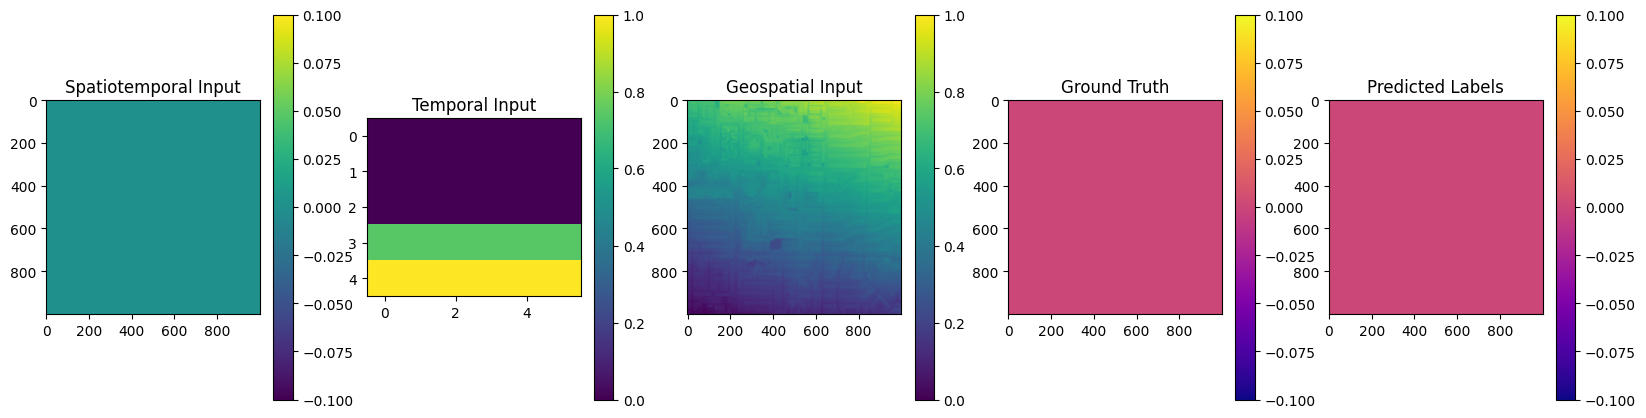

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def normalize(image_tensor):
    """
    Normalize a TensorFlow tensor to the range [0, 1].
    """
    image_tensor = tf.cast(image_tensor, tf.float32)
    min_val = tf.reduce_min(image_tensor)
    max_val = tf.reduce_max(image_tensor)
    image_tensor = image_tensor - min_val
    if max_val > min_val:
        image_tensor = image_tensor / (max_val - min_val)
    return image_tensor

# Example loop to visualize
for input_data, ground_truth in dataset.take(100):
    print("Ground Truth Shape:", ground_truth.shape)
    for k, v in input_data.items():
        print(f"Input Data[{k}] Shape: {v.shape}")

    # Get predicted labels
    # Get predicted labels (without the 'training' argument)
    predicted_labels = model._model.predict(input_data)

    print("Predicted Labels Shape:", predicted_labels.shape)

    # Choose a sample to visualize
    sample_index = 2

    # Normalize and prepare inputs for visualization
    spatiotemporal_sample = normalize(input_data['spatiotemporal'][sample_index, 0, :, :, 0])
    temporal_sample = normalize(input_data['temporal'][sample_index, :, :])
    geospatial_sample = normalize(input_data['geospatial'][sample_index, :, :, 0])

    # Normalize and prepare labels and predictions
    gt_sample = normalize(tf.squeeze(ground_truth[sample_index]))
    pred_sample = normalize(predicted_labels[sample_index, :, :, 0])

    # Convert to NumPy for plotting
    spatiotemporal_np = spatiotemporal_sample.numpy()
    temporal_np = temporal_sample.numpy()
    geospatial_np = geospatial_sample.numpy()
    gt_sample_np = gt_sample.numpy()
    pred_sample_np = pred_sample.numpy()

    # Plot all samples
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    im0 = axes[0].imshow(spatiotemporal_np, cmap='viridis')
    axes[0].set_title("Spatiotemporal Input")
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(temporal_np, cmap='viridis')
    axes[1].set_title("Temporal Input")
    fig.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(geospatial_np, cmap='viridis')
    axes[2].set_title("Geospatial Input")
    fig.colorbar(im2, ax=axes[2])

    im3 = axes[3].imshow(gt_sample_np, cmap='plasma')
    axes[3].set_title("Ground Truth")
    fig.colorbar(im3, ax=axes[3])

    im4 = axes[4].imshow(pred_sample_np, cmap='plasma')
    axes[4].set_title("Predicted Labels")
    fig.colorbar(im4, ax=axes[4])

    plt.show()
    break  # Only visualize the first batch


In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def normalize(image_tensor):
    """
    Normalize a TensorFlow tensor to the range [0, 1].
    """
    image_tensor = tf.cast(image_tensor, tf.float32)
    min_val = tf.reduce_min(image_tensor)
    max_val = tf.reduce_max(image_tensor)
    image_tensor = image_tensor - min_val
    if max_val > min_val:
        image_tensor = image_tensor / (max_val - min_val)
    return image_tensor

# Initialize lists for evaluation
all_ground_truth = []
all_predictions = []

# Iterate through the dataset
for input_data, ground_truth in dataset:
    # Get predicted labels
    predicted_labels = model._model.predict(input_data)

    # Append ground truth and predictions to lists
    all_ground_truth.append(ground_truth.numpy())
    all_predictions.append(predicted_labels)

# Convert lists to NumPy arrays
all_ground_truth = np.concatenate(all_ground_truth, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

# Reshape for evaluation
gt_flat = all_ground_truth.flatten()
pred_flat = all_predictions.flatten()

# Calculate metrics
mse = mean_squared_error(gt_flat, pred_flat)
mae = mean_absolute_error(gt_flat, pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(gt_flat, pred_flat)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² (Coefficient of Determination): {r2:.4f}")

1/1 [==============================] - 0s 392ms/step
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0000
Root Mean Squared Error (RMSE): 0.0001
R² (Coefficient of Determination): -0.0000


Visualizing Batch 1/10
Ground Truth Shape: (6, 1000, 1000)
Input Data[geospatial] Shape: (6, 1000, 1000, 8)
Input Data[temporal] Shape: (6, 5, 6)
Input Data[spatiotemporal] Shape: (6, 5, 1000, 1000, 1)
1/1 [==============================] - 0s 140ms/step
Predicted Labels Shape: (6, 1000, 1000, 1)


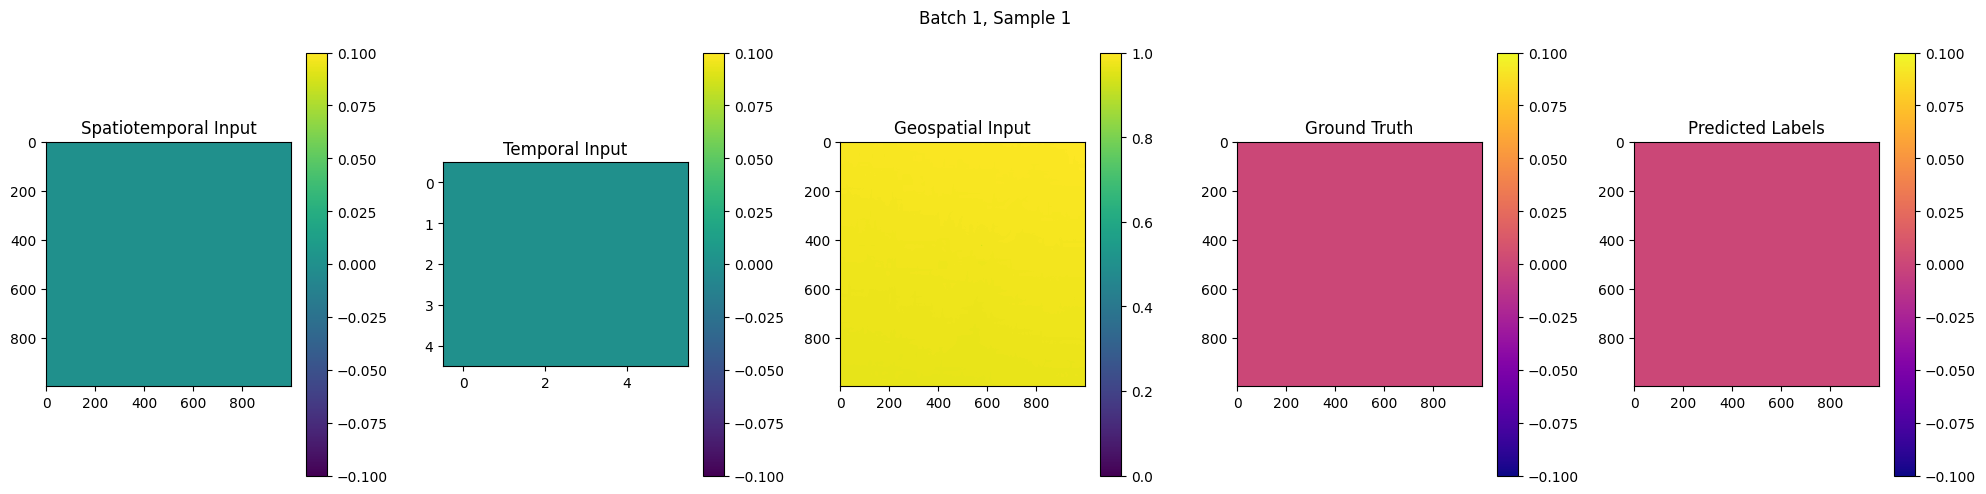

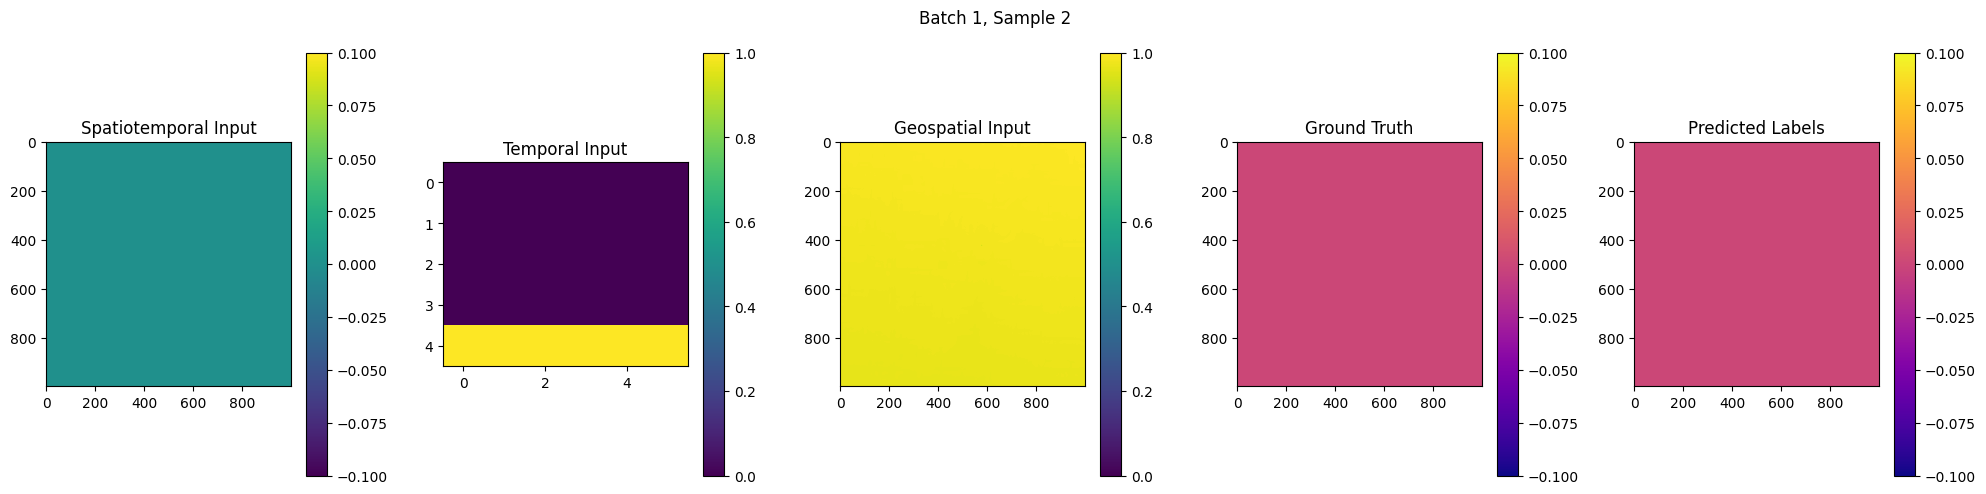

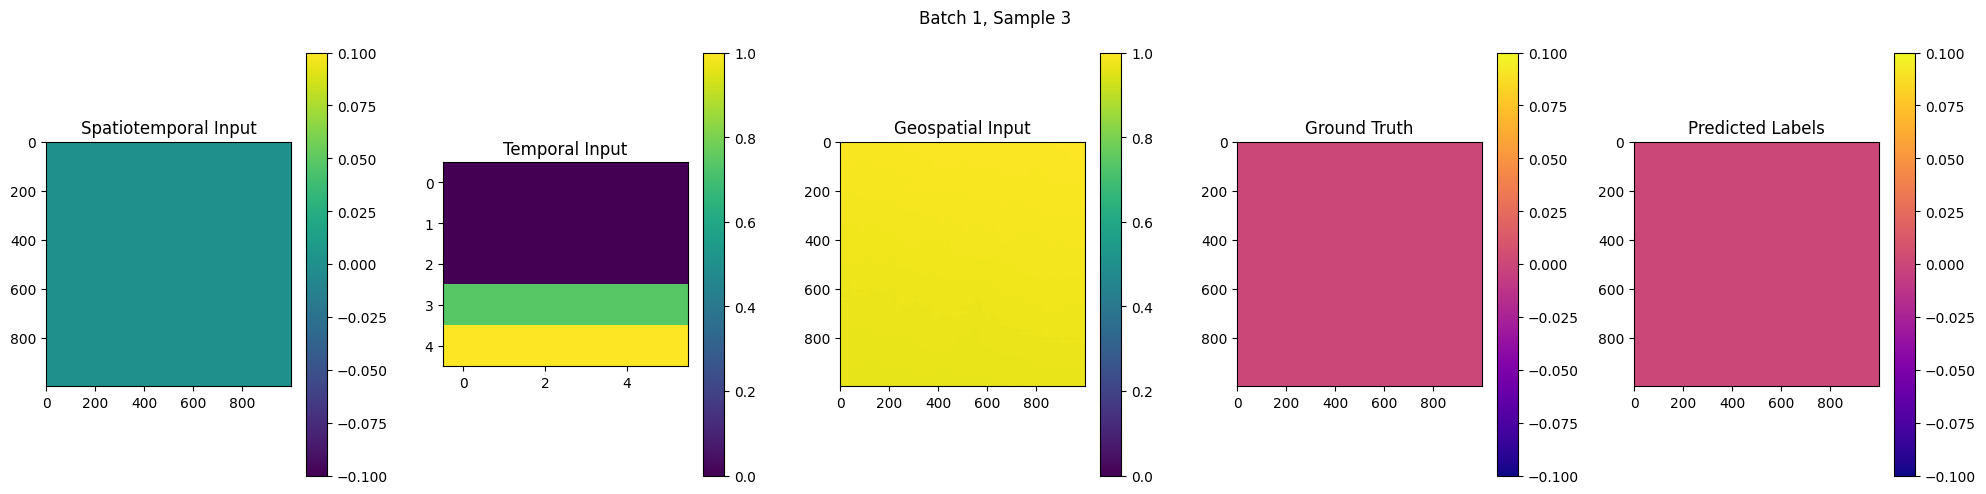

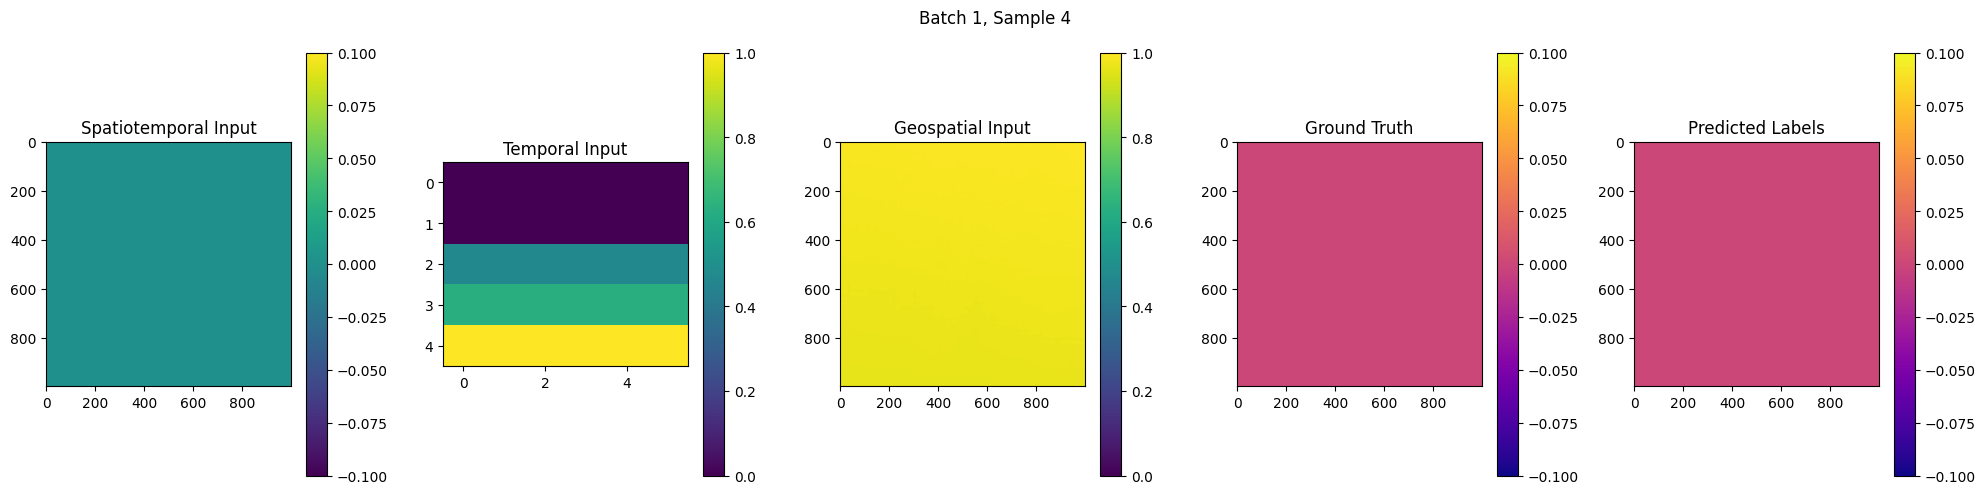

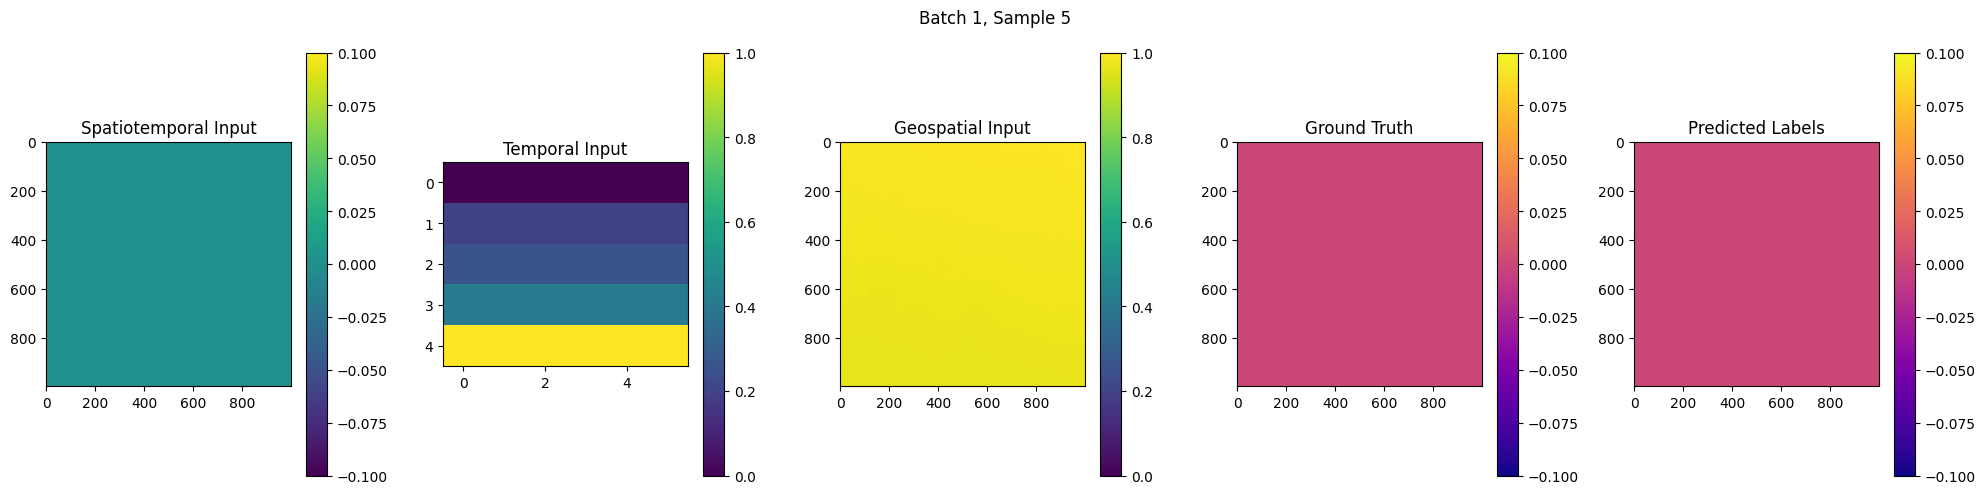

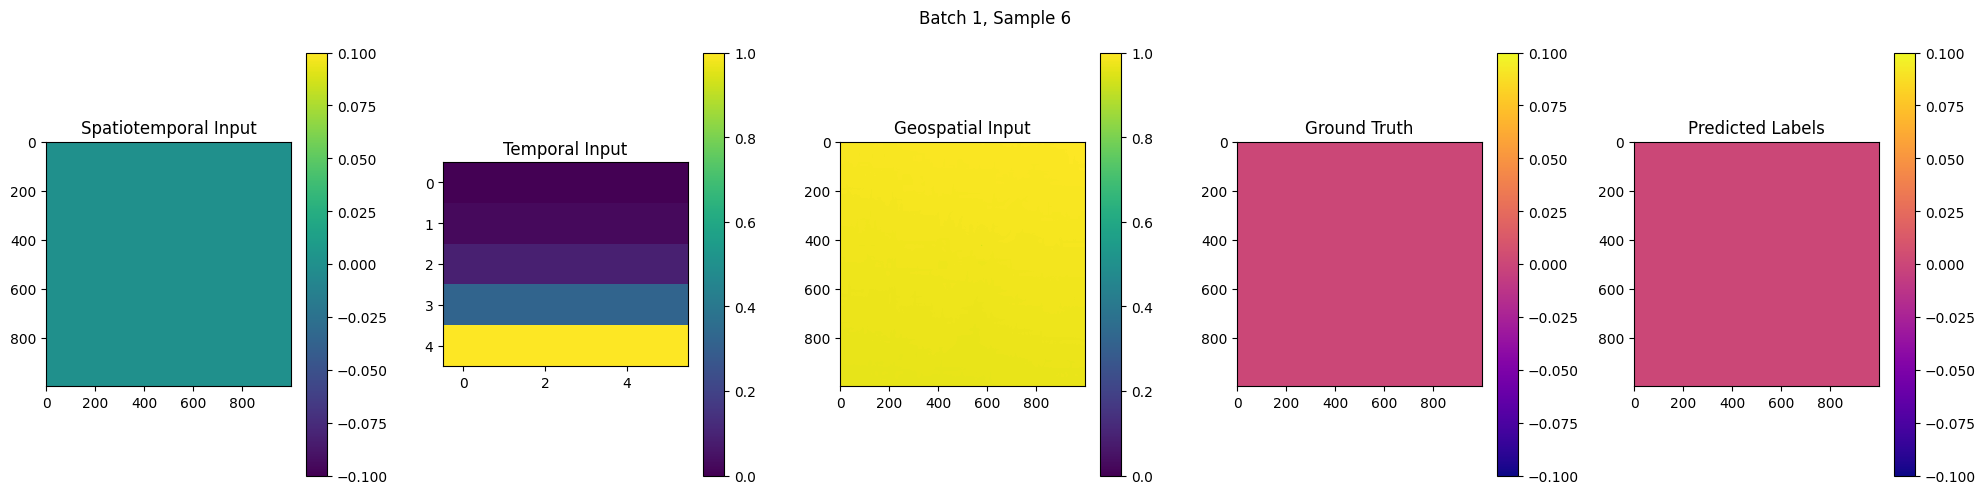

Visualizing Batch 2/10
Ground Truth Shape: (6, 1000, 1000)
Input Data[geospatial] Shape: (6, 1000, 1000, 8)
Input Data[temporal] Shape: (6, 5, 6)
Input Data[spatiotemporal] Shape: (6, 5, 1000, 1000, 1)
1/1 [==============================] - 0s 142ms/step
Predicted Labels Shape: (6, 1000, 1000, 1)


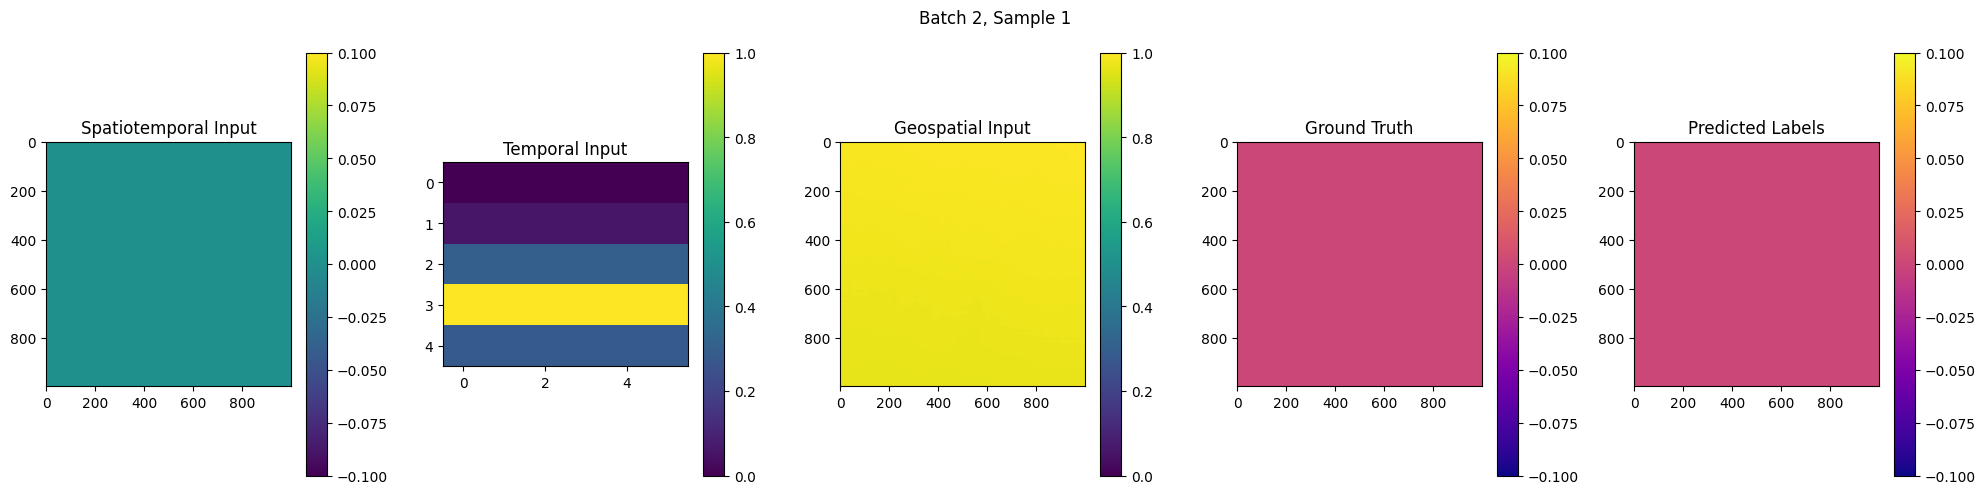

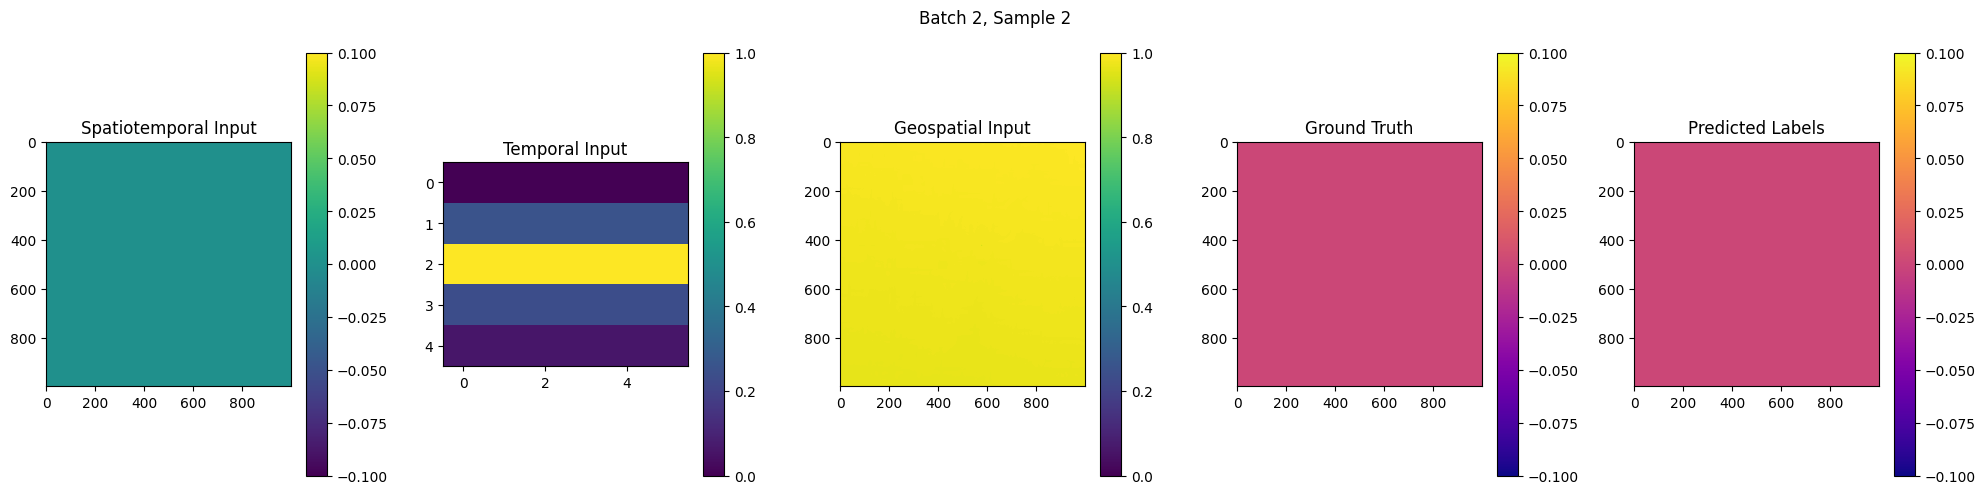

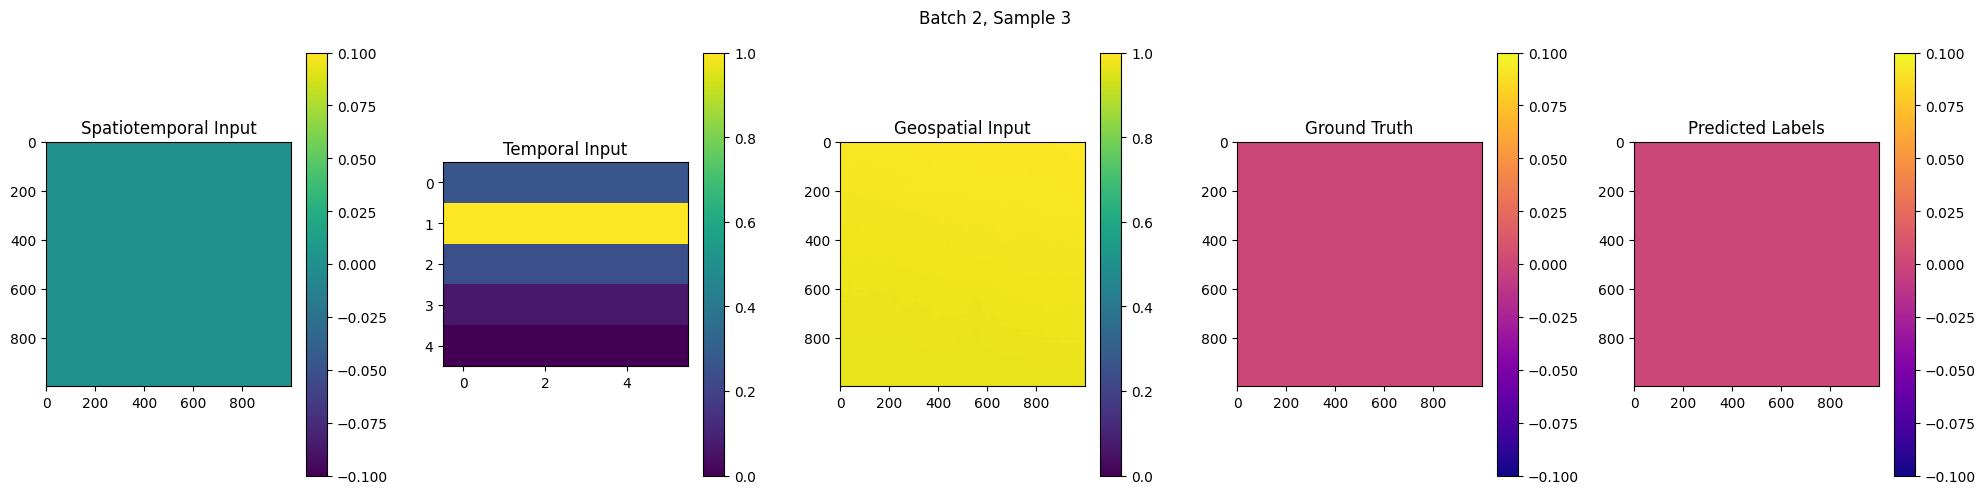

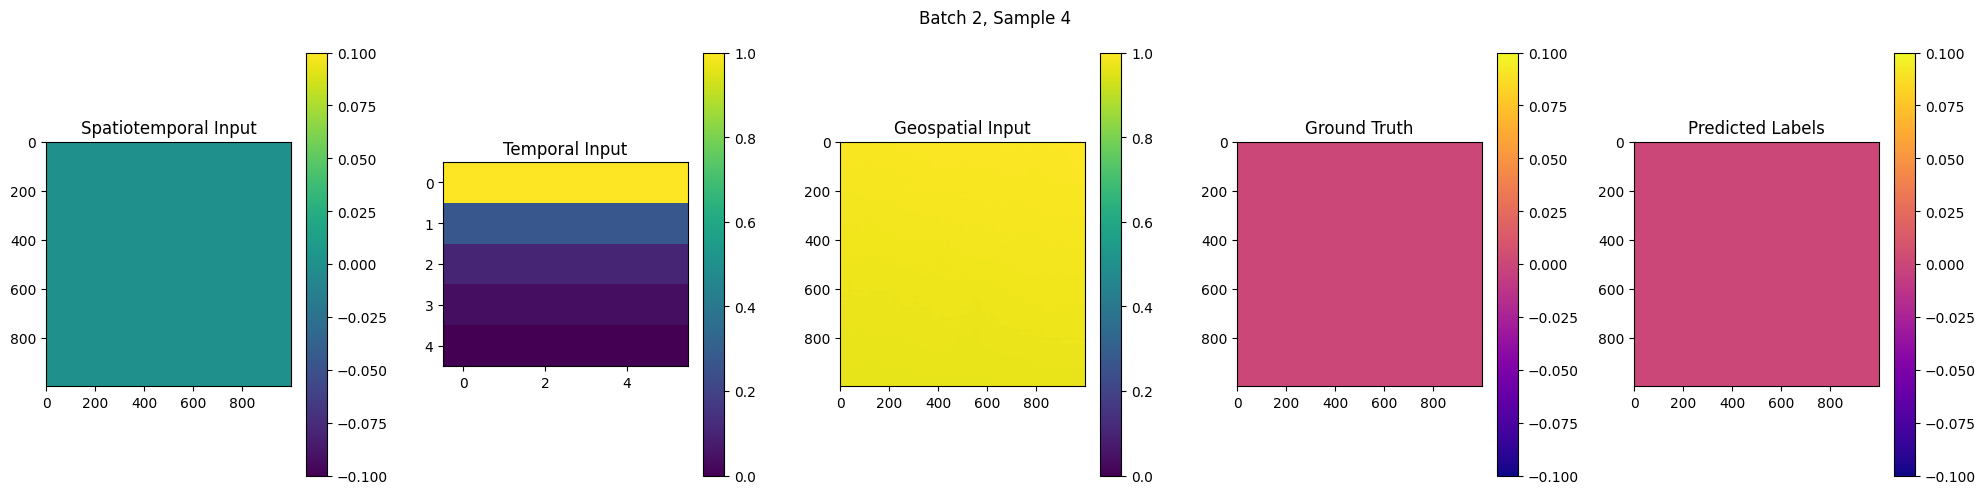

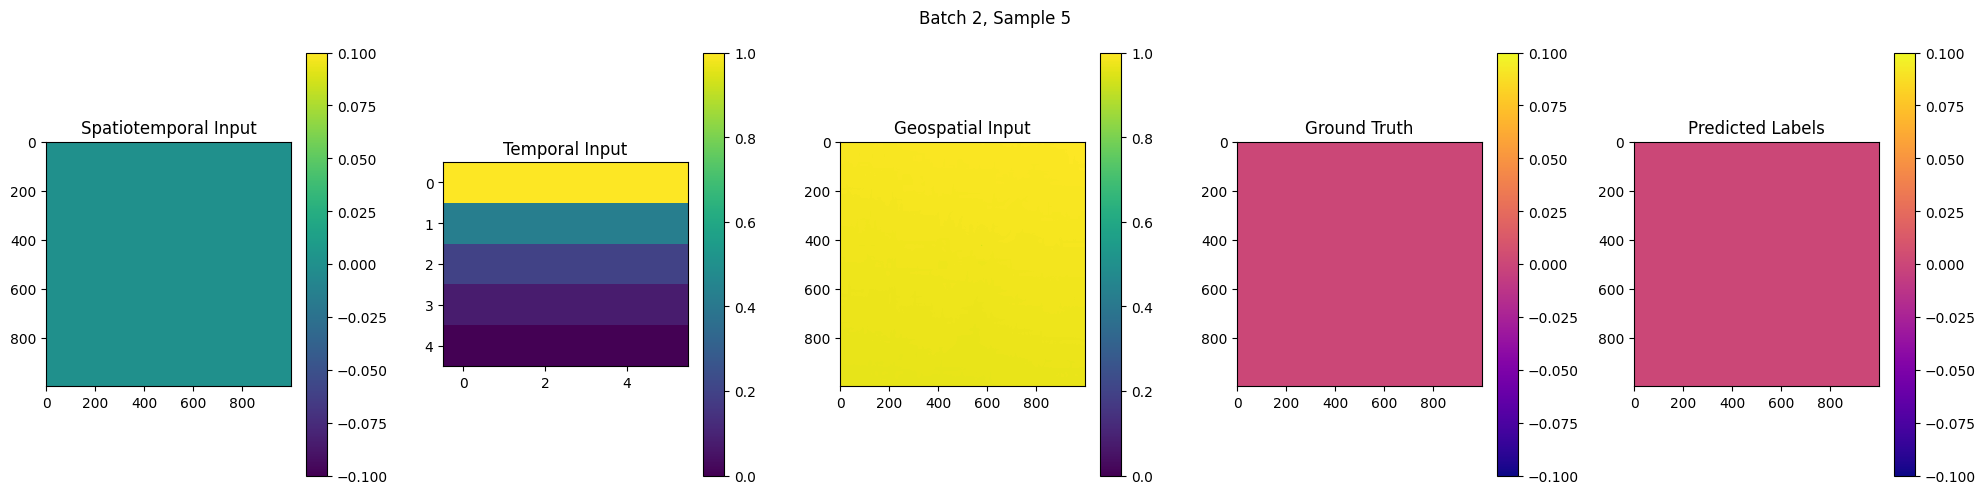

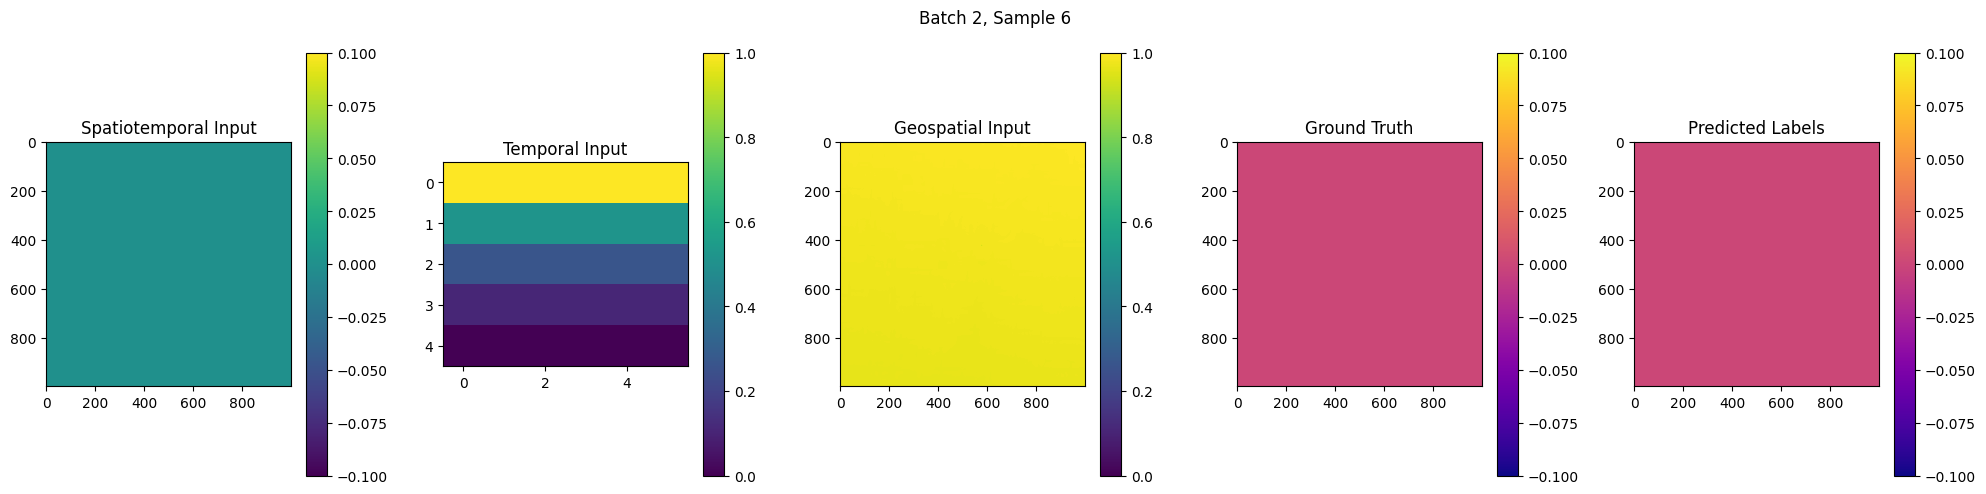

Visualizing Batch 3/10
Ground Truth Shape: (6, 1000, 1000)
Input Data[geospatial] Shape: (6, 1000, 1000, 8)
Input Data[temporal] Shape: (6, 5, 6)
Input Data[spatiotemporal] Shape: (6, 5, 1000, 1000, 1)
1/1 [==============================] - 0s 141ms/step
Predicted Labels Shape: (6, 1000, 1000, 1)


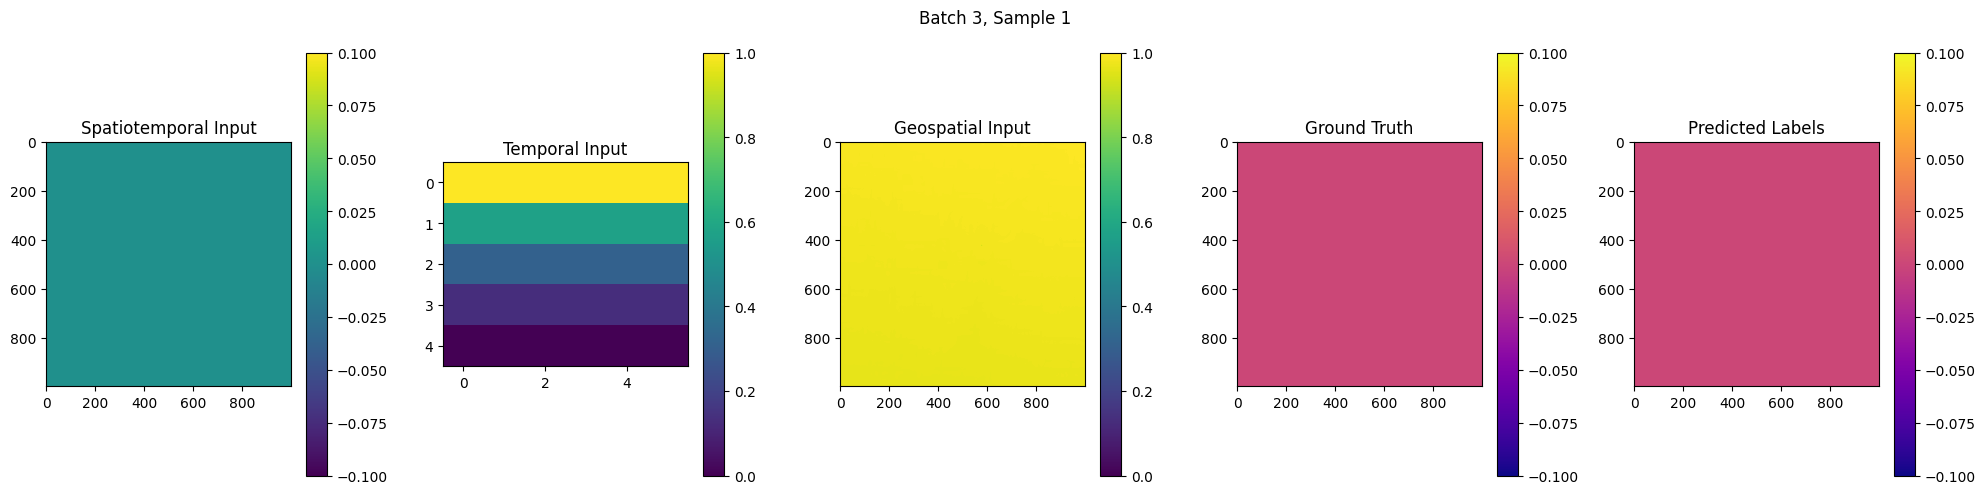

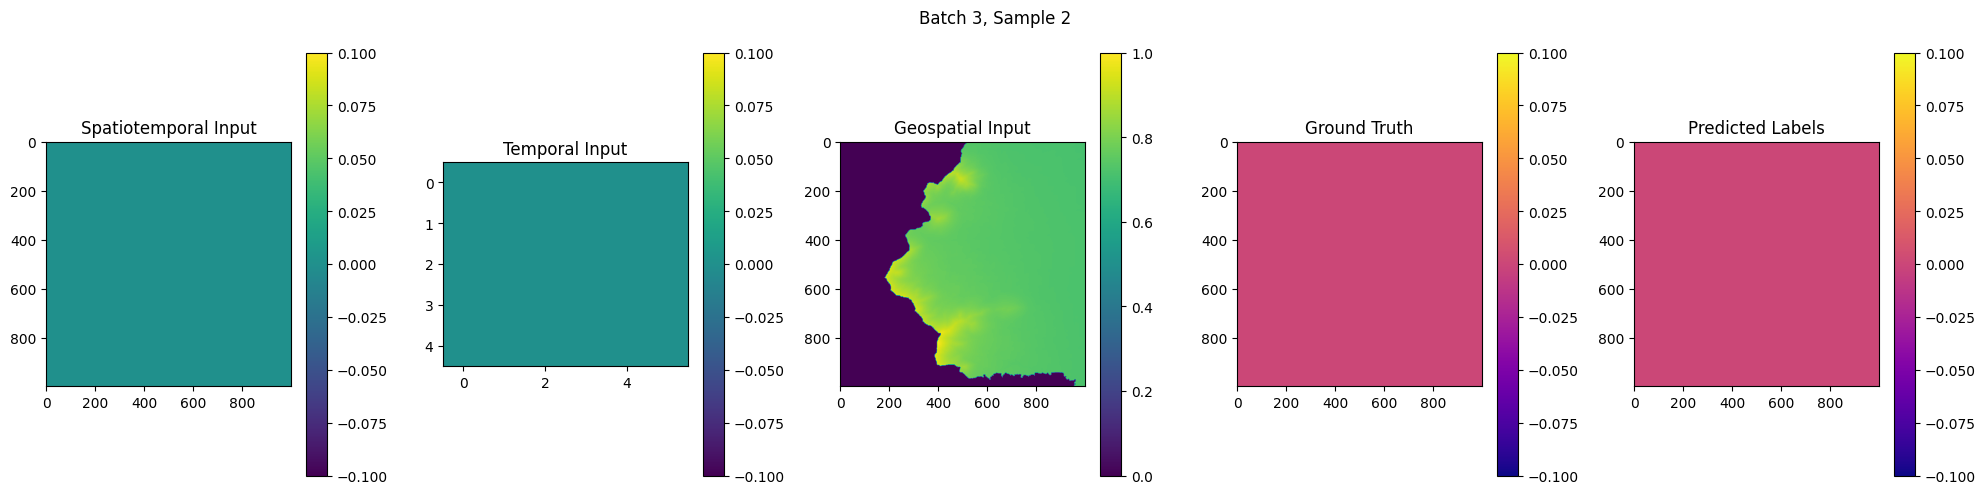

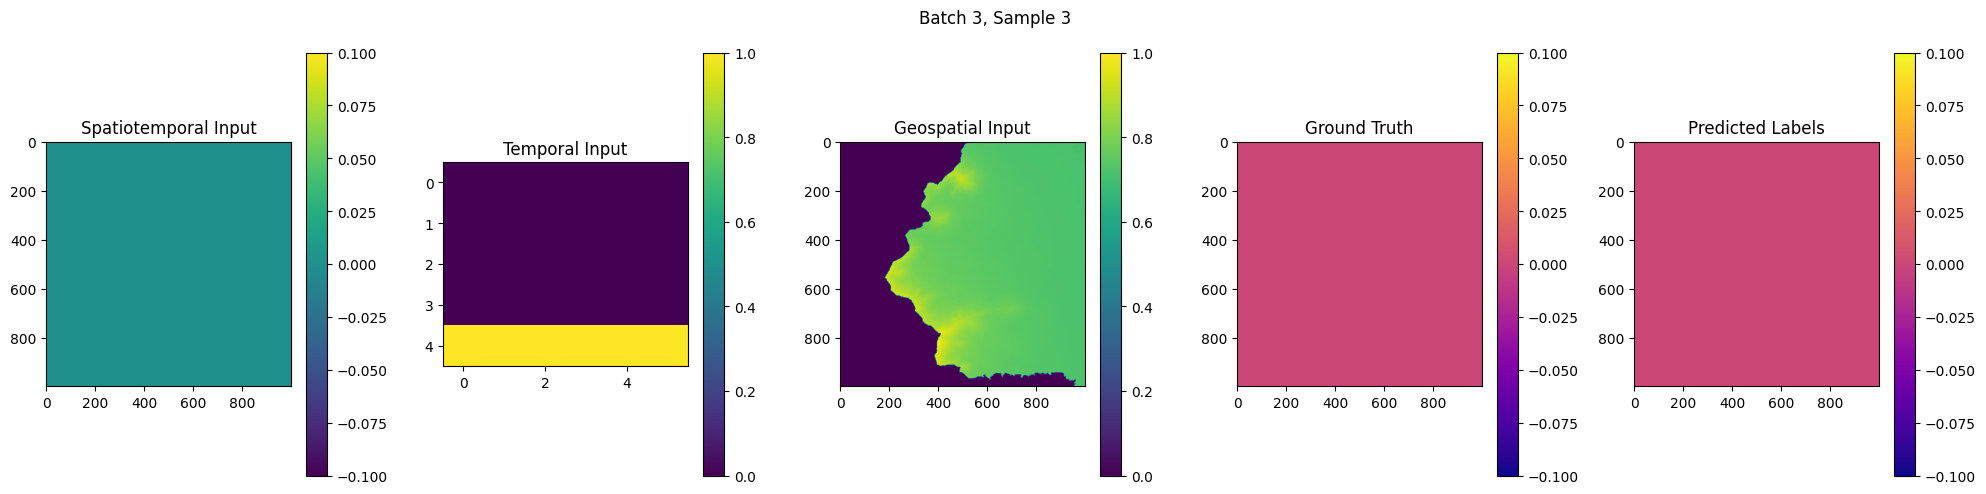

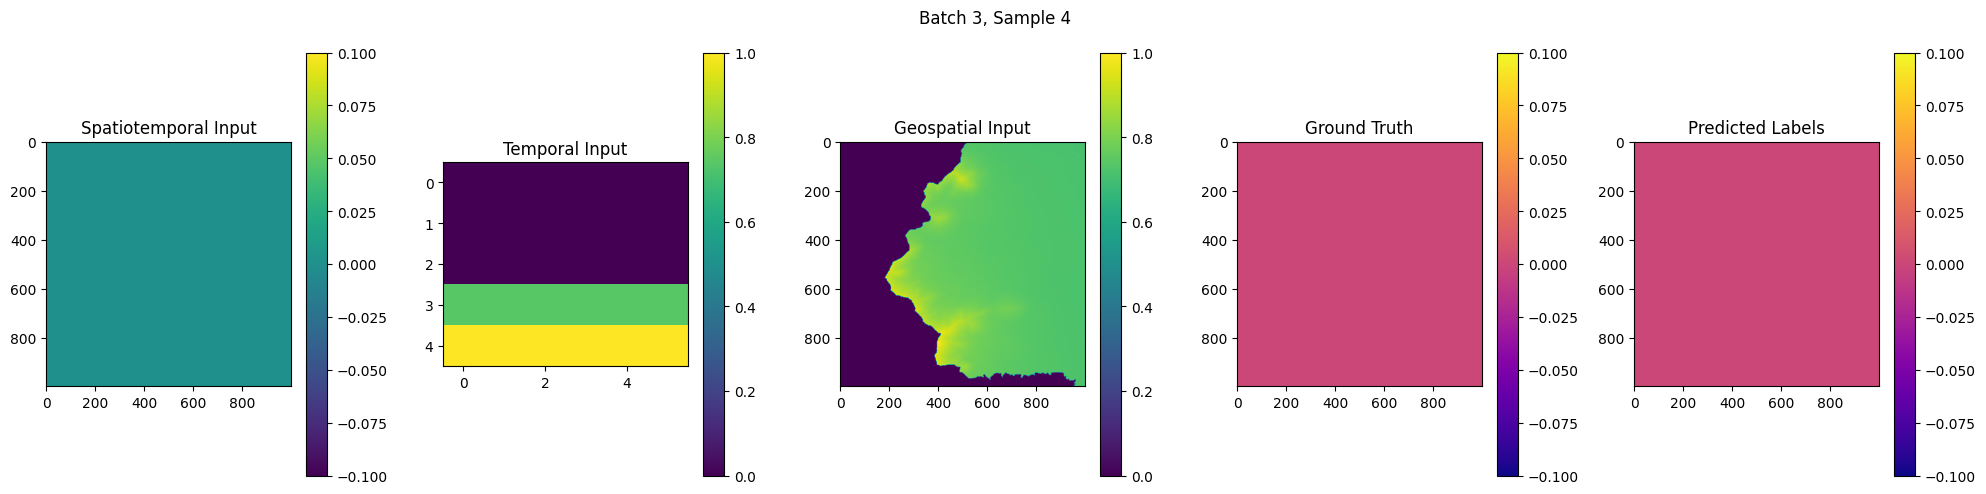

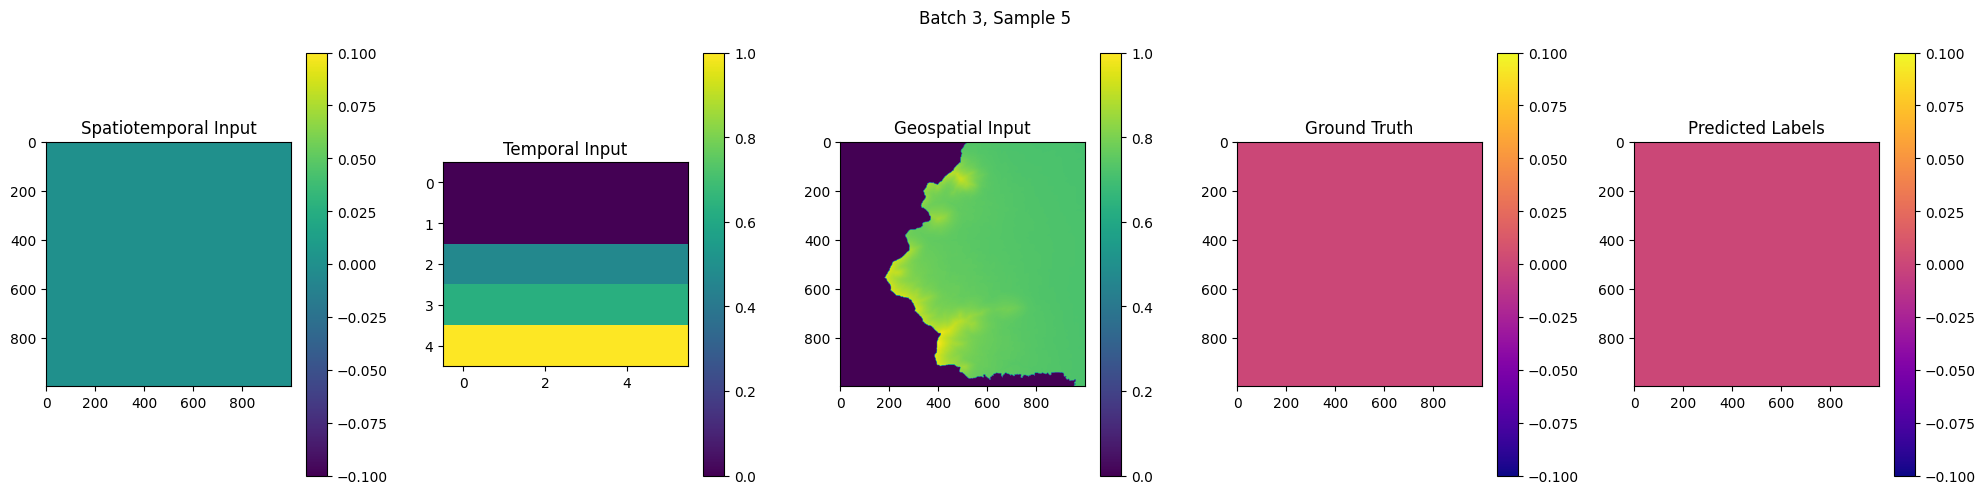

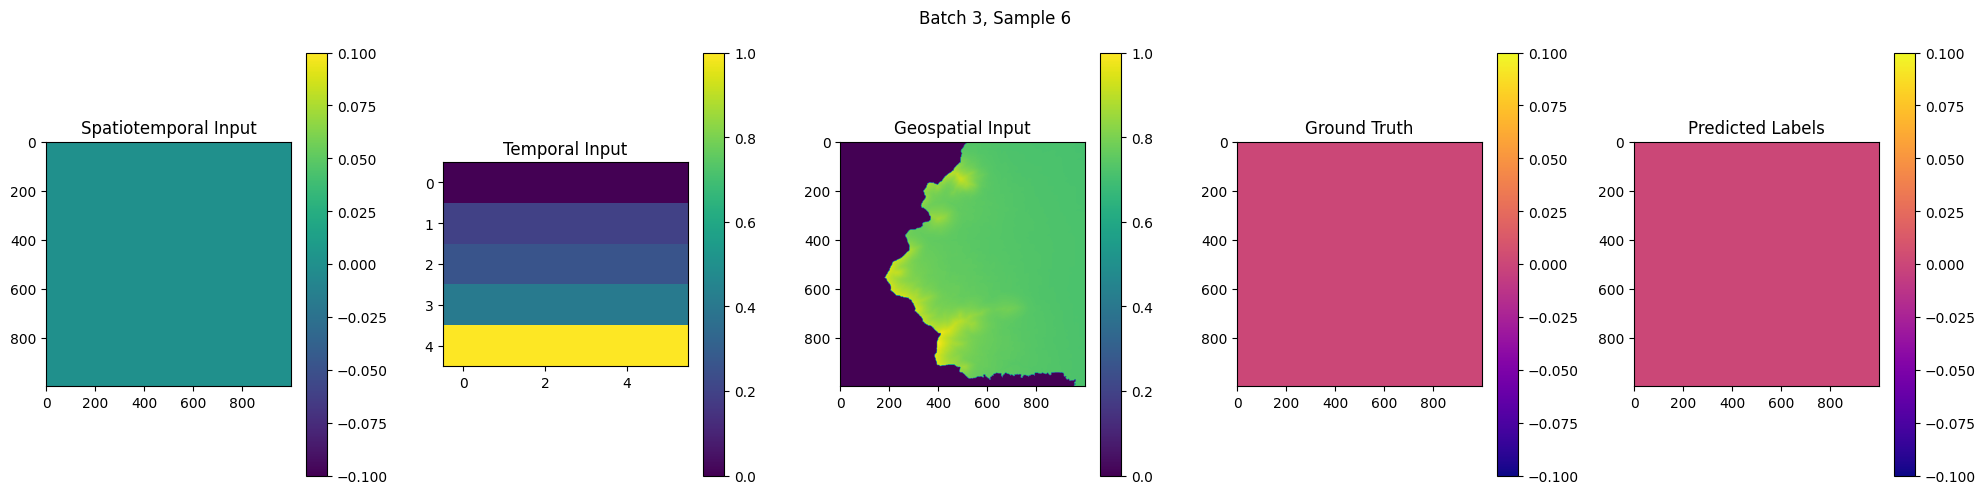

Visualizing Batch 4/10
Ground Truth Shape: (6, 1000, 1000)
Input Data[geospatial] Shape: (6, 1000, 1000, 8)
Input Data[temporal] Shape: (6, 5, 6)
Input Data[spatiotemporal] Shape: (6, 5, 1000, 1000, 1)
1/1 [==============================] - 0s 139ms/step
Predicted Labels Shape: (6, 1000, 1000, 1)


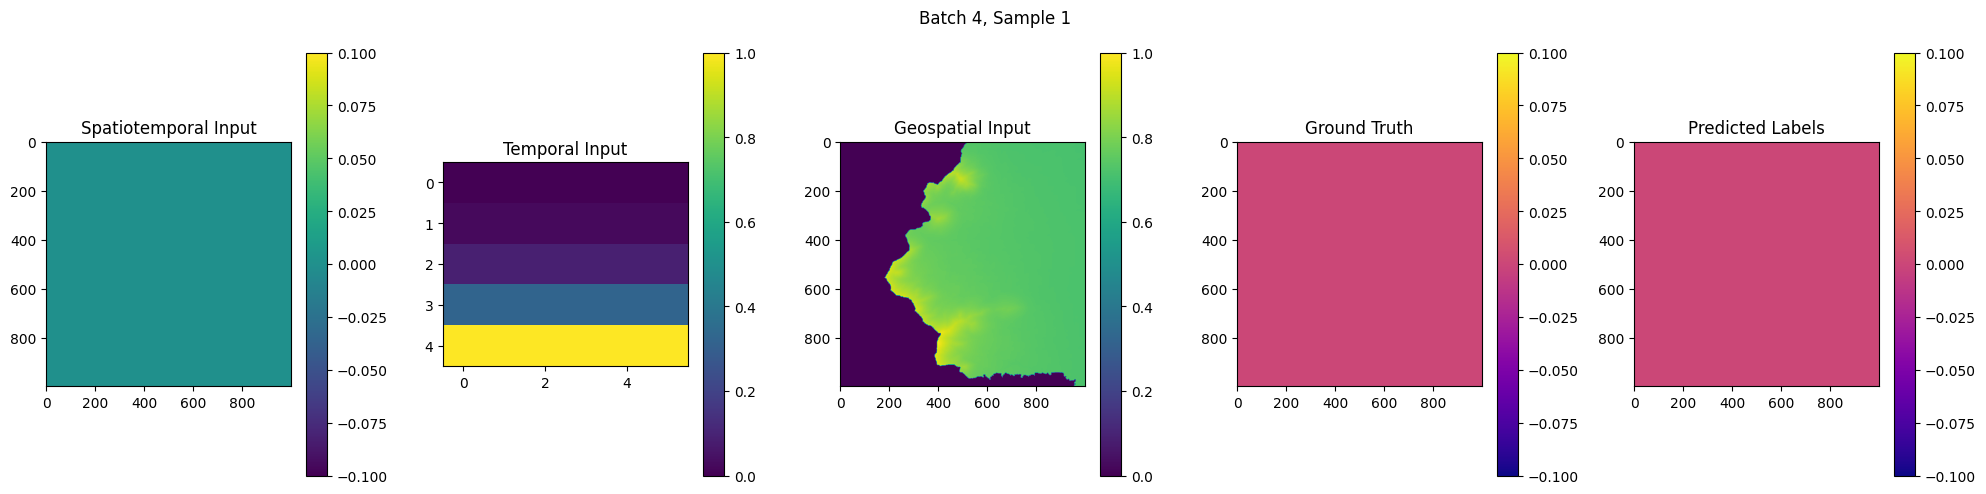

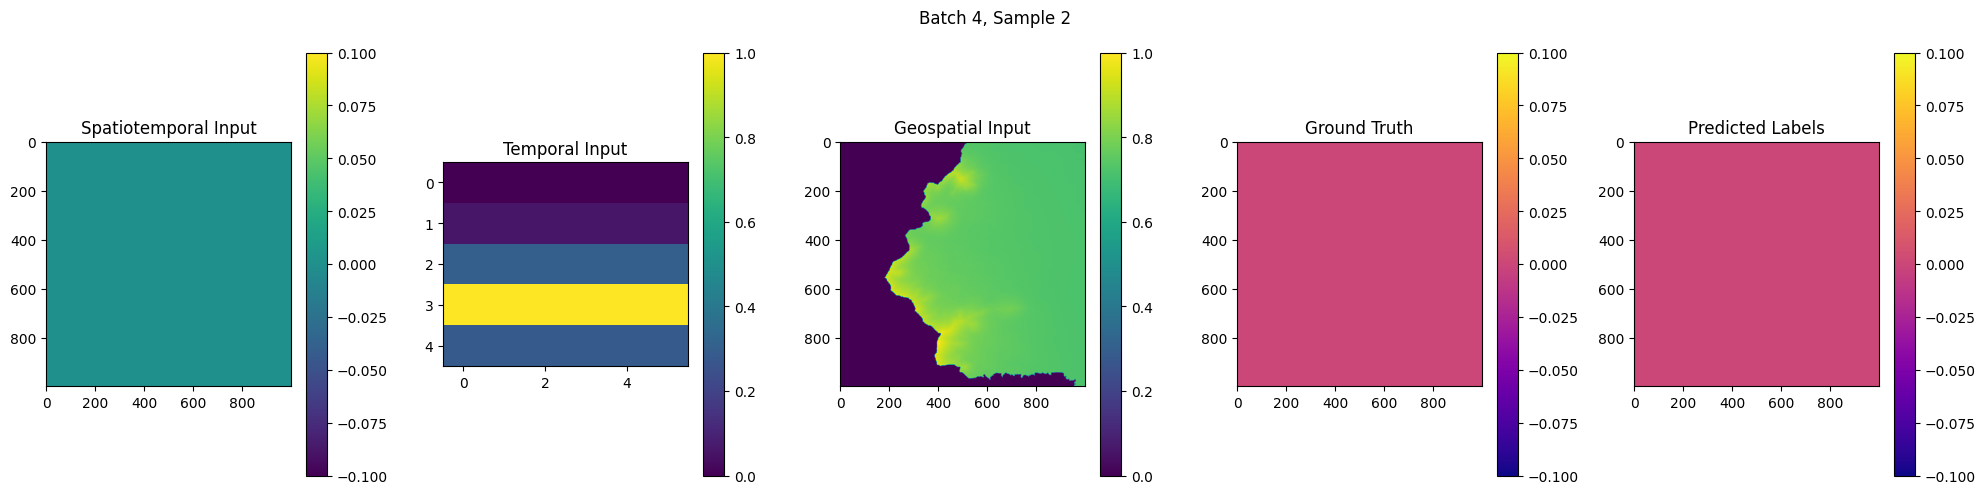

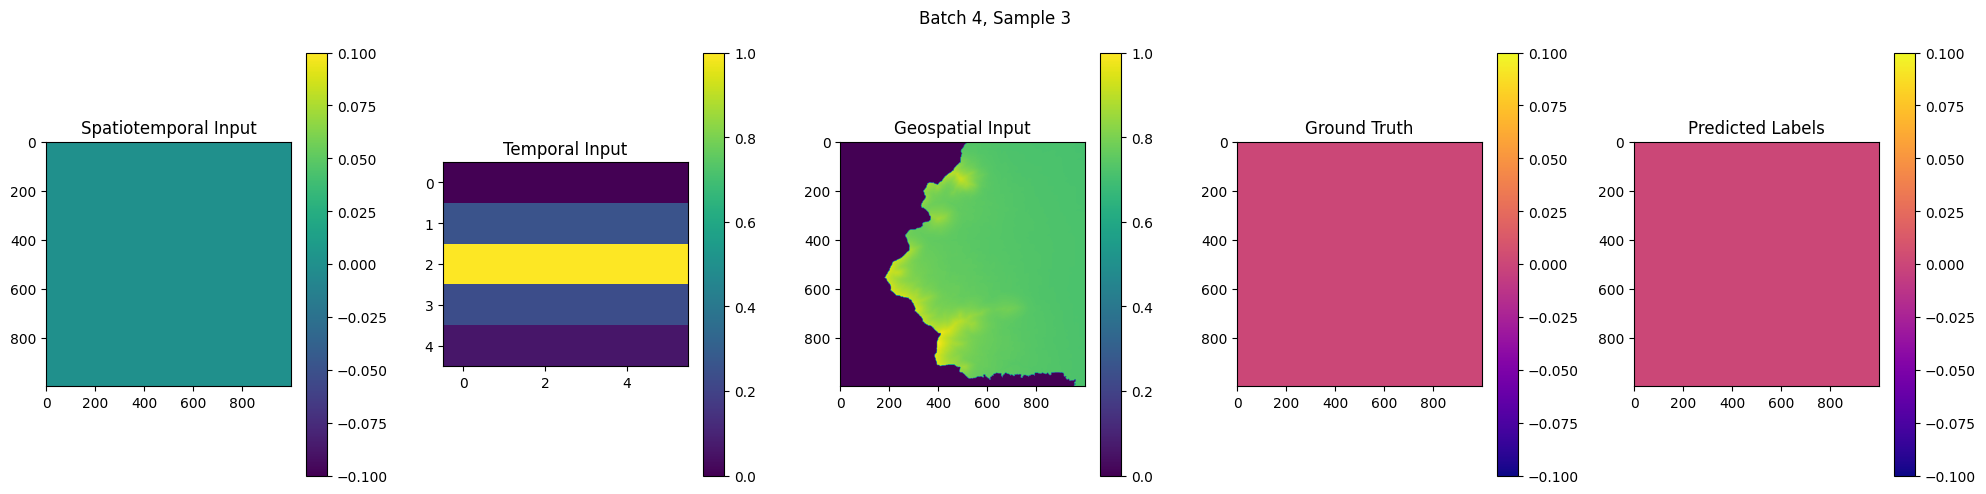

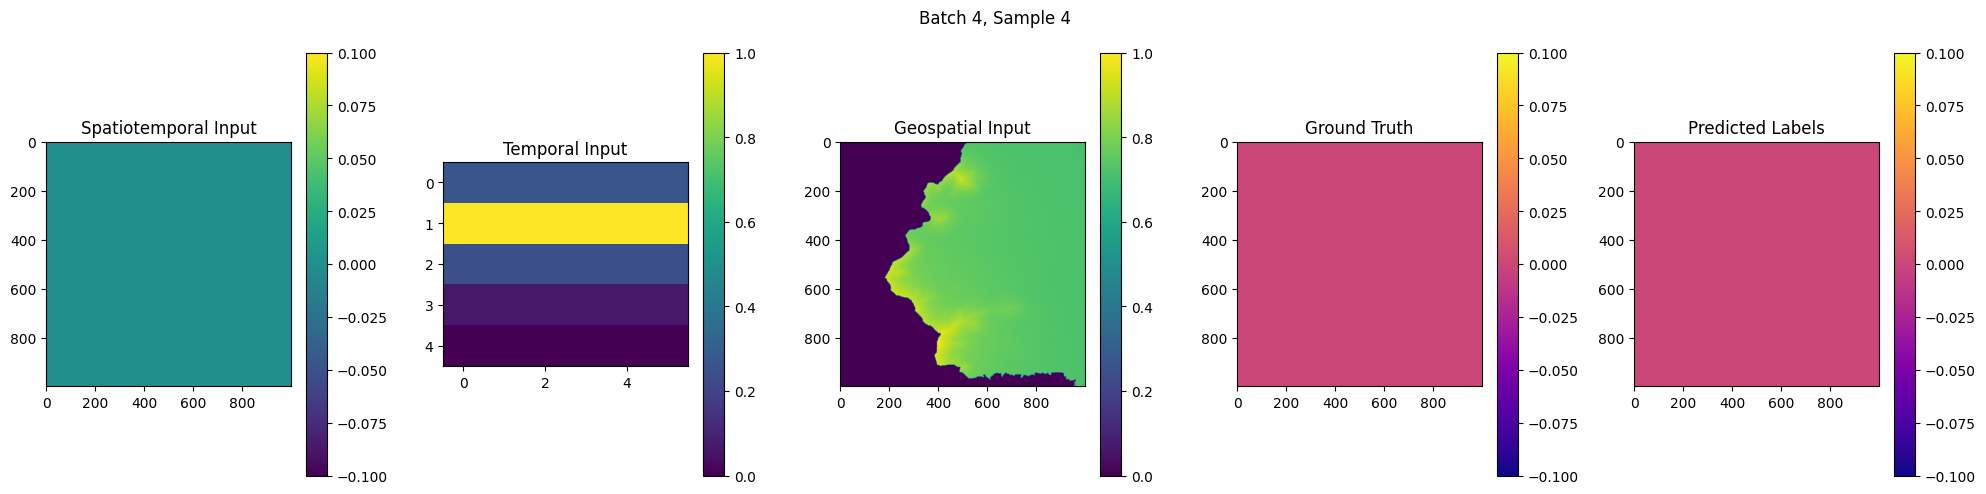

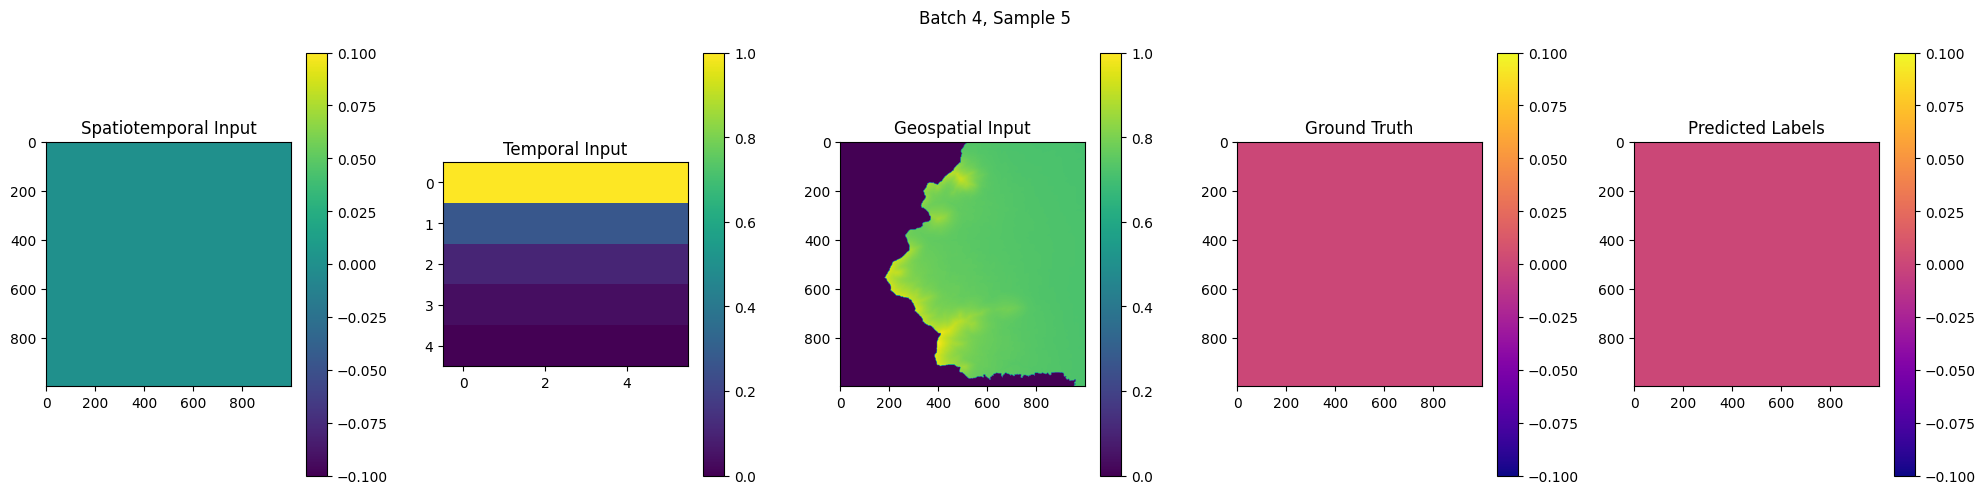

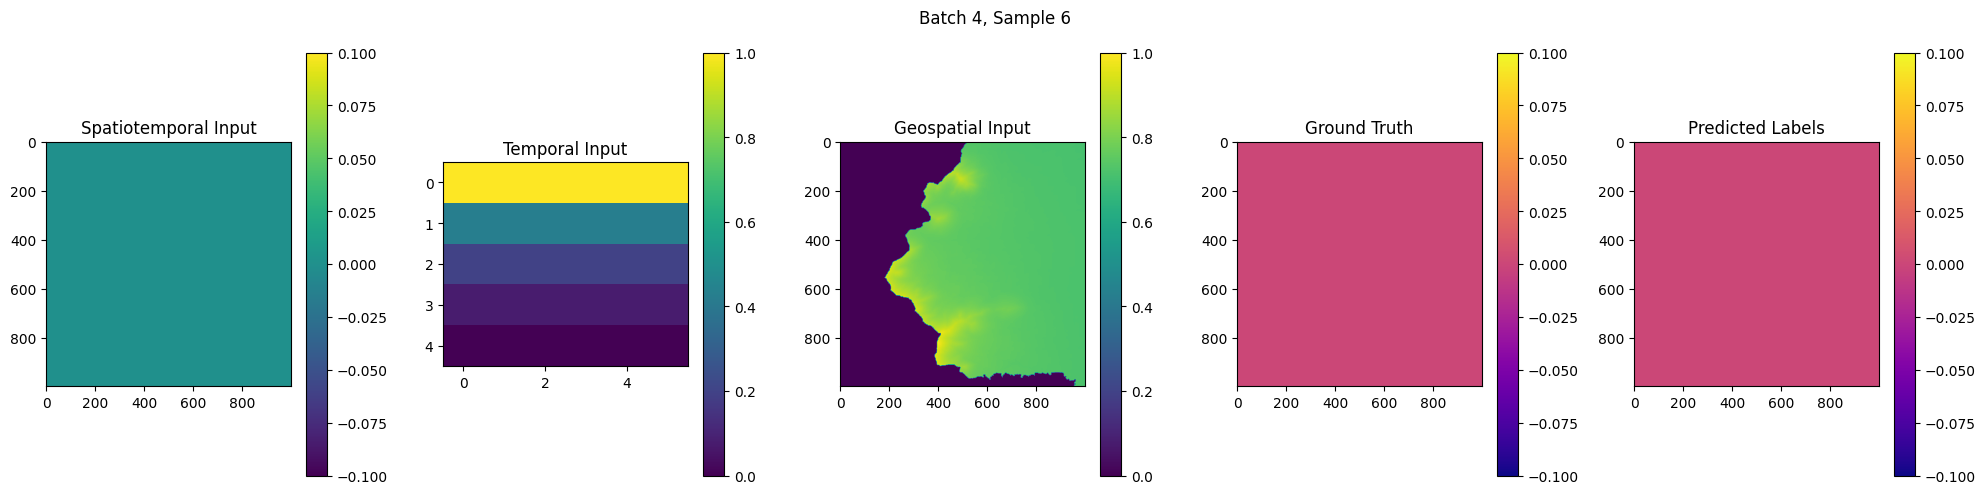

Visualizing Batch 5/10
Ground Truth Shape: (6, 1000, 1000)
Input Data[geospatial] Shape: (6, 1000, 1000, 8)
Input Data[temporal] Shape: (6, 5, 6)
Input Data[spatiotemporal] Shape: (6, 5, 1000, 1000, 1)
1/1 [==============================] - 0s 141ms/step
Predicted Labels Shape: (6, 1000, 1000, 1)


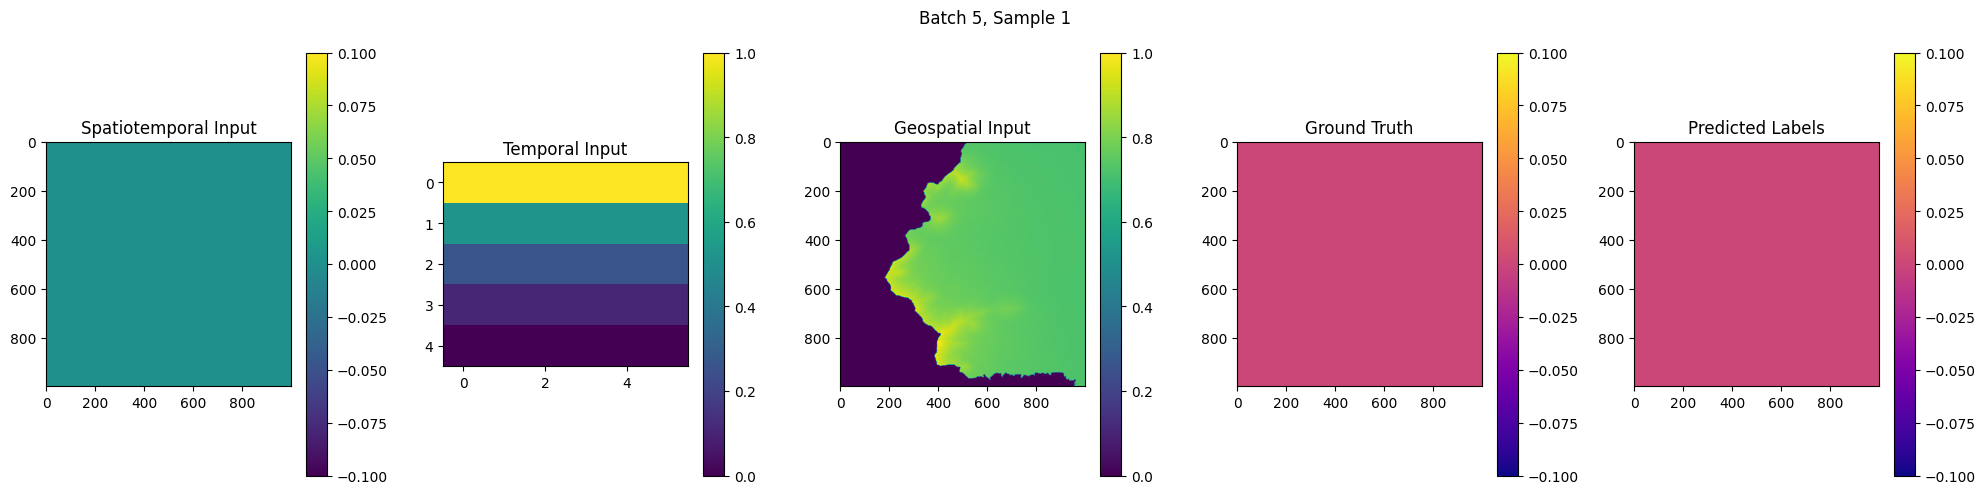

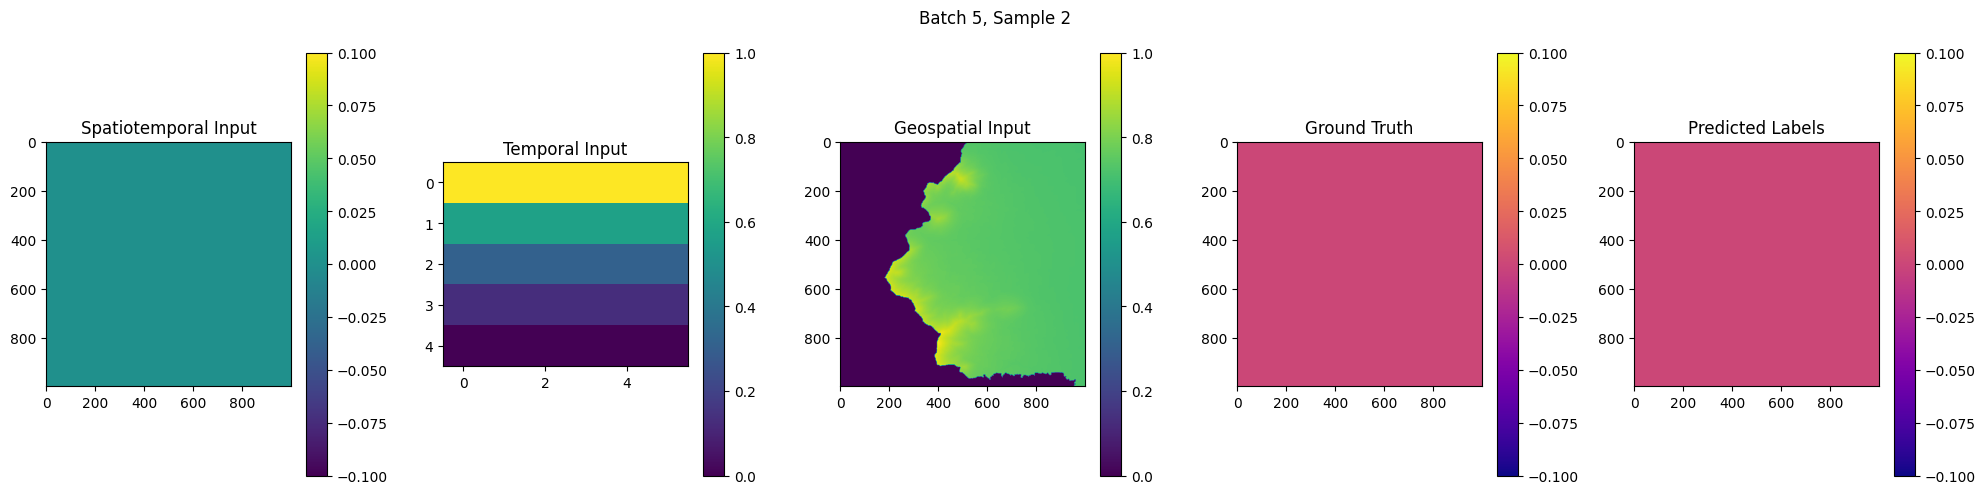

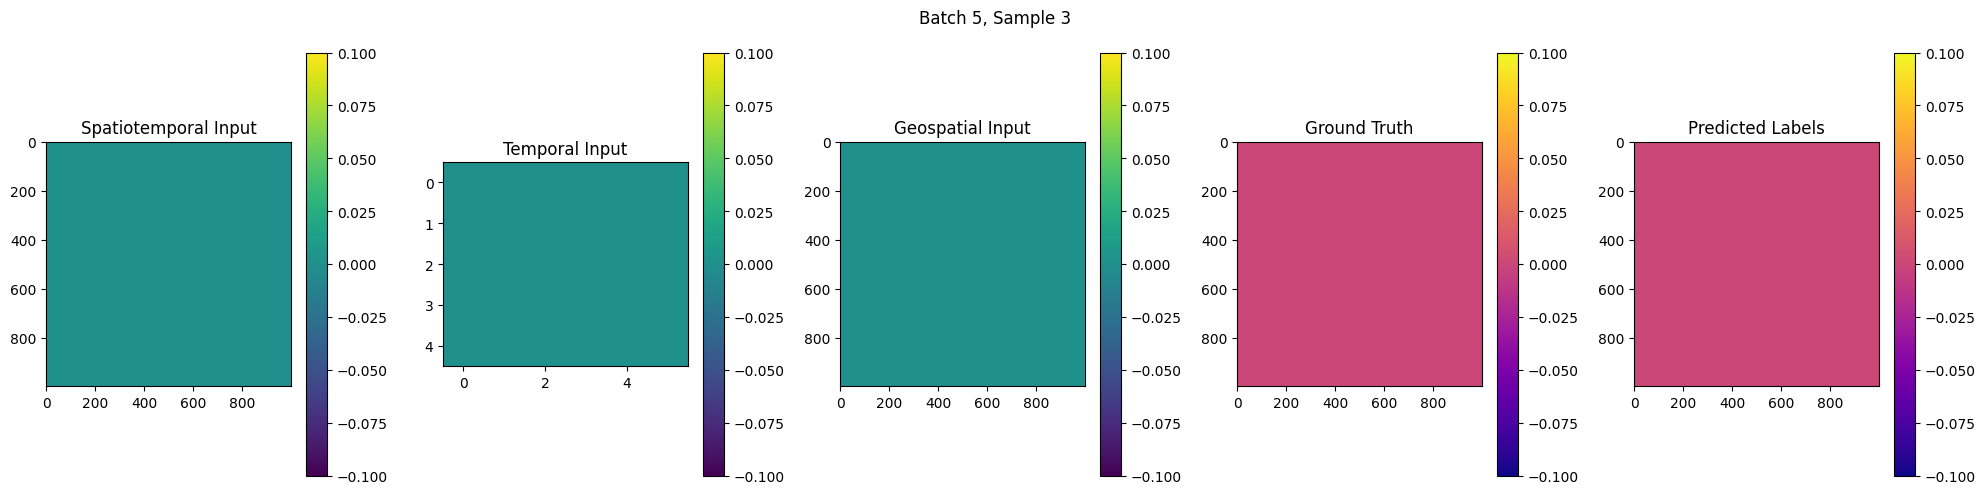

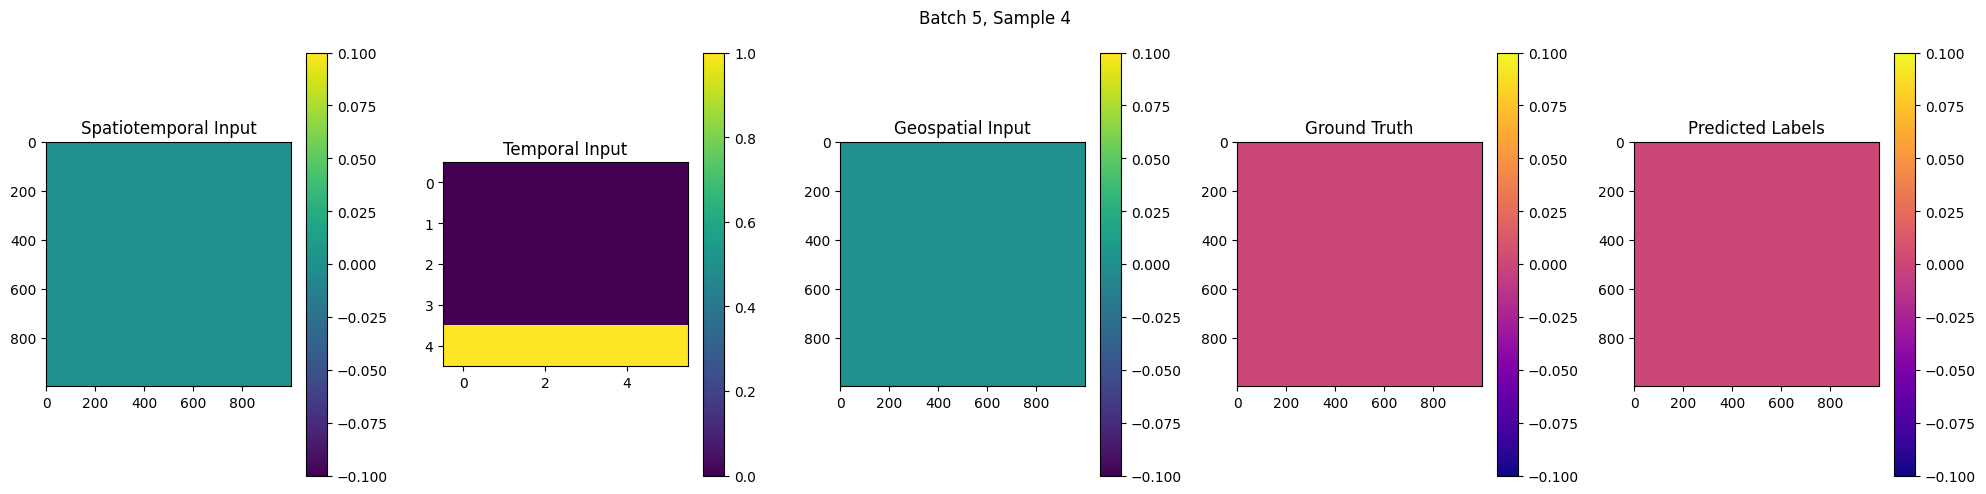

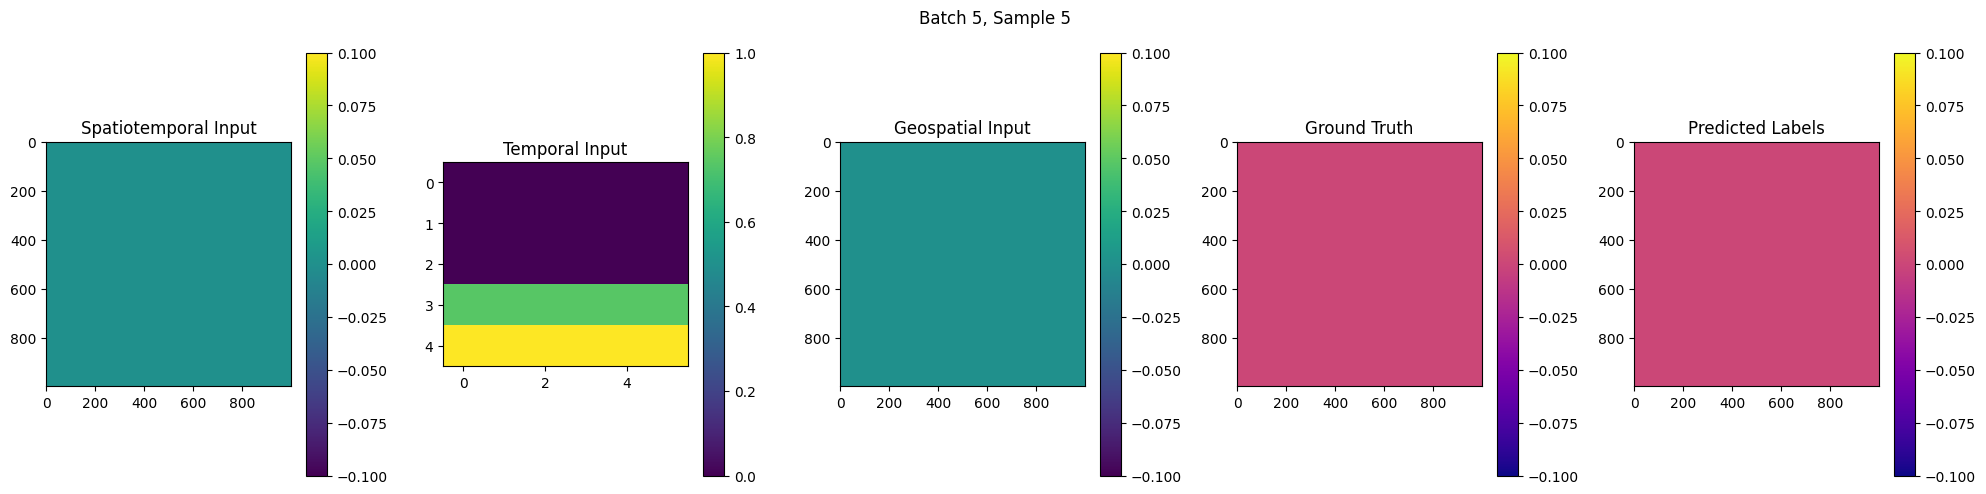

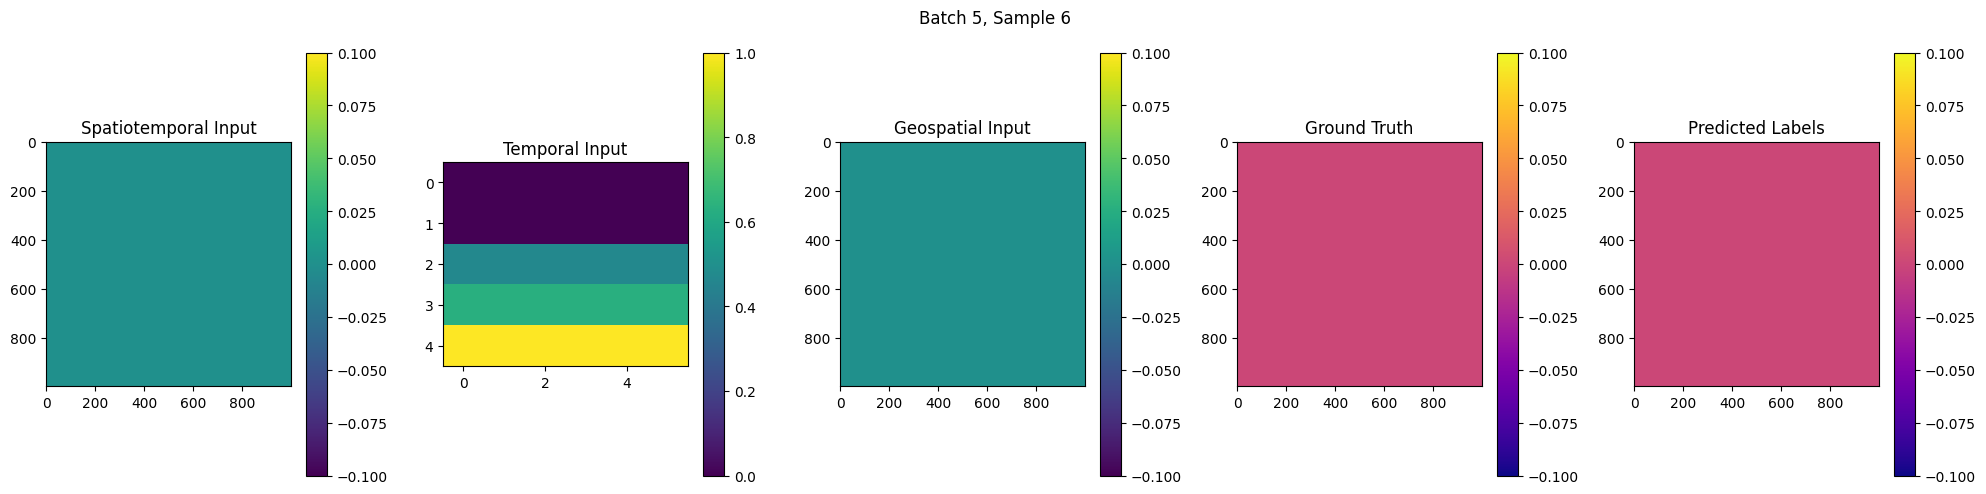

Visualizing Batch 6/10
Ground Truth Shape: (6, 1000, 1000)
Input Data[geospatial] Shape: (6, 1000, 1000, 8)
Input Data[temporal] Shape: (6, 5, 6)
Input Data[spatiotemporal] Shape: (6, 5, 1000, 1000, 1)
1/1 [==============================] - 0s 145ms/step
Predicted Labels Shape: (6, 1000, 1000, 1)


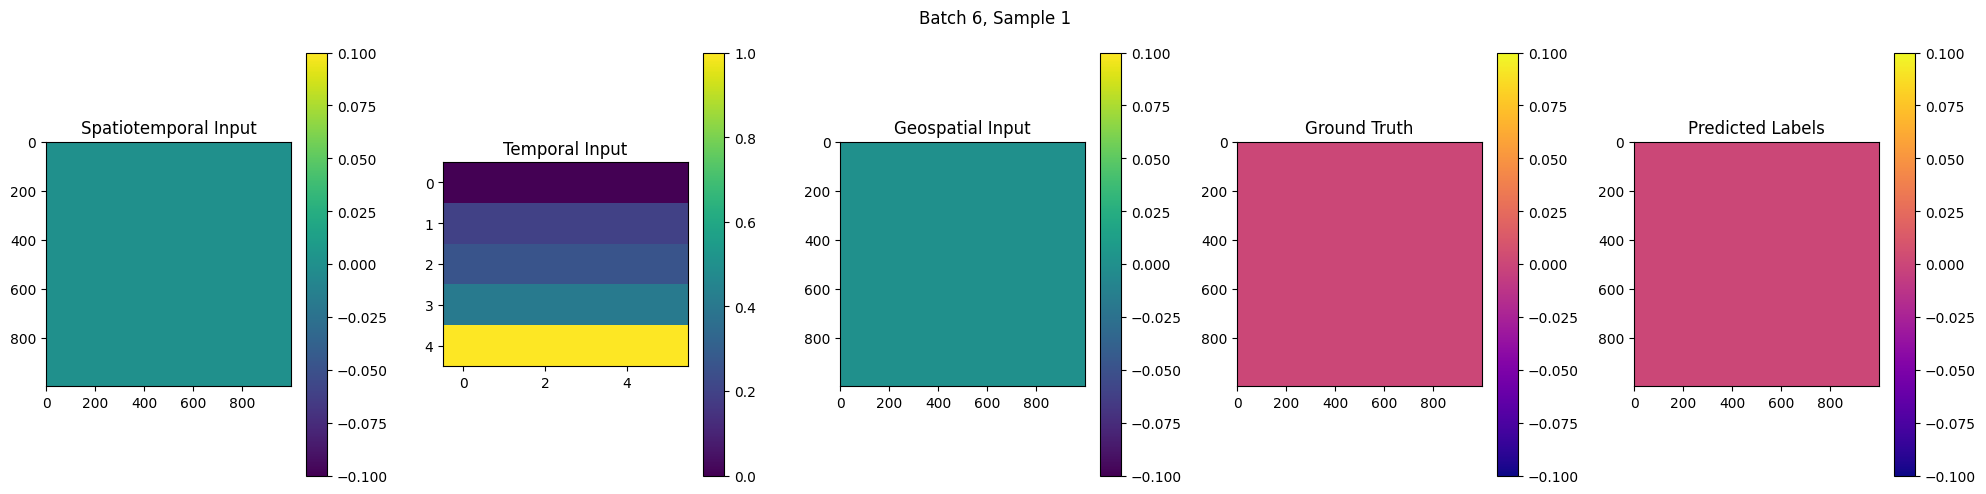

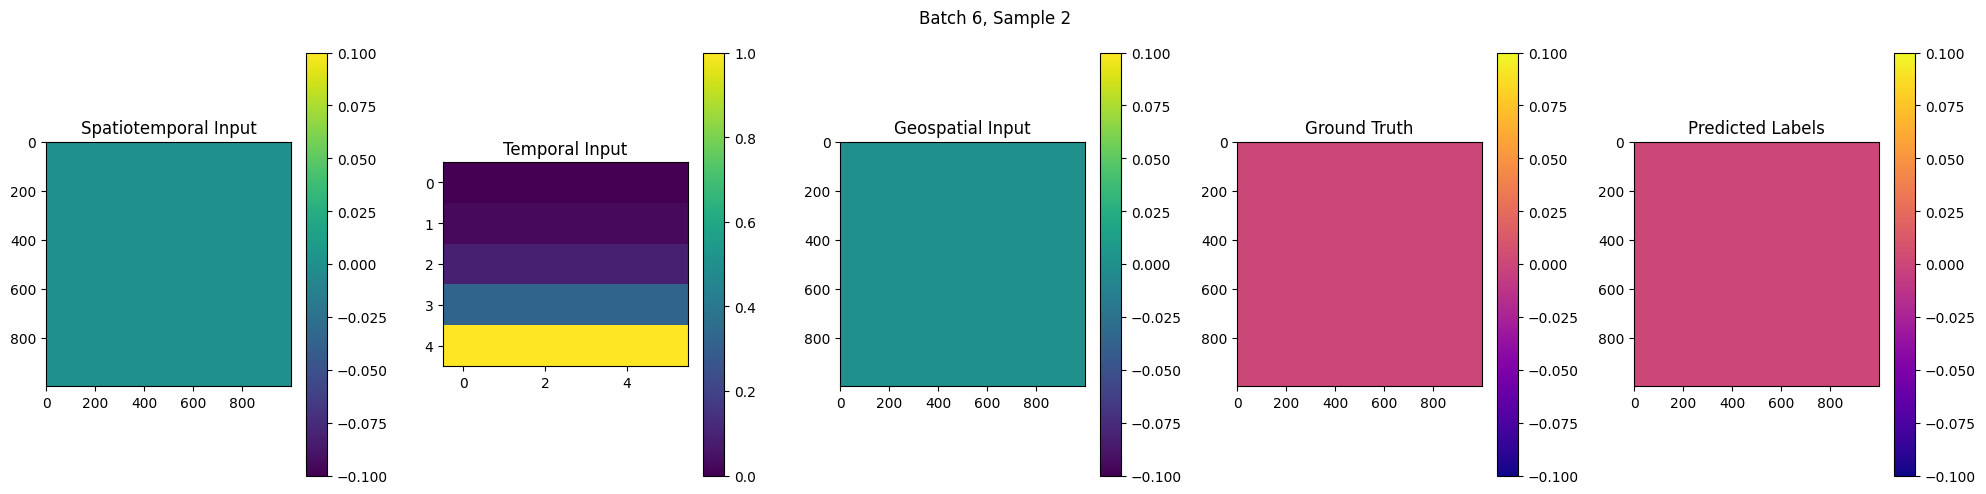

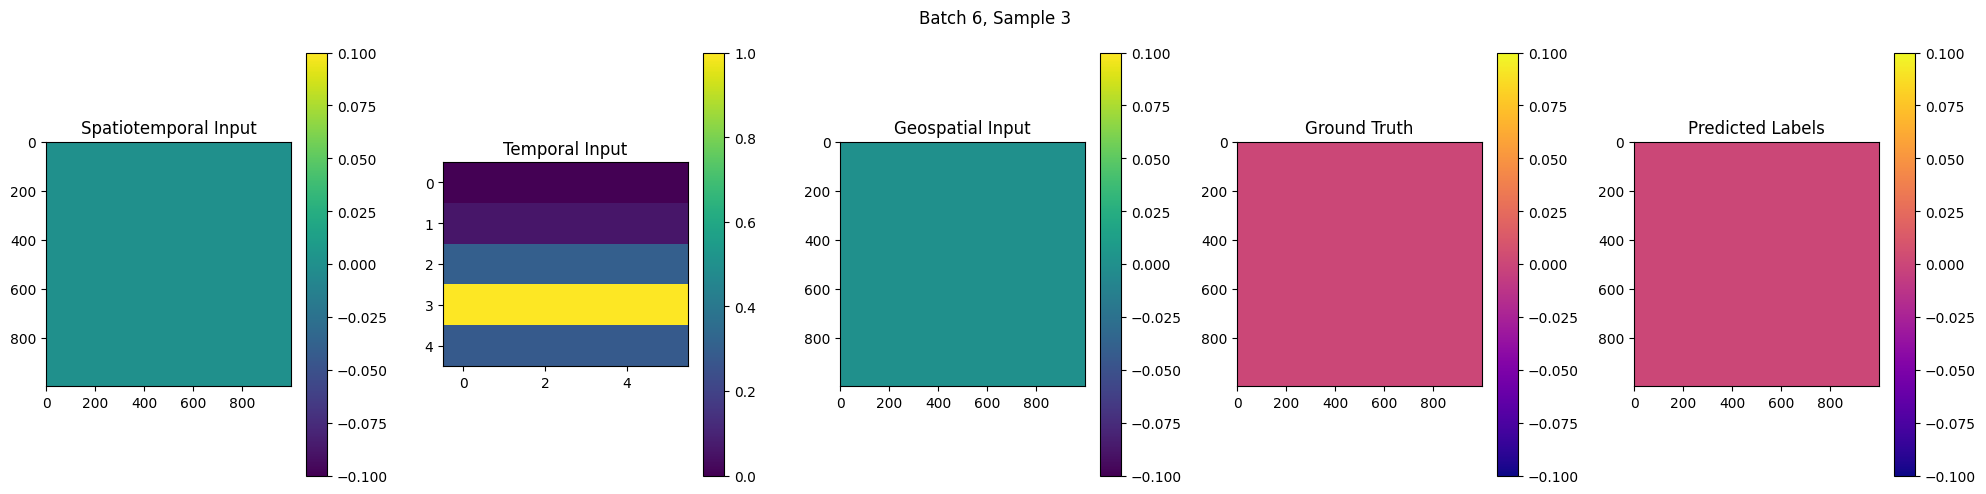

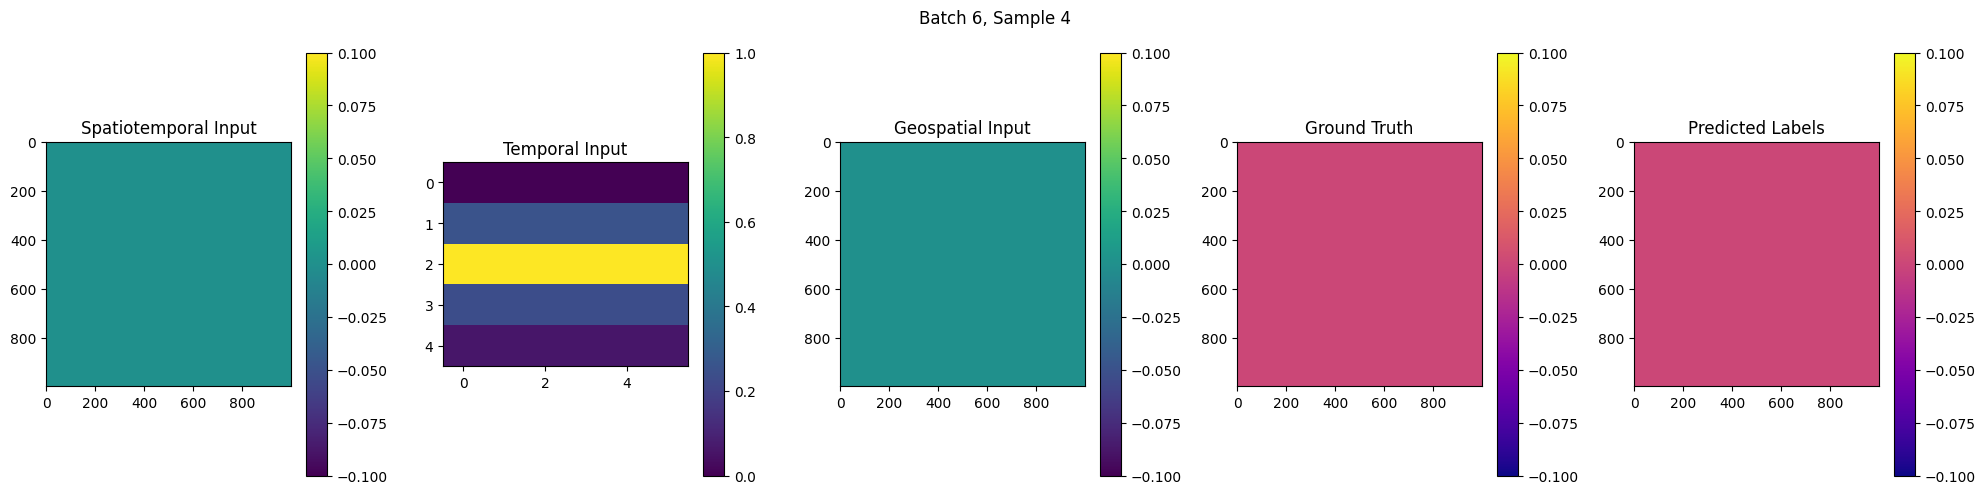

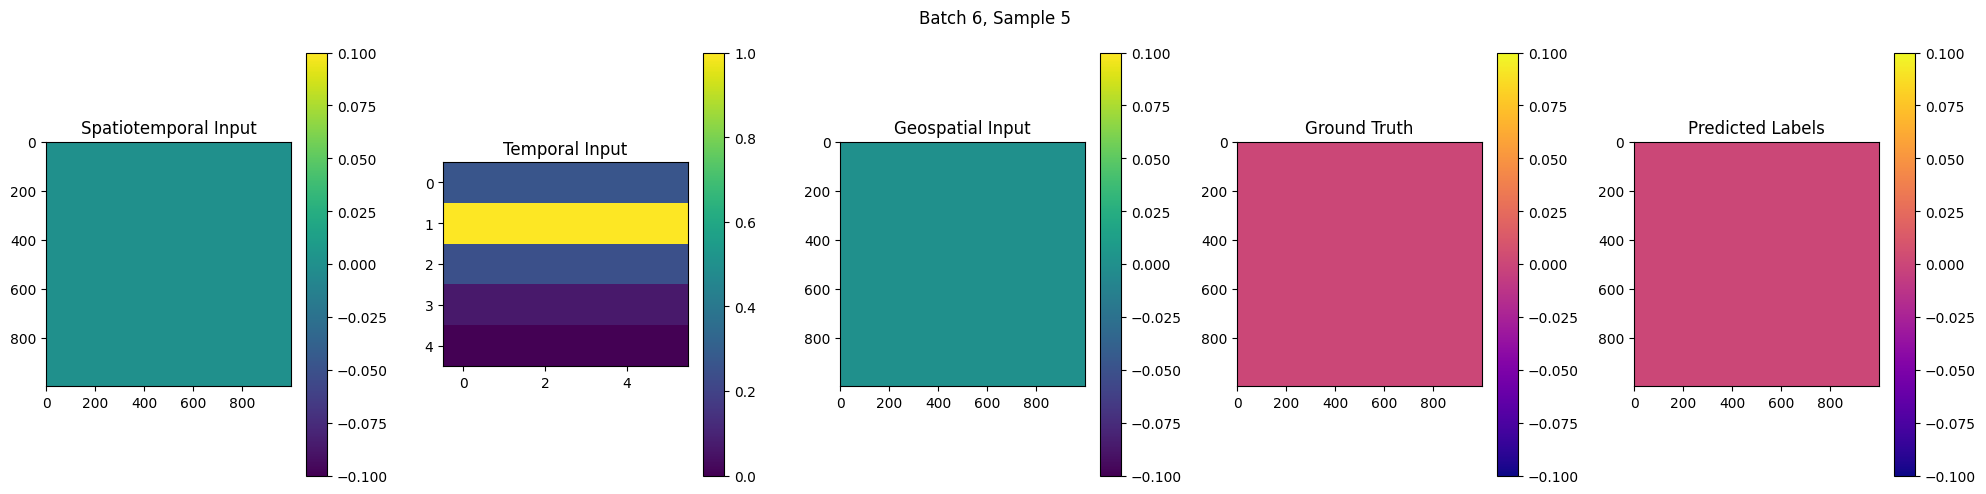

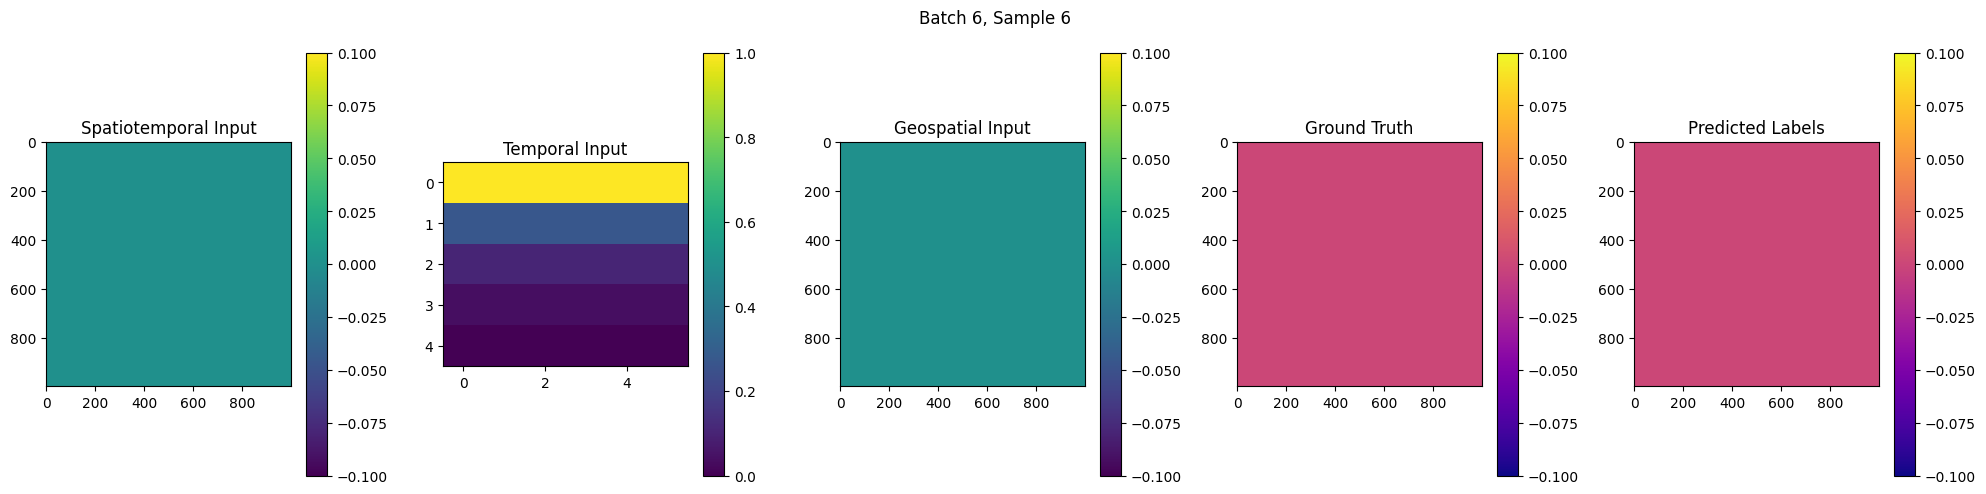

Visualizing Batch 7/10
Ground Truth Shape: (6, 1000, 1000)
Input Data[geospatial] Shape: (6, 1000, 1000, 8)
Input Data[temporal] Shape: (6, 5, 6)
Input Data[spatiotemporal] Shape: (6, 5, 1000, 1000, 1)
1/1 [==============================] - 0s 137ms/step
Predicted Labels Shape: (6, 1000, 1000, 1)


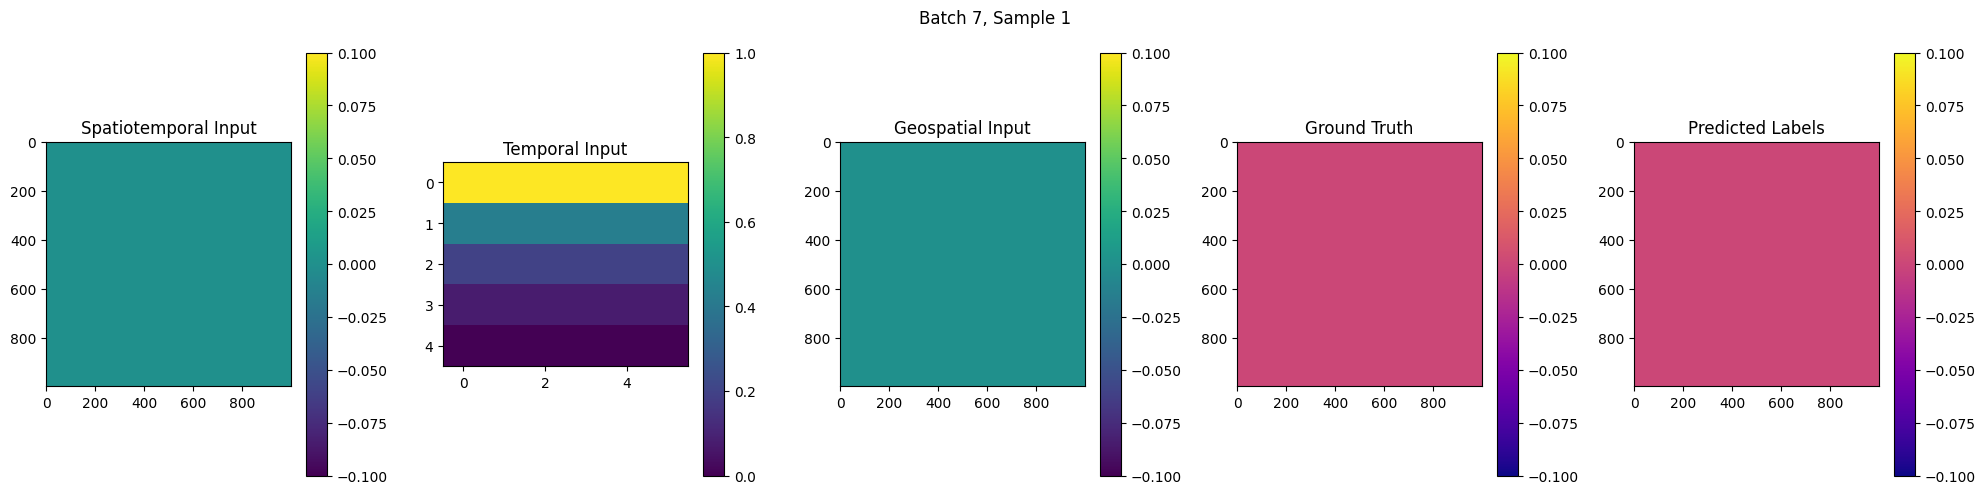

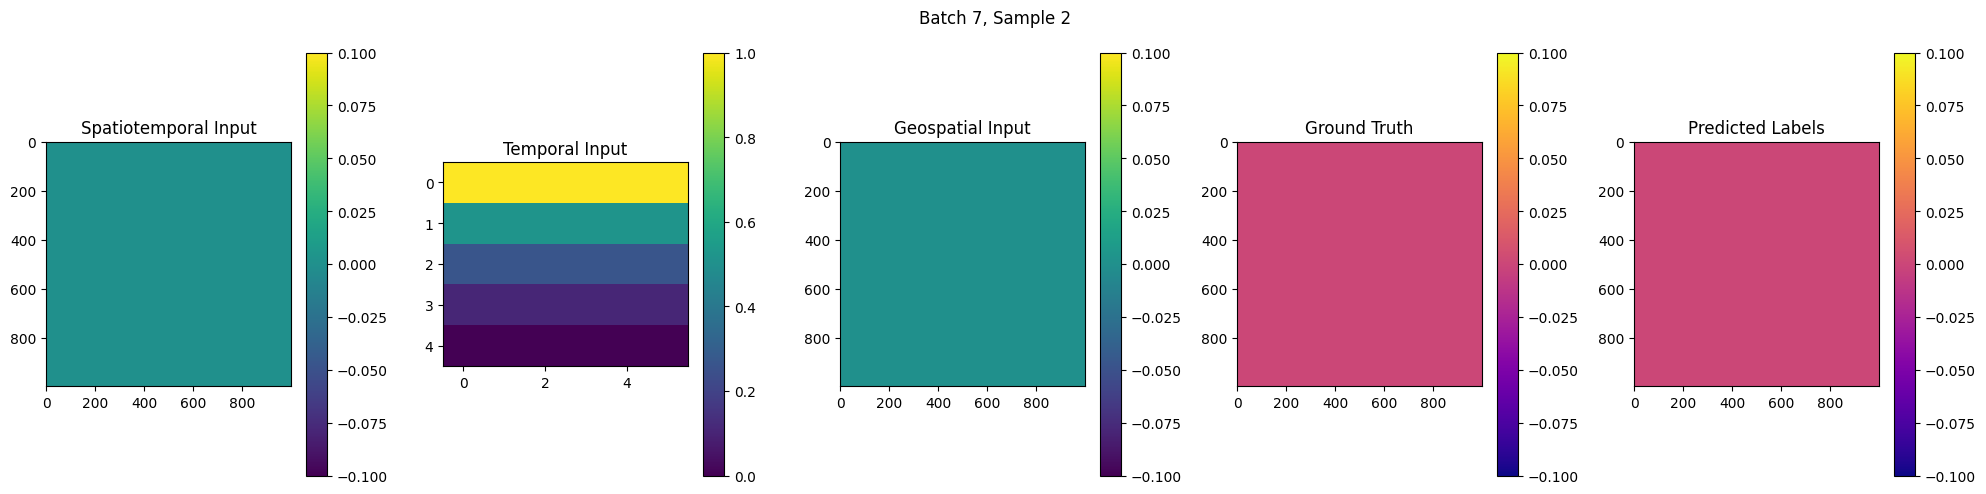

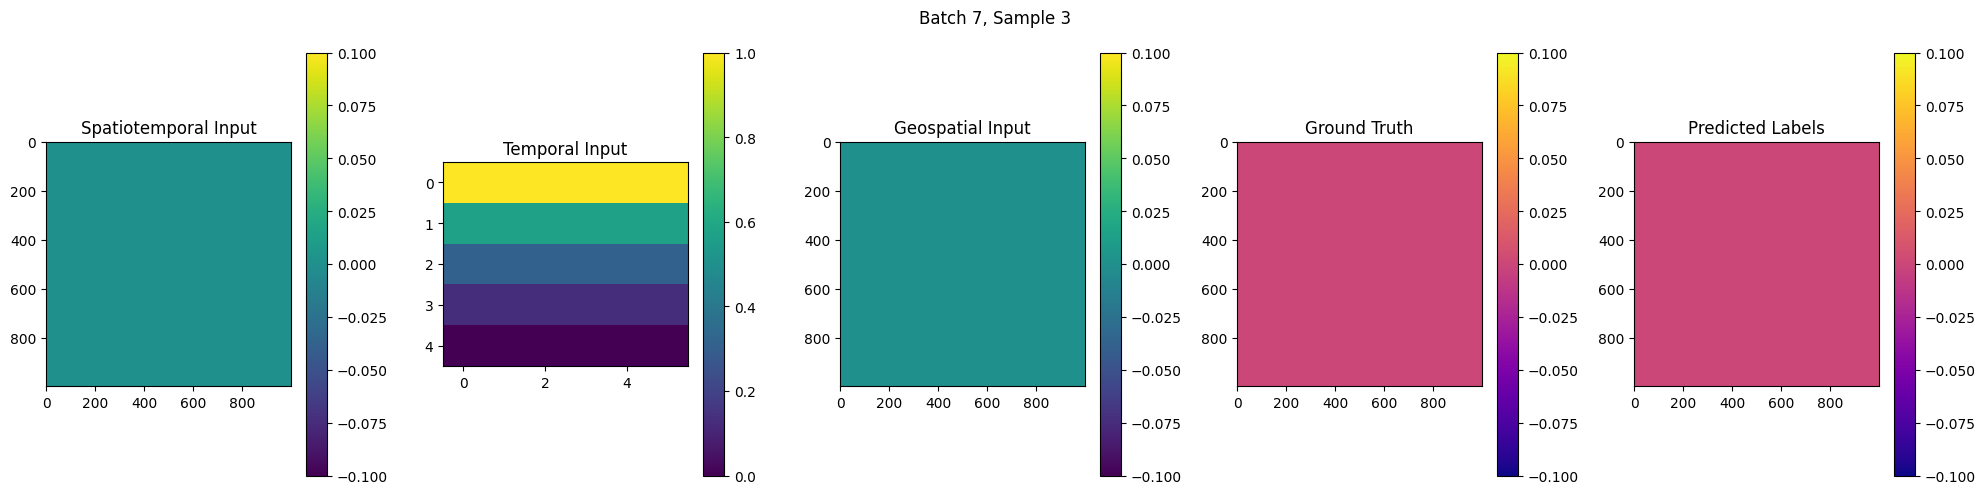

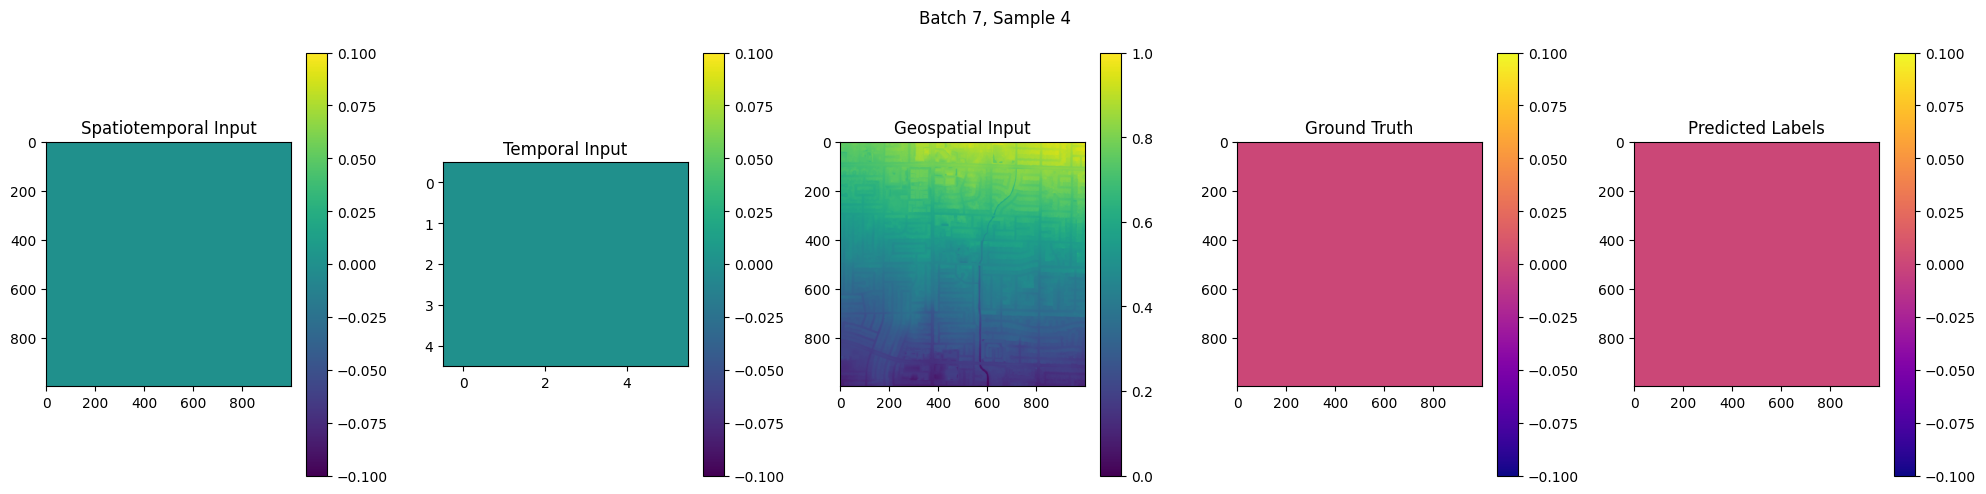

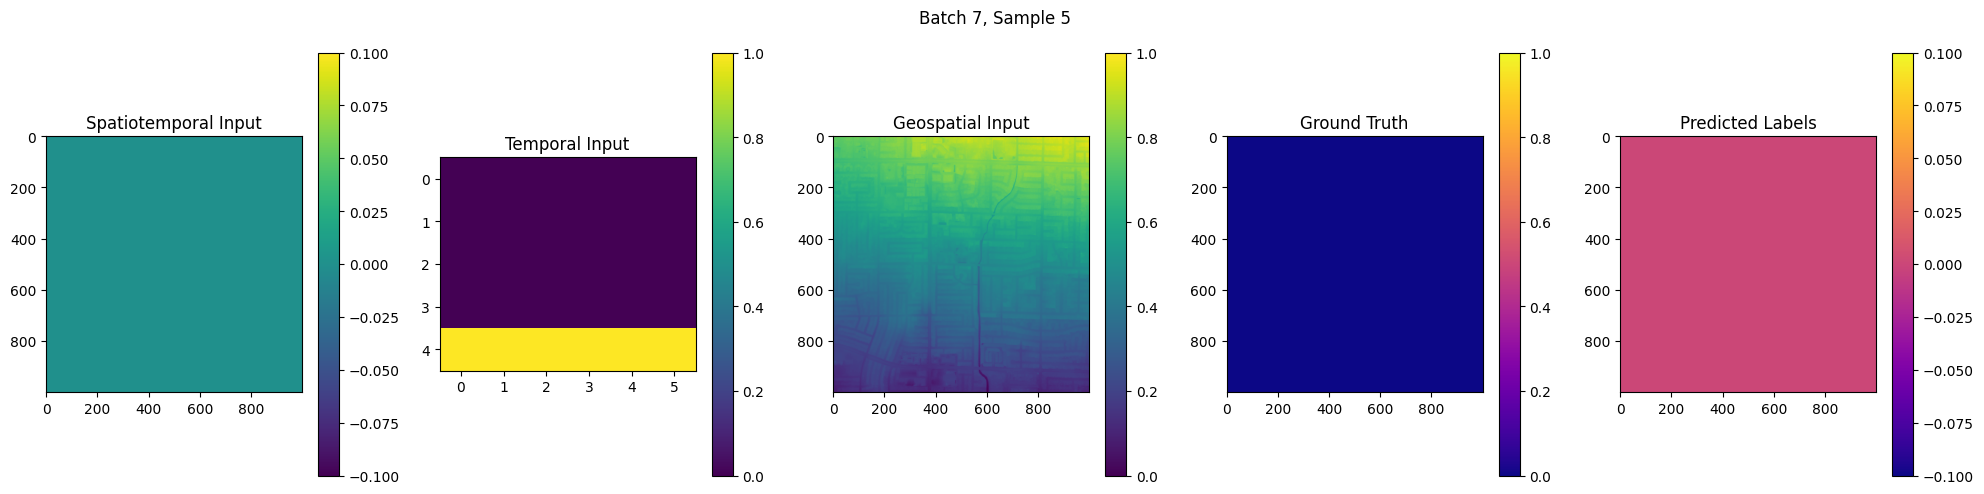

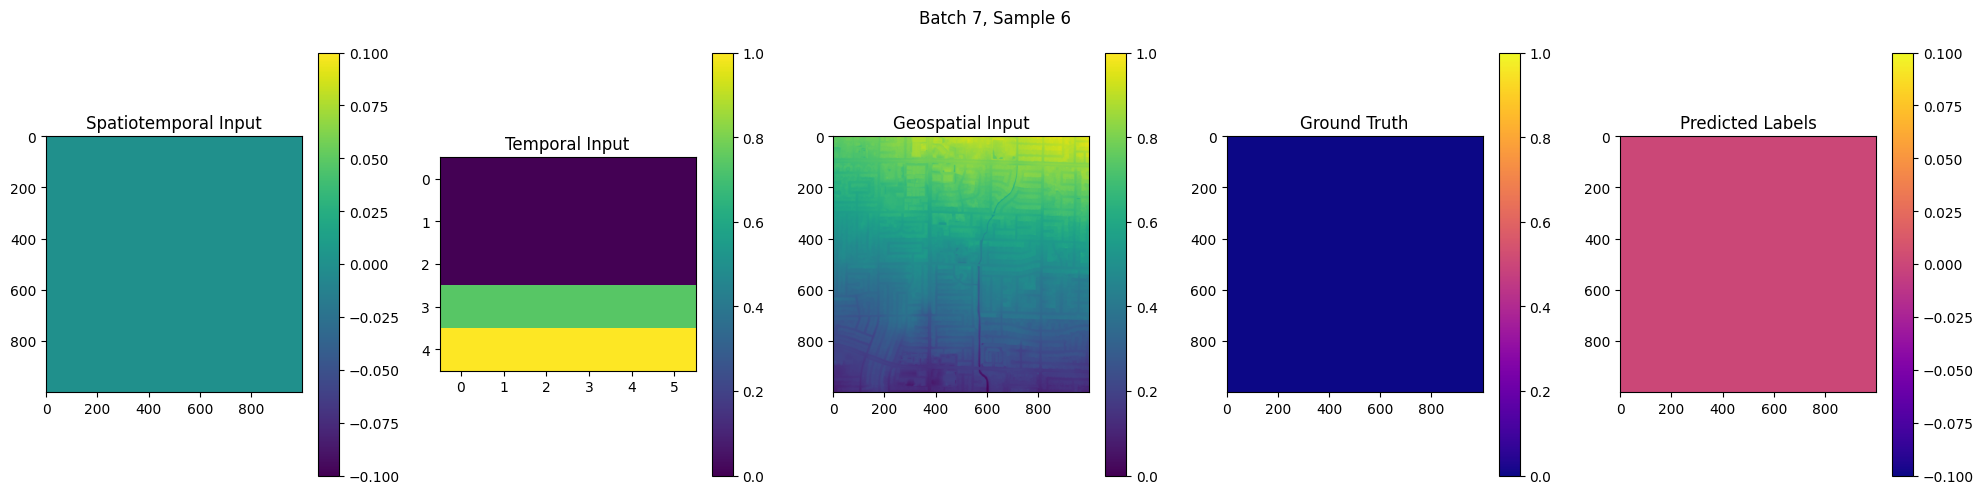

Visualizing Batch 8/10
Ground Truth Shape: (6, 1000, 1000)
Input Data[geospatial] Shape: (6, 1000, 1000, 8)
Input Data[temporal] Shape: (6, 5, 6)
Input Data[spatiotemporal] Shape: (6, 5, 1000, 1000, 1)
1/1 [==============================] - 0s 136ms/step
Predicted Labels Shape: (6, 1000, 1000, 1)


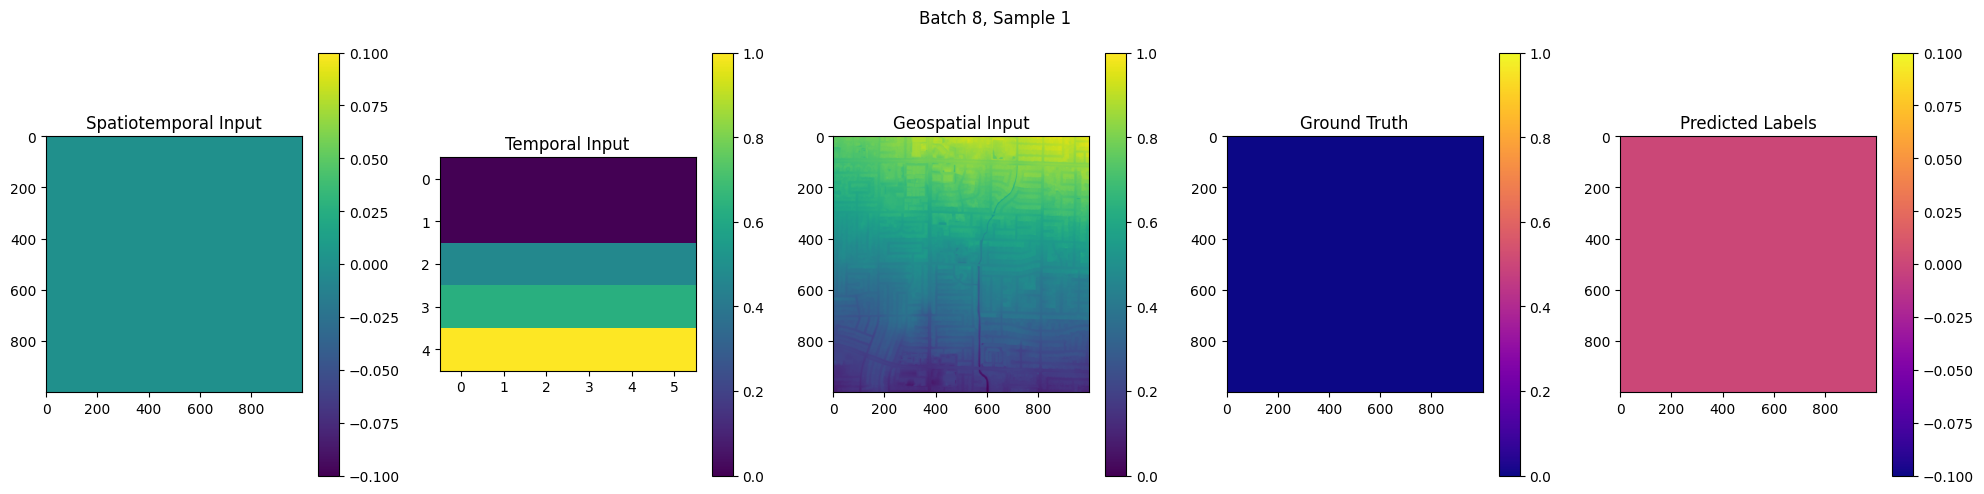

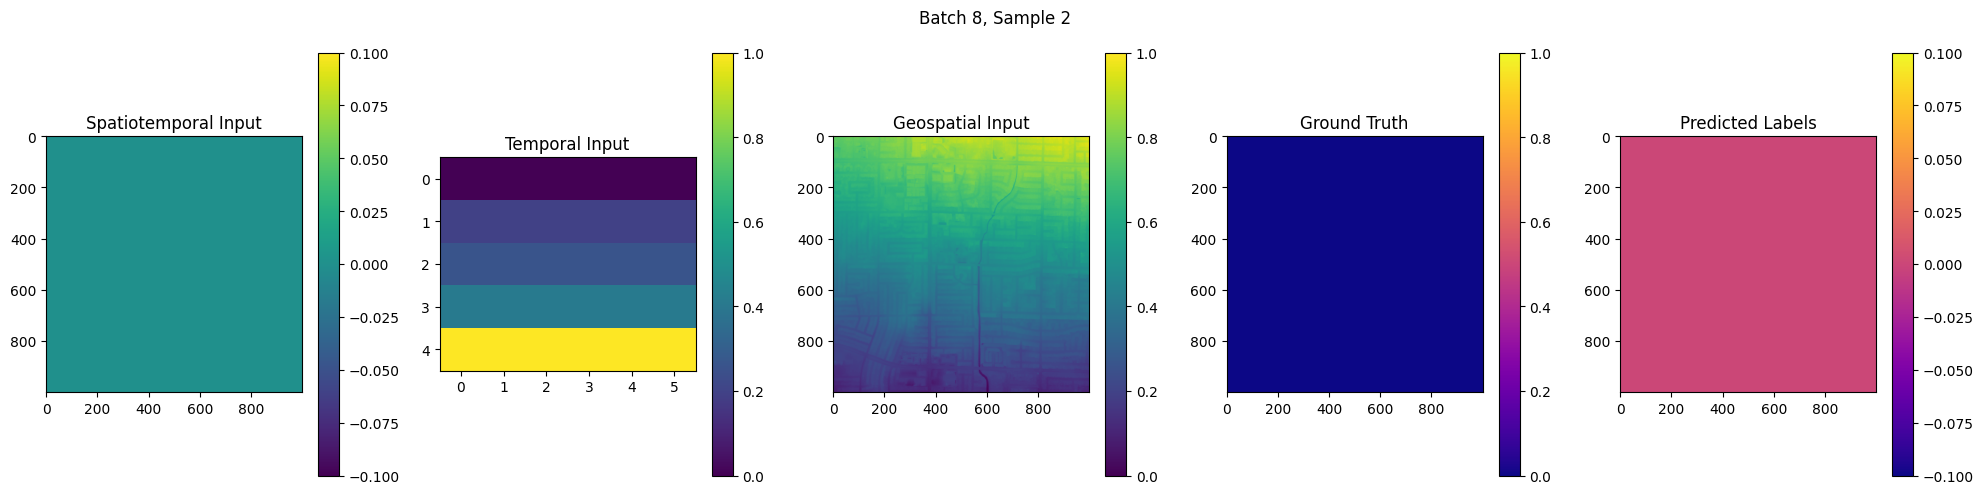

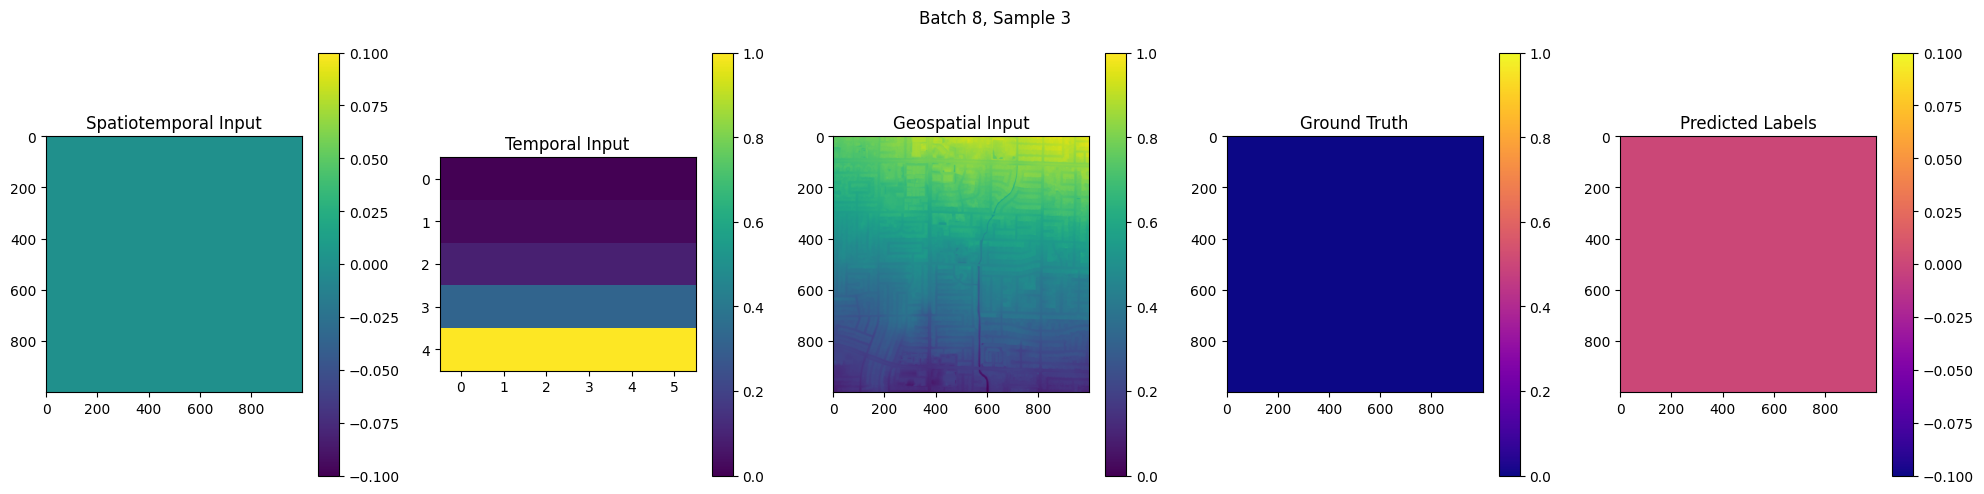

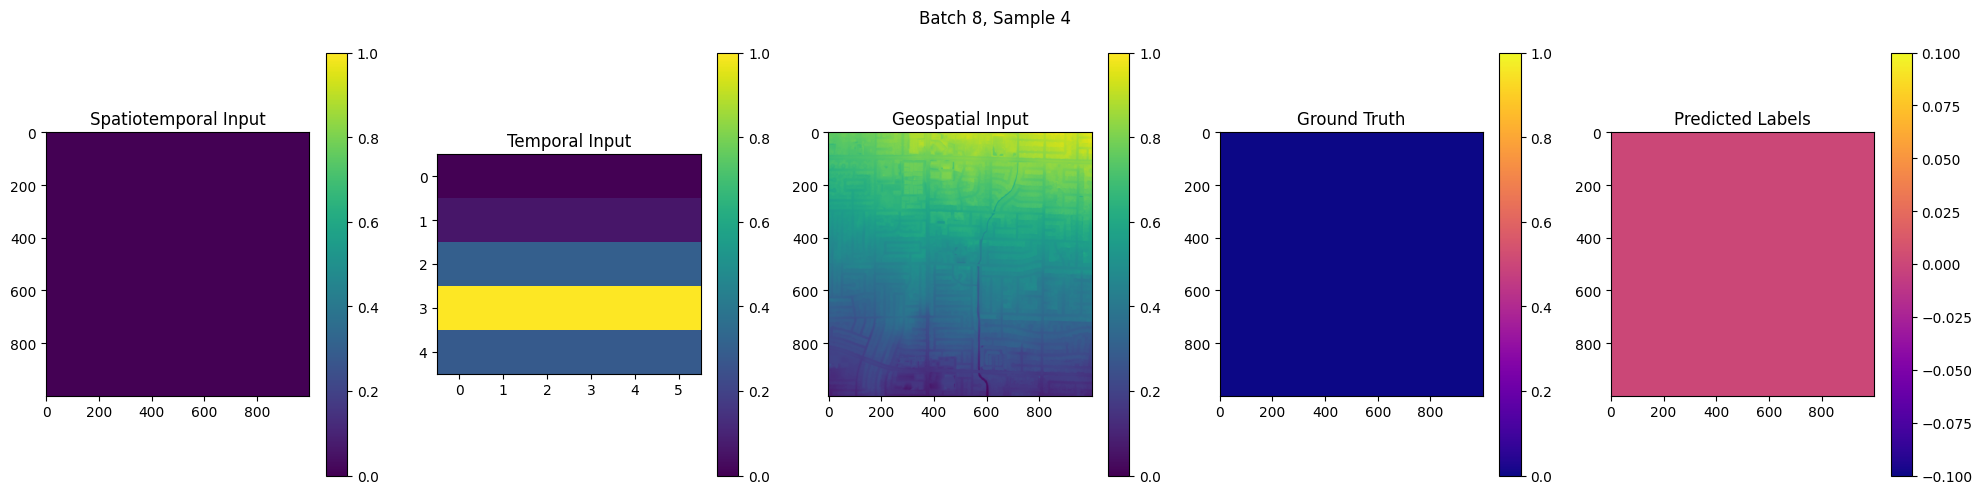

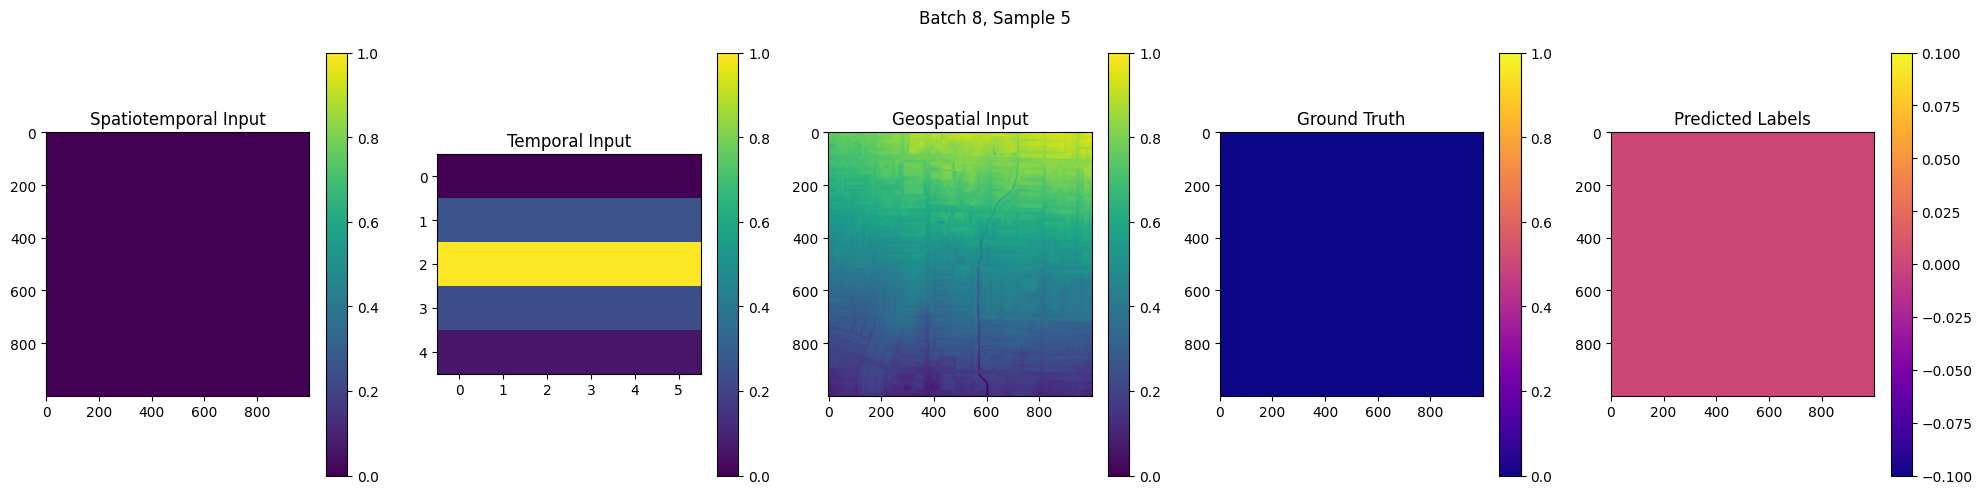

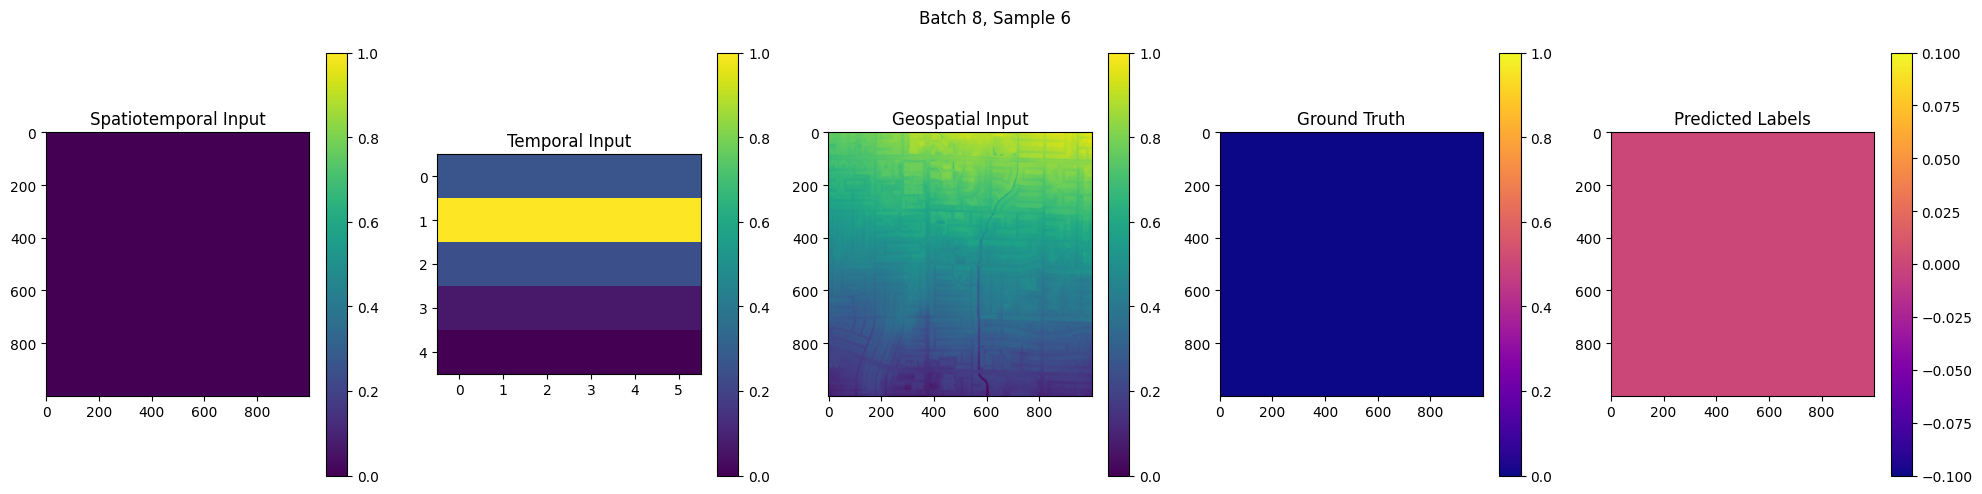

Visualizing Batch 9/10
Ground Truth Shape: (6, 1000, 1000)
Input Data[geospatial] Shape: (6, 1000, 1000, 8)
Input Data[temporal] Shape: (6, 5, 6)
Input Data[spatiotemporal] Shape: (6, 5, 1000, 1000, 1)
1/1 [==============================] - 0s 138ms/step
Predicted Labels Shape: (6, 1000, 1000, 1)


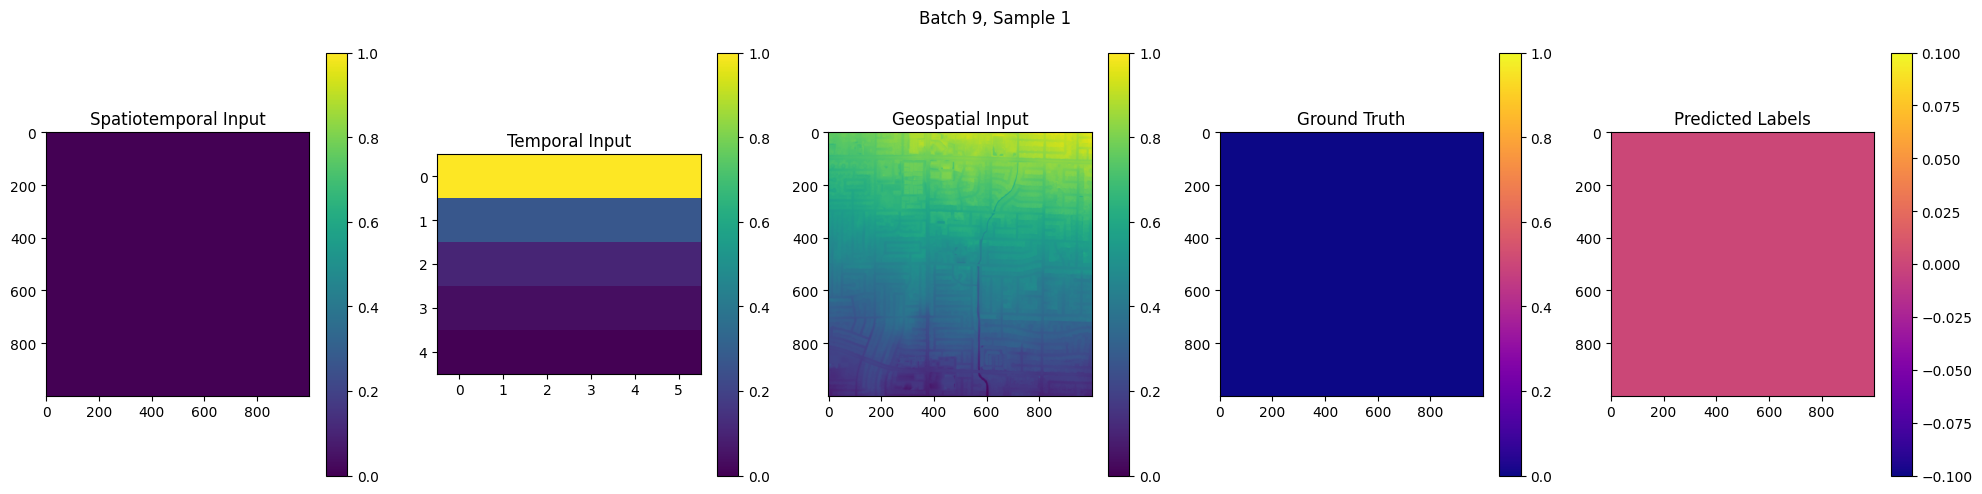

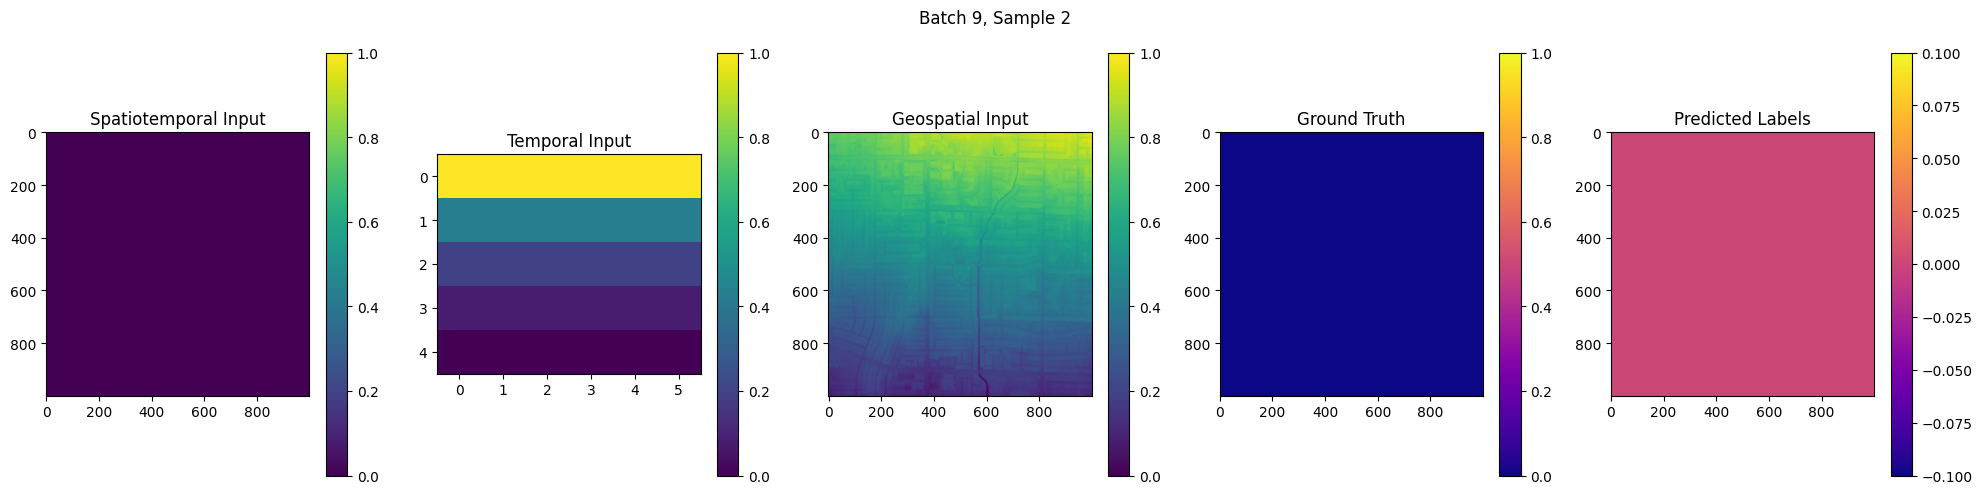

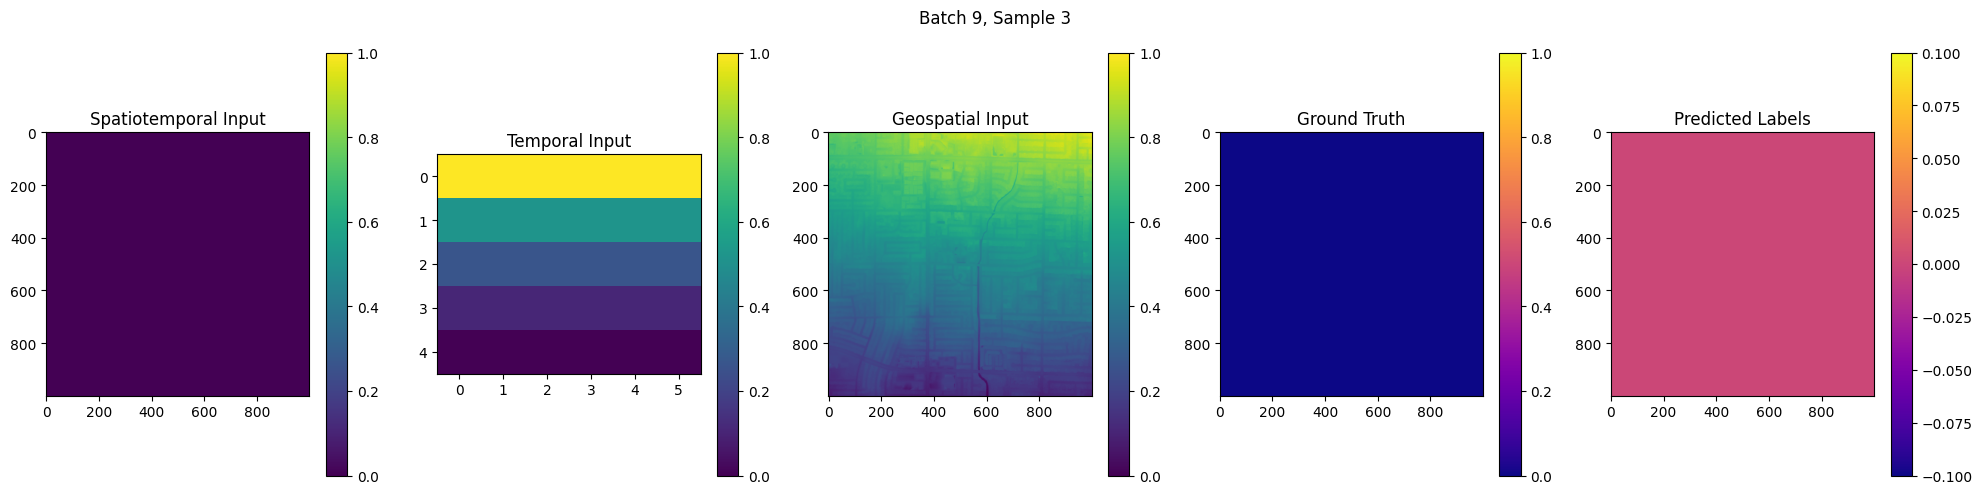

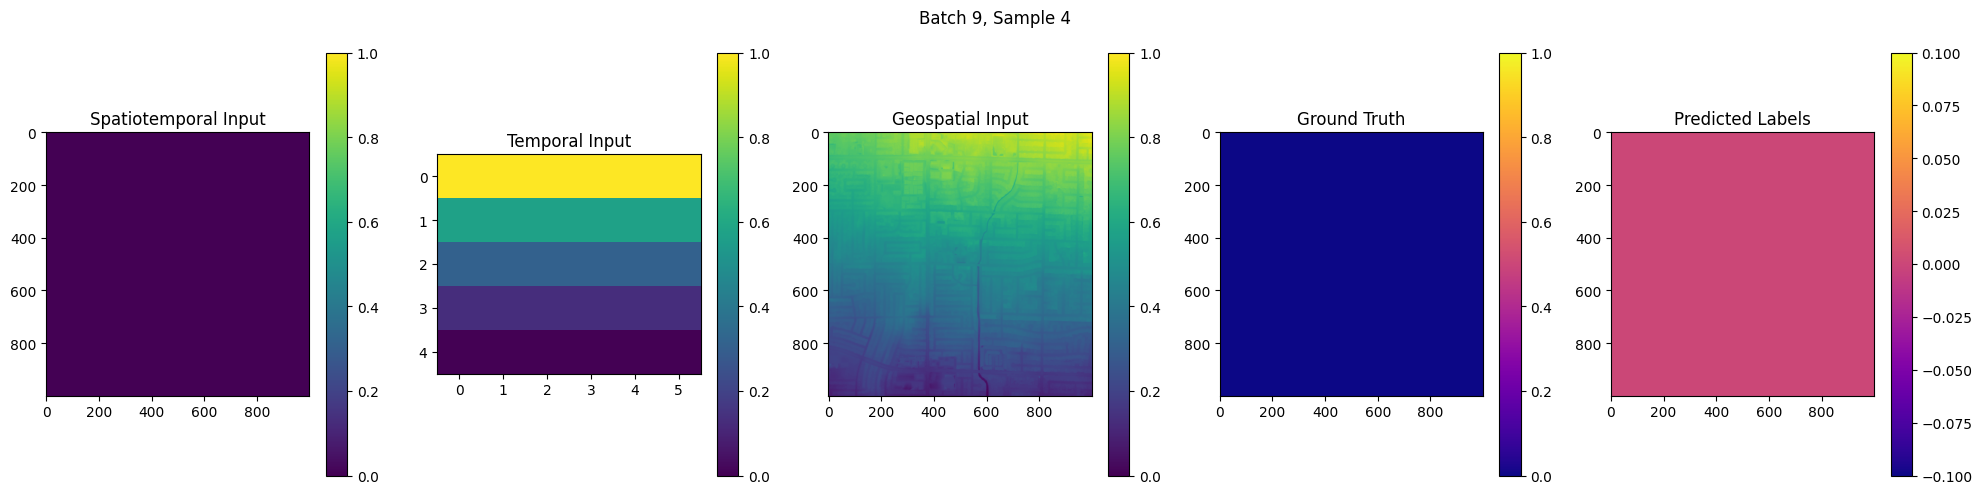

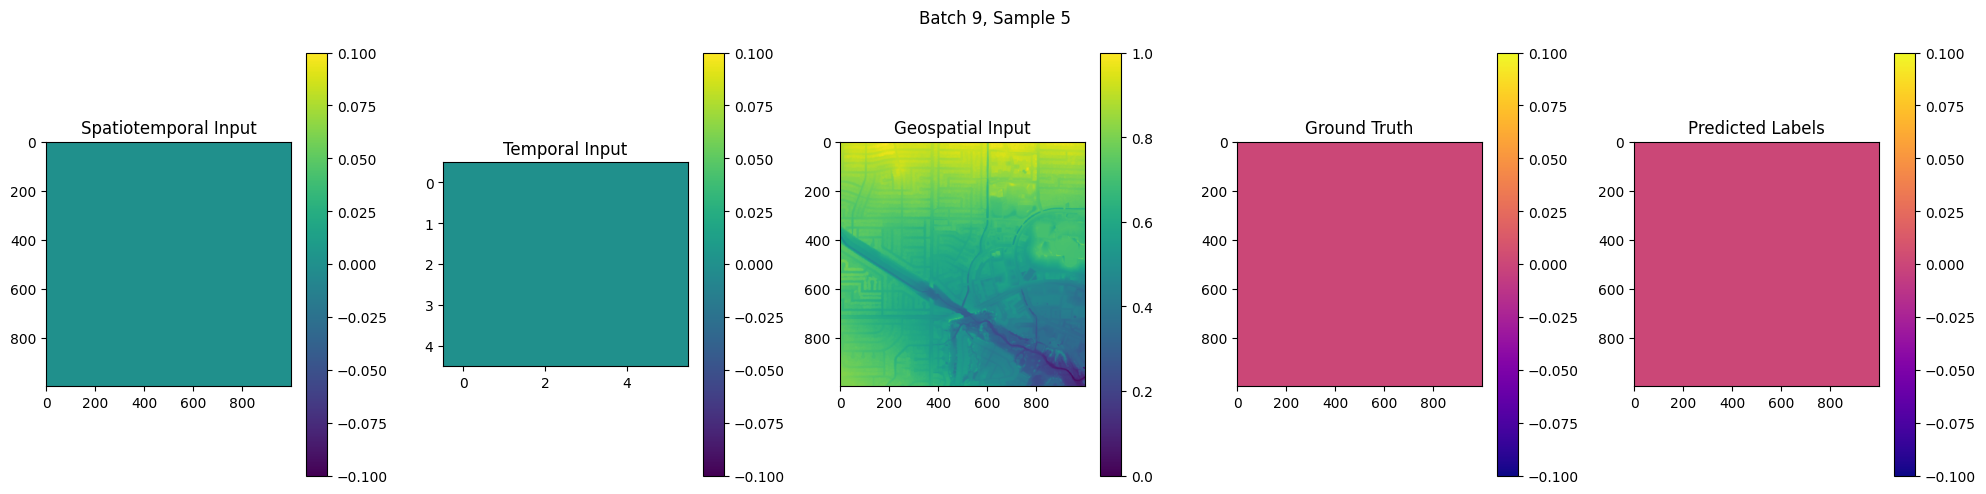

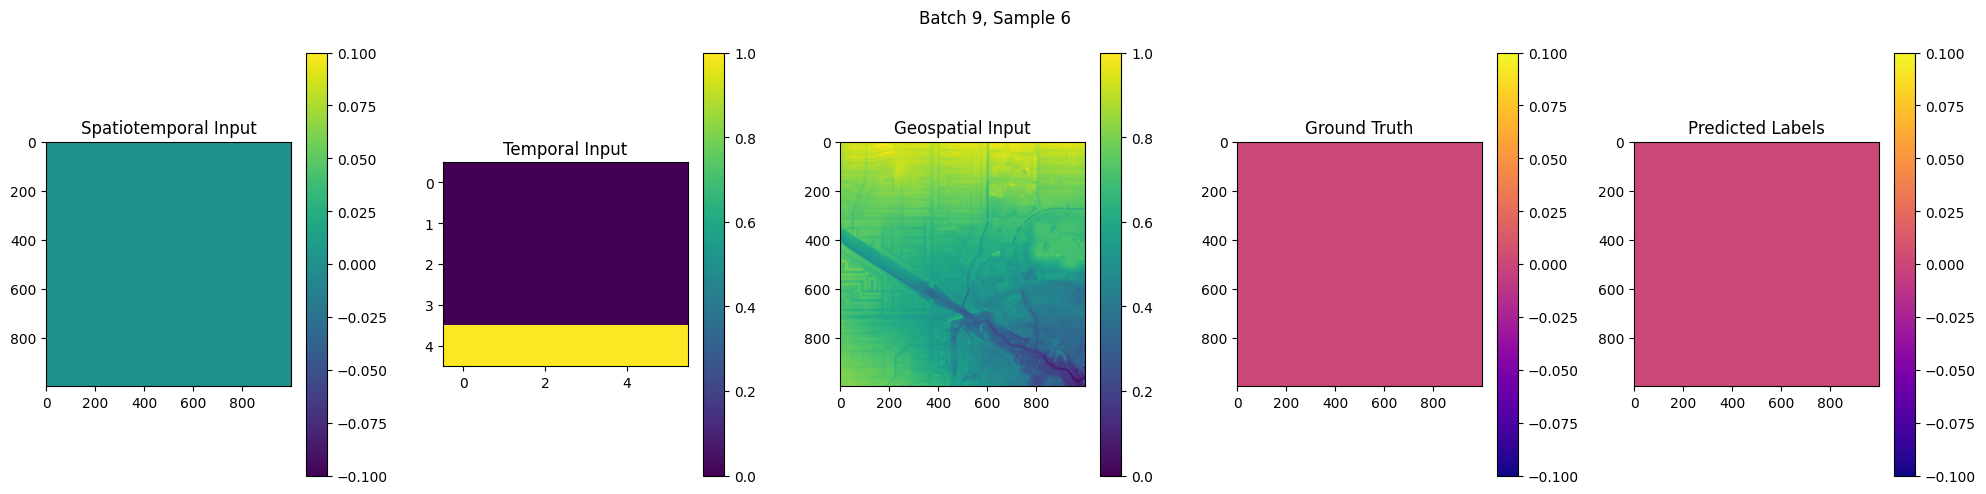

Visualizing Batch 10/10
Ground Truth Shape: (6, 1000, 1000)
Input Data[geospatial] Shape: (6, 1000, 1000, 8)
Input Data[temporal] Shape: (6, 5, 6)
Input Data[spatiotemporal] Shape: (6, 5, 1000, 1000, 1)
1/1 [==============================] - 0s 134ms/step
Predicted Labels Shape: (6, 1000, 1000, 1)


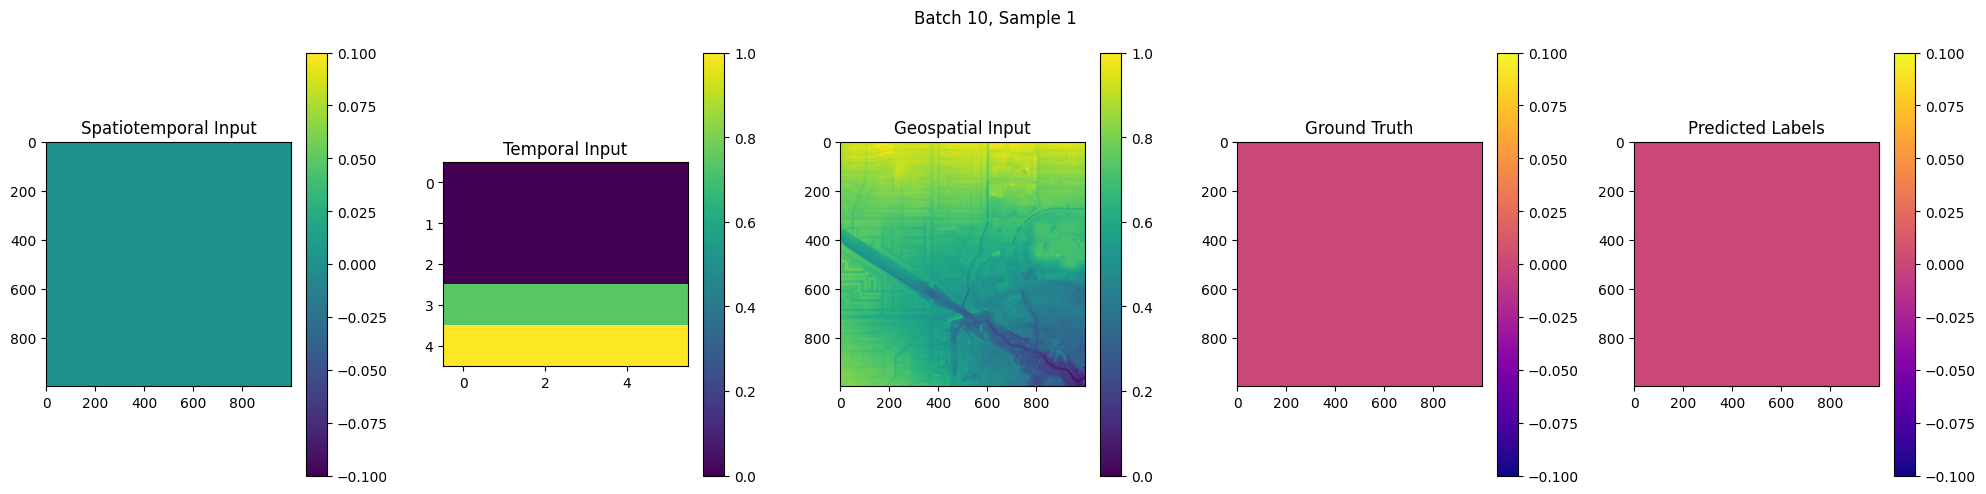

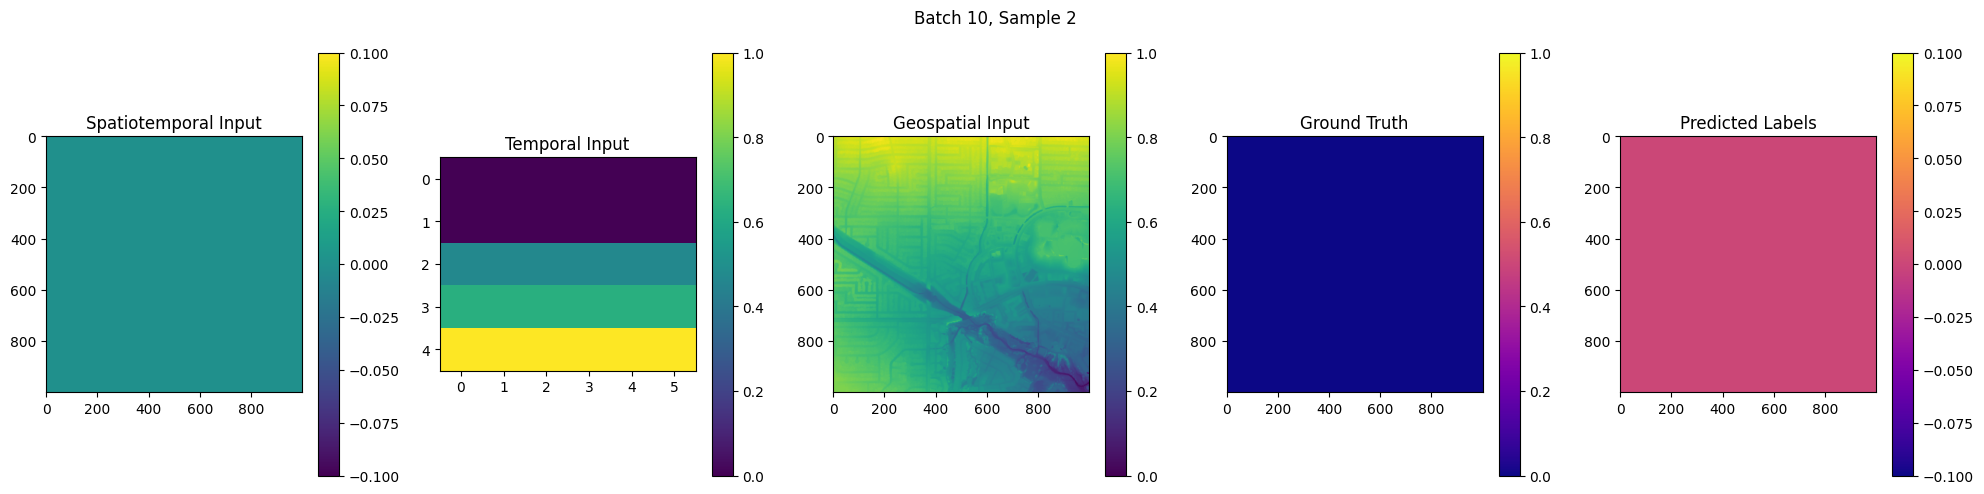

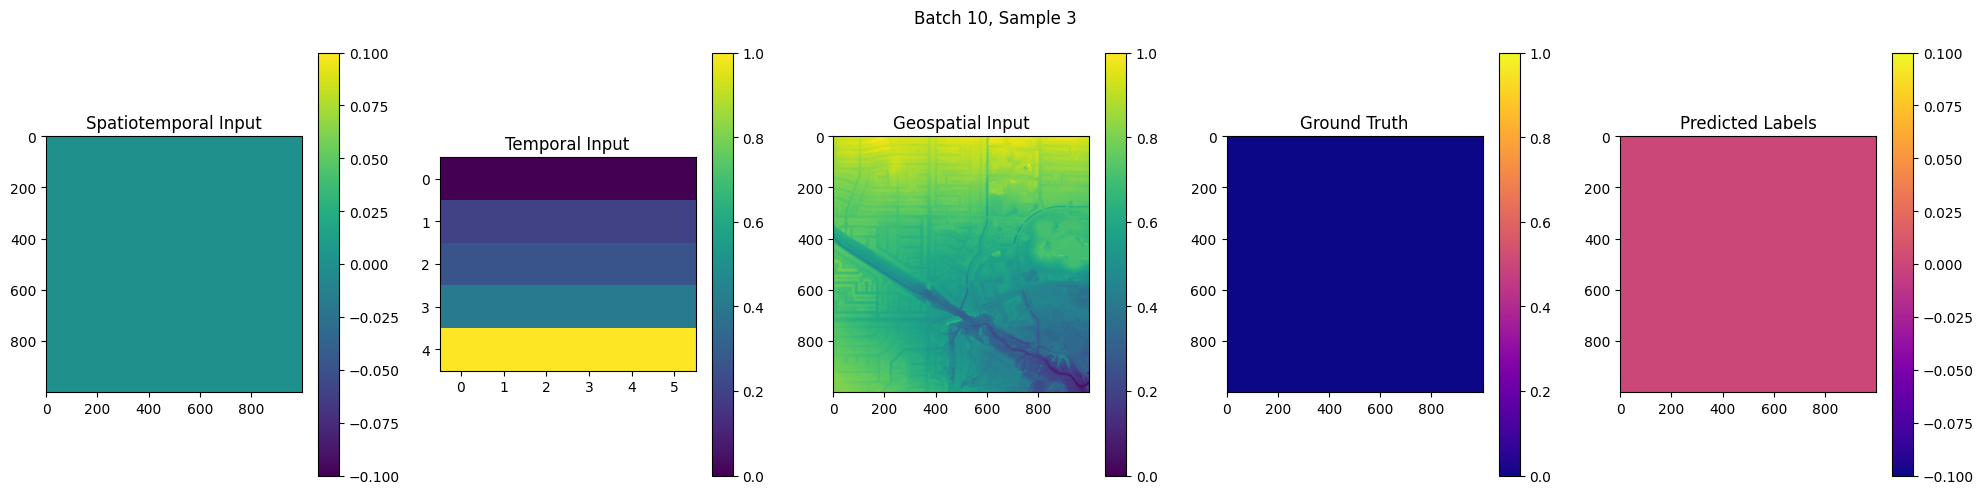

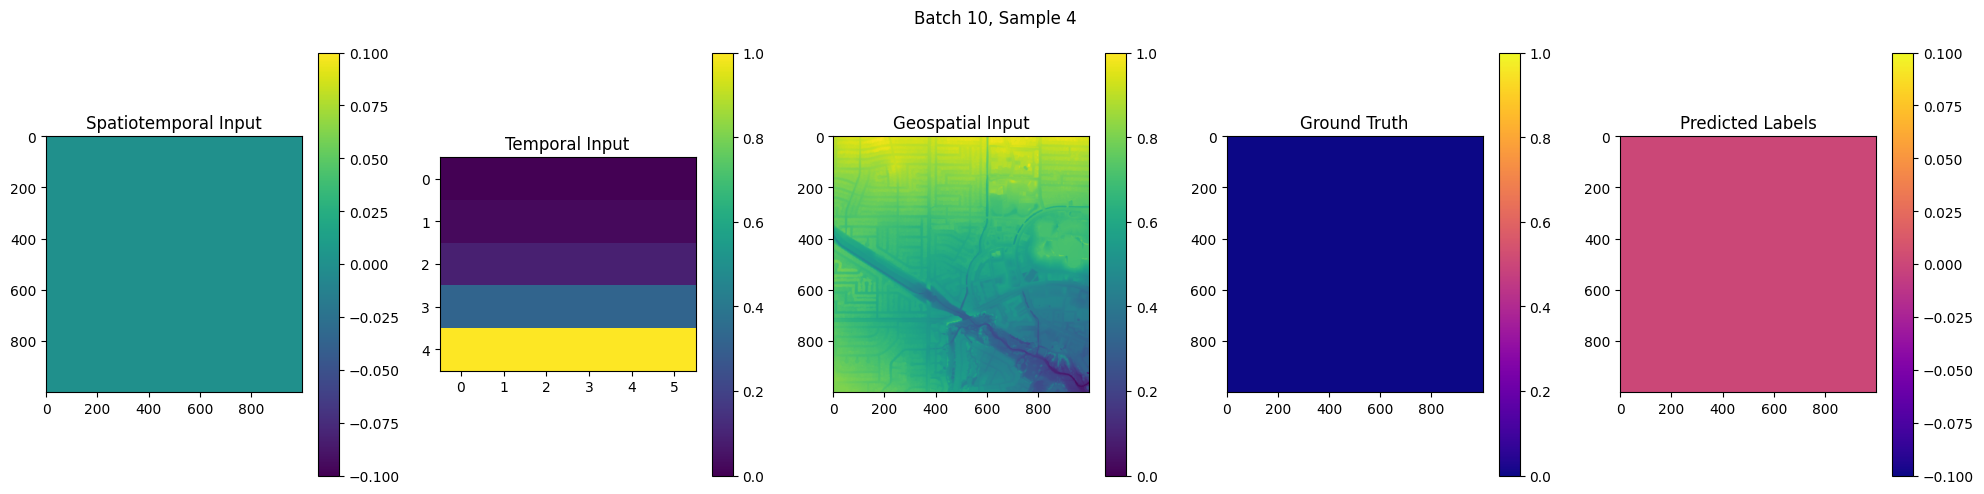

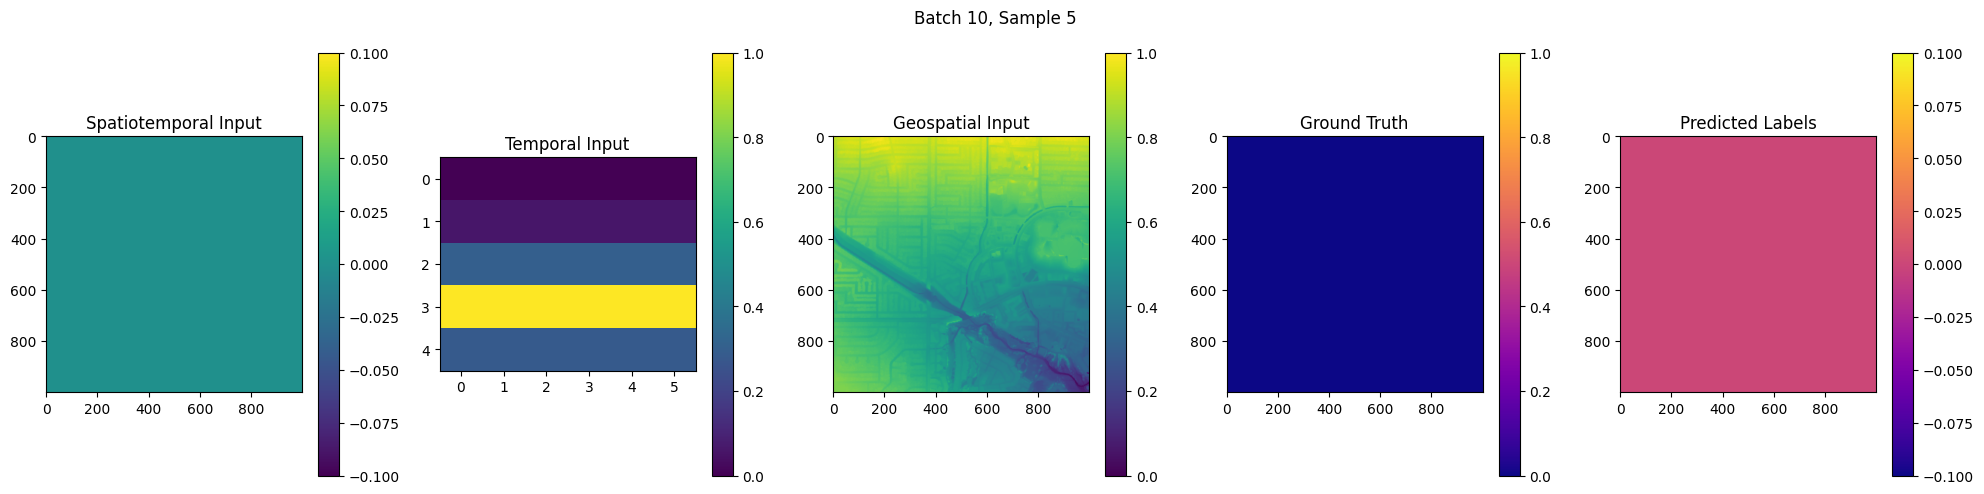

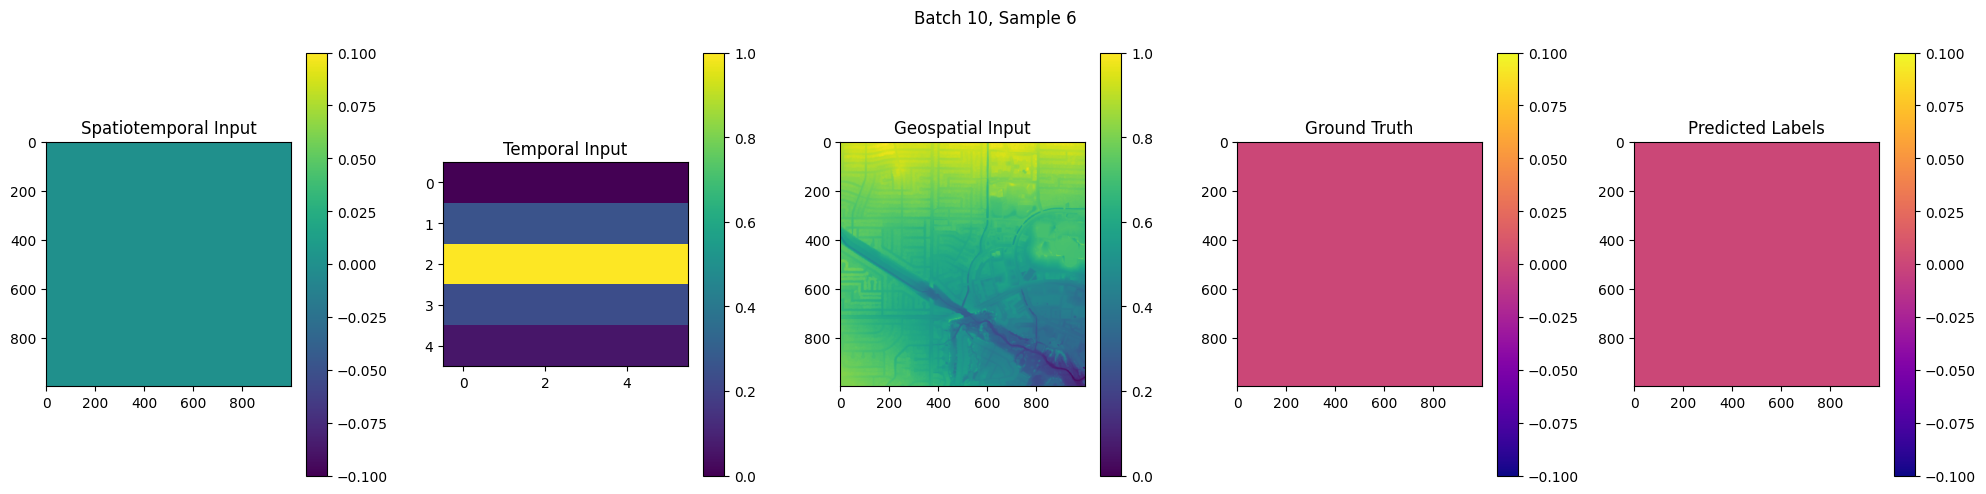

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def normalize(image_tensor):
    """
    Normalize a TensorFlow tensor to the range [0, 1].
    """
    image_tensor = tf.cast(image_tensor, tf.float32)
    min_val = tf.reduce_min(image_tensor)
    max_val = tf.reduce_max(image_tensor)
    image_tensor = image_tensor - min_val
    if max_val > min_val:
        image_tensor = image_tensor / (max_val - min_val)
    return image_tensor

# Configurable number of batches and samples per batch
num_batches = 10  # Number of batches to visualize
num_samples_per_batch = 6  # Number of samples to visualize per batch

# Loop through batches
for batch_idx, (input_data, ground_truth) in enumerate(dataset.take(num_batches)):
    print(f"Visualizing Batch {batch_idx + 1}/{num_batches}")
    print("Ground Truth Shape:", ground_truth.shape)
    for k, v in input_data.items():
        print(f"Input Data[{k}] Shape: {v.shape}")

    # Get predicted labels
    predicted_labels = model._model.predict(input_data)
    print("Predicted Labels Shape:", predicted_labels.shape)

    # Visualize samples from this batch
    batch_size = ground_truth.shape[0]
    num_to_show = min(num_samples_per_batch, batch_size)  # Handle smaller batches

    for sample_index in range(num_to_show):
        # Normalize and prepare inputs for visualization
        spatiotemporal_sample = normalize(input_data['spatiotemporal'][sample_index, 0, :, :, 0])
        temporal_sample = normalize(input_data['temporal'][sample_index, :, :])
        geospatial_sample = normalize(input_data['geospatial'][sample_index, :, :, 0])

        # Normalize and prepare labels and predictions
        gt_sample = normalize(tf.squeeze(ground_truth[sample_index]))
        pred_sample = normalize(predicted_labels[sample_index, :, :, 0])

        # Convert to NumPy for plotting
        spatiotemporal_np = spatiotemporal_sample.numpy()
        temporal_np = temporal_sample.numpy()
        geospatial_np = geospatial_sample.numpy()
        gt_sample_np = gt_sample.numpy()
        pred_sample_np = pred_sample.numpy()

        # Plot all samples
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        im0 = axes[0].imshow(spatiotemporal_np, cmap='viridis')
        axes[0].set_title("Spatiotemporal Input")
        fig.colorbar(im0, ax=axes[0])

        im1 = axes[1].imshow(temporal_np, cmap='viridis')
        axes[1].set_title("Temporal Input")
        fig.colorbar(im1, ax=axes[1])

        im2 = axes[2].imshow(geospatial_np, cmap='viridis')
        axes[2].set_title("Geospatial Input")
        fig.colorbar(im2, ax=axes[2])

        im3 = axes[3].imshow(gt_sample_np, cmap='plasma')
        axes[3].set_title("Ground Truth")
        fig.colorbar(im3, ax=axes[3])

        im4 = axes[4].imshow(pred_sample_np, cmap='plasma')
        axes[4].set_title("Predicted Labels")
        fig.colorbar(im4, ax=axes[4])

        plt.suptitle(f"Batch {batch_idx + 1}, Sample {sample_index + 1}")
        plt.tight_layout()
        plt.show()


In [30]:
# Prediction before training
model2 = FloodModel(FloodModelParams())

Ground Truth Shape: (6, 1000, 1000)
Input Data[geospatial] Shape: (6, 1000, 1000, 8)
Input Data[temporal] Shape: (6, 5, 6)
Input Data[spatiotemporal] Shape: (6, 5, 1000, 1000, 1)
1/1 [==============================] - 1s 525ms/step
Predicted Labels Shape: (6, 1000, 1000, 1)


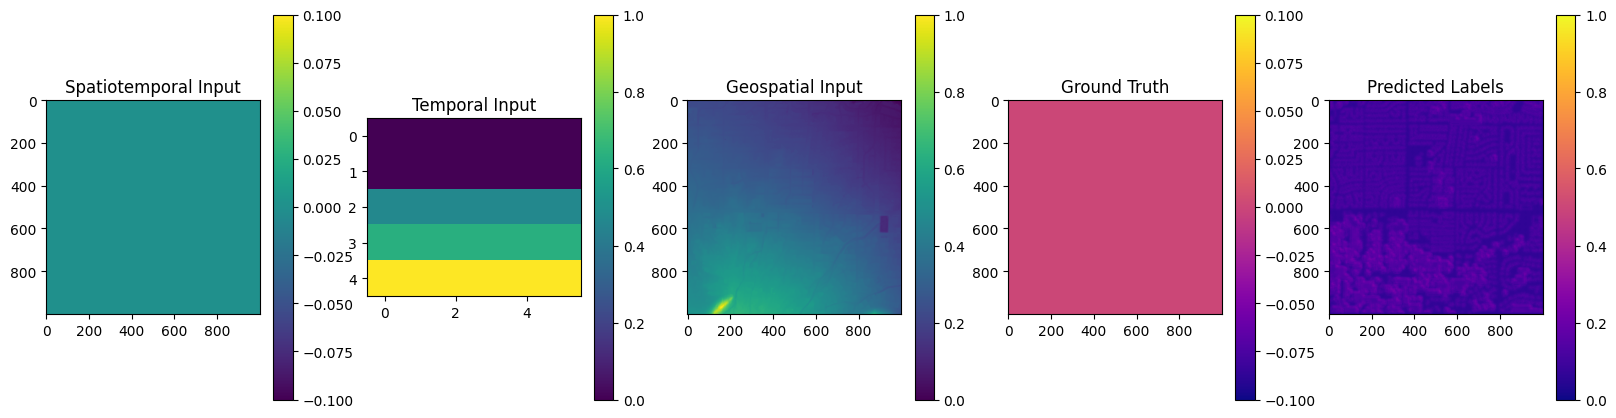

In [31]:

# Example loop to visualize
for input_data, ground_truth in dataset.take(1):
    print("Ground Truth Shape:", ground_truth.shape)
    for k, v in input_data.items():
        print(f"Input Data[{k}] Shape: {v.shape}")

    # Get predicted labels
    # Get predicted labels (without the 'training' argument)
    predicted_labels = model2._model.predict(input_data)

    print("Predicted Labels Shape:", predicted_labels.shape)

    # Choose a sample to visualize
    sample_index = 3

    # Normalize and prepare inputs for visualization
    spatiotemporal_sample = normalize(input_data['spatiotemporal'][sample_index, 0, :, :, 0])
    temporal_sample = normalize(input_data['temporal'][sample_index, :, :])
    geospatial_sample = normalize(input_data['geospatial'][sample_index, :, :, 0])

    # Normalize and prepare labels and predictions
    gt_sample = normalize(tf.squeeze(ground_truth[sample_index]))
    pred_sample = normalize(predicted_labels[sample_index, :, :, 0])

    # Convert to NumPy for plotting
    spatiotemporal_np = spatiotemporal_sample.numpy()
    temporal_np = temporal_sample.numpy()
    geospatial_np = geospatial_sample.numpy()
    gt_sample_np = gt_sample.numpy()
    pred_sample_np = pred_sample.numpy()

    # Plot all samples
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    im0 = axes[0].imshow(spatiotemporal_np, cmap='viridis')
    axes[0].set_title("Spatiotemporal Input")
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(temporal_np, cmap='viridis')
    axes[1].set_title("Temporal Input")
    fig.colorbar(im1, ax=axes[1])

    im2 = axes[2].imshow(geospatial_np, cmap='viridis')
    axes[2].set_title("Geospatial Input")
    fig.colorbar(im2, ax=axes[2])

    im3 = axes[3].imshow(gt_sample_np, cmap='plasma')
    axes[3].set_title("Ground Truth")
    fig.colorbar(im3, ax=axes[3])

    im4 = axes[4].imshow(pred_sample_np, cmap='plasma')
    axes[4].set_title("Predicted Labels")
    fig.colorbar(im4, ax=axes[4])

    plt.show()
    break  # Only visualize the first batch

In [ ]:
# Test calling the model on some data.
inputs, labels_ = next(iter(dataset))
prediction = model.call(inputs)
prediction.shape

In [ ]:
# Test calling the model for n predictions
full_dataset = load_dataset(sim_names=sim_names, batch_size=1)
inputs, labels_ = next(iter(full_dataset))
predictions = model.call_n(inputs, n=4)
predictions.shape